In [1]:
pwd  #checking current directory

'/workspace/copytodgx'

In [2]:
from numba import cuda
device = cuda.get_current_device()
device.reset()

In [3]:
import numpy as np
import pandas as pd
import glob
#from glob import glob
import random
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image
import time
from math import ceil
import os
import cv2
import copy
from tqdm import tqdm
import tensorboard
from itertools import permutations
import seaborn as sns

In [4]:
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("default")
import torch
import torch.nn as nn
import torch.optim as optim
import torch, math
import torch.fft
import torchvision
from torchvision import transforms
import torchvision.transforms as transforms
from torchvision.transforms import ToTensor, Compose, Resize, RandomHorizontalFlip, RandomVerticalFlip,Normalize
#from torchvision.transforms import Compose, ToTensor, Normalize
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torch import nn, einsum
from einops import rearrange, repeat
from einops.layers.torch import Rearrange
from einops import reduce
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()
torch.cuda.empty_cache()
out='./results'
if not os.path.exists(out):
    os.makedirs(out)
from torchvision.models import resnet50
import segmentation_models_pytorch as smp

/usr/local/lib/python3.10/dist-packages/torch/utils/tensorboard/__init__.py:2: DeprecationWarning: The distutils package is deprecated and slated for removal in Python 3.12. Use setuptools or check PEP 632 for potential alternatives
  from distutils.version import LooseVersion
/usr/local/lib/python3.10/dist-packages/flatbuffers/compat.py:19: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  import imp


Extension horovod.torch has not been built: /usr/local/lib/python3.10/dist-packages/horovod/torch/mpi_lib_v2.cpython-310-x86_64-linux-gnu.so not found
If this is not expected, reinstall Horovod with HOROVOD_WITH_PYTORCH=1 to debug the build error.
Warning! MPI libs are missing, but python applications are still available.


/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
# Define custom dataset class
class RandomPatchDataset(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.masks = glob.glob(os.path.join(root_dir, 'newimagemask_1024', '*.png'))
        self.images = [mask.replace('.png', '.tiff').replace('newimagemask_1024', 'newimage_1024') for mask in self.masks]

    def __len__(self):
        return len(self.masks)

    def __getitem__(self, idx):
        # Randomly select an index
        random_idx = random.randint(0, len(self.masks) - 1)

        mask_path = self.masks[random_idx]
        image_path = self.images[random_idx]

        mask = Image.open(mask_path).convert('L')  # Ensure grayscale mask
        image = Image.open(image_path).convert('RGB')  # Load as RGB image

       

        # Define image transformations (normalization)
        transform = transforms.Compose([
            transforms.Resize((1024,1024)),
            transforms.ToTensor()
            
        ])

        image = transform(image)
        mask = transform(mask)

        image_filename = os.path.basename(image_path)
        mask_filename = os.path.basename(mask_path)

        return {'image': image, 'mask': mask.squeeze(0), 'image_filename': image_filename, 'mask_filename': mask_filename}

# Define the root directory of your dataset
root_dir = '/workspace/copytodgx/'

# Create an instance of your custom dataset class for training
ds = RandomPatchDataset(root_dir)

# Split the dataset into training and validation sets
total_samples = len(ds)
print('total_samples:',total_samples)
train_ratio = 0.70  # 70% for training, adjust as needed
train_size = int(total_samples * train_ratio)
print('train_size:',train_size)
val_size = total_samples - train_size
print('val_size:',val_size)

# Use torch.utils.data.random_split to split the dataset
train_ds, val_ds = torch.utils.data.random_split(ds, [train_size, val_size])
print('train_images:',len(train_ds),'val_images:',len(val_ds))
# Create data loaders for training and validation
train_dl = DataLoader(train_ds, batch_size=16, shuffle=True, num_workers=4)
val_dl = DataLoader(val_ds, batch_size=16, shuffle=False, num_workers=4)

total_samples: 3296
train_size: 2307
val_size: 989
train_images: 2307 val_images: 989


image_shape torch.Size([3, 1024, 1024])
mask_shape torch.Size([1024, 1024])


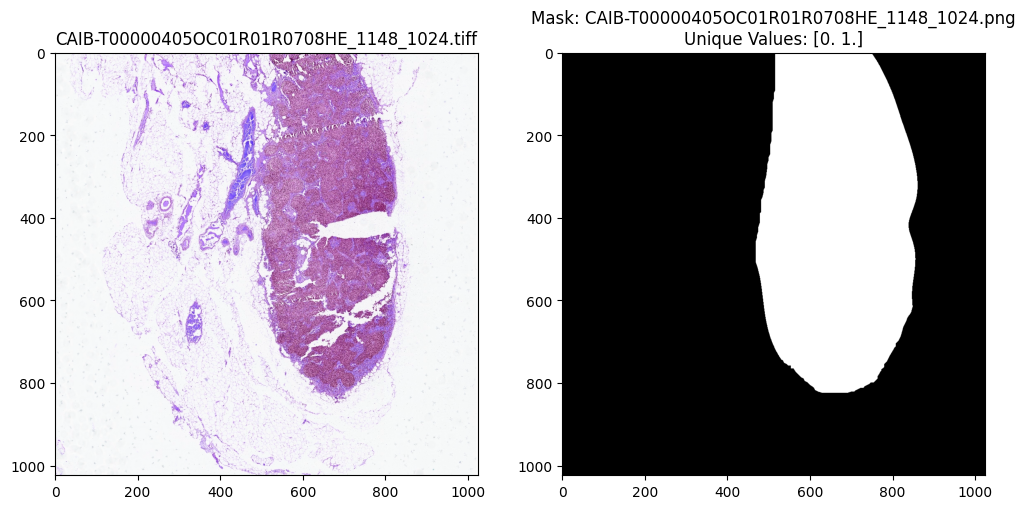

In [7]:
tdata = train_ds.__getitem__(0)
unique_mask_values = np.unique(tdata['mask'])
unique_image_values = np.unique(tdata['image'])

fig, axes = plt.subplots(1, 2, figsize=(12, 6))  

#print(tdata['image'])
#print(tdata['mask'])
print('image_shape',tdata['image'].shape)
print('mask_shape',tdata['mask'].shape)



axes[0].imshow(tdata['image'].permute(1,2,0),cmap = 'RdBu_r',vmin=0,vmax=1)
axes[0].set_title(tdata['image_filename'])

axes[1].imshow(tdata['mask'], cmap='gray', vmin=0, vmax=1)

axes[1].set_title(f"Mask: {tdata['mask_filename']}\nUnique Values: {unique_mask_values}")

plt.show()

In [19]:
#model1


# Define hyperparameters
learning_rate = 0.001  # Adjust the learning rate as needed
num_epochs = 50
best_val_loss = float('inf')

# Define dataset and data loader (train and validation)
#train_dl = DataLoader(train_ds, batch_size=16, shuffle=True, num_workers=16)
#val_dl = DataLoader(val_ds, batch_size=16, shuffle=False, num_workers=16)

device ='cuda:0'
# Check if multiple GPUs are available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define model and move it to the device
model = smp.Unet(
    encoder_name="resnet34",
    encoder_weights="imagenet",
    in_channels=3,
    classes=2,  
)
model = model.to(device)
#model = torch.nn.DataParallel(model)
#cpu = torch.device('cpu')
#model=model.to(device)

# Define loss function and optimizer
#criterion = torch.nn.CrossEntropyLoss().to(device) # Binary Cross-Entropy loss
criterion = smp.losses.DiceLoss(mode='multiclass')
#criterion = smp.losses.FocalLoss(mode='multiclass')
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
best_epoch = 0
for epoch in range(num_epochs):
    print(f'Epoch {epoch+1} is running')
    train_loss = 0.0
    model.train()  # Set the model to training mode

    for data in tqdm(train_dl):
        optimizer.zero_grad()
        image = data['image'].to(device)
        # Assuming mask is a single-channel binary mask
        mask = data['mask'].long().to(device)


        # Forward pass
        outputs = model(image)


        # Calculate the loss
        loss = criterion(outputs, mask)

        #print(f'Ground Truth Mask Size: {mask.size()}, Model Output Mask Size: {outputs.size()}')

        # Backpropagation and optimization
        loss.backward()
        optimizer.step()

        # Accumulate the training loss
        train_loss += loss.item()

    # Calculate and print the average training loss for this epoch
    avg_train_loss = train_loss / len(train_dl)
    print(f"Epoch {epoch + 1} - Training Loss: {avg_train_loss:.4f}")

    # Validation loop
    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0

    with torch.no_grad():
        for data in tqdm(val_dl):
            image = data['image'].to(device)
            # Assuming mask is a single-channel binary mask
            mask = data['mask'].long().to(device)

           
            # Forward pass
            outputs = model(image)


            # Calculate the validation loss
            loss = criterion(outputs, mask)


            # Accumulate the validation loss
            val_loss += loss.item()

    # Calculate and print the average validation loss for this epoch
    avg_val_loss = val_loss / len(val_dl)
    print(f"Epoch {epoch + 1} - Validation Loss: {avg_val_loss:.4f}")

    # Save the model if it performs better than the previous best on the validation set
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_epoch = epoch 
        torch.save(model.state_dict(), 'Unet_diceloss.pth')
        print(f"Latest saved model: Epoch {epoch + 1} - Validation Loss: {avg_val_loss:.4f}")


        
print(f"Best Model: Epoch {best_epoch + 1} - Validation Loss: {best_val_loss:.4f}")

        
# Save the final model
torch.save(model.state_dict(), 'Unet_diceloss_f.pth')
print('Finished training')


Epoch 1 is running


100%|██████████████████████████████████████████████████| 145/145 [01:48<00:00,  1.34it/s]


Epoch 1 - Training Loss: 0.1836


100%|████████████████████████████████████████████████████| 62/62 [00:13<00:00,  4.47it/s]


Epoch 1 - Validation Loss: 0.2129
Latest saved model: Epoch 1 - Validation Loss: 0.2129
Epoch 2 is running


100%|██████████████████████████████████████████████████| 145/145 [01:47<00:00,  1.34it/s]


Epoch 2 - Training Loss: 0.1445


100%|████████████████████████████████████████████████████| 62/62 [00:14<00:00,  4.39it/s]


Epoch 2 - Validation Loss: 0.1585
Latest saved model: Epoch 2 - Validation Loss: 0.1585
Epoch 3 is running


100%|██████████████████████████████████████████████████| 145/145 [01:48<00:00,  1.34it/s]


Epoch 3 - Training Loss: 0.1474


100%|████████████████████████████████████████████████████| 62/62 [00:14<00:00,  4.41it/s]


Epoch 3 - Validation Loss: 0.1834
Epoch 4 is running


100%|██████████████████████████████████████████████████| 145/145 [01:48<00:00,  1.34it/s]


Epoch 4 - Training Loss: 0.1495


100%|████████████████████████████████████████████████████| 62/62 [00:14<00:00,  4.42it/s]


Epoch 4 - Validation Loss: 0.1398
Latest saved model: Epoch 4 - Validation Loss: 0.1398
Epoch 5 is running


100%|██████████████████████████████████████████████████| 145/145 [01:48<00:00,  1.34it/s]


Epoch 5 - Training Loss: 0.1456


100%|████████████████████████████████████████████████████| 62/62 [00:14<00:00,  4.40it/s]


Epoch 5 - Validation Loss: 0.1856
Epoch 6 is running


100%|██████████████████████████████████████████████████| 145/145 [01:47<00:00,  1.34it/s]


Epoch 6 - Training Loss: 0.1538


100%|████████████████████████████████████████████████████| 62/62 [00:14<00:00,  4.41it/s]


Epoch 6 - Validation Loss: 0.1329
Latest saved model: Epoch 6 - Validation Loss: 0.1329
Epoch 7 is running


100%|██████████████████████████████████████████████████| 145/145 [01:47<00:00,  1.34it/s]


Epoch 7 - Training Loss: 0.1450


100%|████████████████████████████████████████████████████| 62/62 [00:13<00:00,  4.47it/s]


Epoch 7 - Validation Loss: 0.1688
Epoch 8 is running


100%|██████████████████████████████████████████████████| 145/145 [01:47<00:00,  1.34it/s]


Epoch 8 - Training Loss: 0.1438


100%|████████████████████████████████████████████████████| 62/62 [00:14<00:00,  4.35it/s]


Epoch 8 - Validation Loss: 0.1492
Epoch 9 is running


100%|██████████████████████████████████████████████████| 145/145 [01:48<00:00,  1.34it/s]


Epoch 9 - Training Loss: 0.1450


100%|████████████████████████████████████████████████████| 62/62 [00:14<00:00,  4.18it/s]


Epoch 9 - Validation Loss: 0.1296
Latest saved model: Epoch 9 - Validation Loss: 0.1296
Epoch 10 is running


100%|██████████████████████████████████████████████████| 145/145 [01:48<00:00,  1.33it/s]


Epoch 10 - Training Loss: 0.1327


100%|████████████████████████████████████████████████████| 62/62 [00:13<00:00,  4.48it/s]


Epoch 10 - Validation Loss: 0.1317
Epoch 11 is running


100%|██████████████████████████████████████████████████| 145/145 [01:48<00:00,  1.34it/s]


Epoch 11 - Training Loss: 0.1283


100%|████████████████████████████████████████████████████| 62/62 [00:13<00:00,  4.47it/s]


Epoch 11 - Validation Loss: 0.1597
Epoch 12 is running


100%|██████████████████████████████████████████████████| 145/145 [01:48<00:00,  1.34it/s]


Epoch 12 - Training Loss: 0.1335


100%|████████████████████████████████████████████████████| 62/62 [00:13<00:00,  4.47it/s]


Epoch 12 - Validation Loss: 0.1302
Epoch 13 is running


100%|██████████████████████████████████████████████████| 145/145 [01:48<00:00,  1.34it/s]


Epoch 13 - Training Loss: 0.1502


100%|████████████████████████████████████████████████████| 62/62 [00:13<00:00,  4.45it/s]


Epoch 13 - Validation Loss: 0.1527
Epoch 14 is running


100%|██████████████████████████████████████████████████| 145/145 [01:47<00:00,  1.35it/s]


Epoch 14 - Training Loss: 0.1396


100%|████████████████████████████████████████████████████| 62/62 [00:14<00:00,  4.41it/s]


Epoch 14 - Validation Loss: 0.1398
Epoch 15 is running


100%|██████████████████████████████████████████████████| 145/145 [01:48<00:00,  1.34it/s]


Epoch 15 - Training Loss: 0.1287


100%|████████████████████████████████████████████████████| 62/62 [00:13<00:00,  4.48it/s]


Epoch 15 - Validation Loss: 0.1518
Epoch 16 is running


100%|██████████████████████████████████████████████████| 145/145 [01:47<00:00,  1.35it/s]


Epoch 16 - Training Loss: 0.1448


100%|████████████████████████████████████████████████████| 62/62 [00:13<00:00,  4.46it/s]


Epoch 16 - Validation Loss: 0.1346
Epoch 17 is running


100%|██████████████████████████████████████████████████| 145/145 [01:48<00:00,  1.34it/s]


Epoch 17 - Training Loss: 0.1396


100%|████████████████████████████████████████████████████| 62/62 [00:14<00:00,  4.38it/s]


Epoch 17 - Validation Loss: 0.1255
Latest saved model: Epoch 17 - Validation Loss: 0.1255
Epoch 18 is running


100%|██████████████████████████████████████████████████| 145/145 [01:47<00:00,  1.35it/s]


Epoch 18 - Training Loss: 0.1263


100%|████████████████████████████████████████████████████| 62/62 [00:13<00:00,  4.49it/s]


Epoch 18 - Validation Loss: 0.1287
Epoch 19 is running


100%|██████████████████████████████████████████████████| 145/145 [01:47<00:00,  1.35it/s]


Epoch 19 - Training Loss: 0.1240


100%|████████████████████████████████████████████████████| 62/62 [00:13<00:00,  4.50it/s]


Epoch 19 - Validation Loss: 0.1319
Epoch 20 is running


100%|██████████████████████████████████████████████████| 145/145 [01:47<00:00,  1.35it/s]


Epoch 20 - Training Loss: 0.1136


100%|████████████████████████████████████████████████████| 62/62 [00:14<00:00,  4.24it/s]


Epoch 20 - Validation Loss: 0.1039
Latest saved model: Epoch 20 - Validation Loss: 0.1039
Epoch 21 is running


100%|██████████████████████████████████████████████████| 145/145 [01:47<00:00,  1.34it/s]


Epoch 21 - Training Loss: 0.1302


100%|████████████████████████████████████████████████████| 62/62 [00:13<00:00,  4.46it/s]


Epoch 21 - Validation Loss: 0.1364
Epoch 22 is running


100%|██████████████████████████████████████████████████| 145/145 [01:48<00:00,  1.34it/s]


Epoch 22 - Training Loss: 0.1112


100%|████████████████████████████████████████████████████| 62/62 [00:13<00:00,  4.45it/s]


Epoch 22 - Validation Loss: 0.1278
Epoch 23 is running


100%|██████████████████████████████████████████████████| 145/145 [01:48<00:00,  1.33it/s]


Epoch 23 - Training Loss: 0.1218


100%|████████████████████████████████████████████████████| 62/62 [00:14<00:00,  4.40it/s]


Epoch 23 - Validation Loss: 0.1020
Latest saved model: Epoch 23 - Validation Loss: 0.1020
Epoch 24 is running


100%|██████████████████████████████████████████████████| 145/145 [01:48<00:00,  1.34it/s]


Epoch 24 - Training Loss: 0.1347


100%|████████████████████████████████████████████████████| 62/62 [00:13<00:00,  4.43it/s]


Epoch 24 - Validation Loss: 0.0962
Latest saved model: Epoch 24 - Validation Loss: 0.0962
Epoch 25 is running


100%|██████████████████████████████████████████████████| 145/145 [01:47<00:00,  1.35it/s]


Epoch 25 - Training Loss: 0.1156


100%|████████████████████████████████████████████████████| 62/62 [00:13<00:00,  4.51it/s]


Epoch 25 - Validation Loss: 0.1091
Epoch 26 is running


100%|██████████████████████████████████████████████████| 145/145 [01:48<00:00,  1.34it/s]


Epoch 26 - Training Loss: 0.1152


100%|████████████████████████████████████████████████████| 62/62 [00:13<00:00,  4.48it/s]


Epoch 26 - Validation Loss: 0.1041
Epoch 27 is running


100%|██████████████████████████████████████████████████| 145/145 [01:47<00:00,  1.35it/s]


Epoch 27 - Training Loss: 0.1038


100%|████████████████████████████████████████████████████| 62/62 [00:13<00:00,  4.45it/s]


Epoch 27 - Validation Loss: 0.1212
Epoch 28 is running


100%|██████████████████████████████████████████████████| 145/145 [01:47<00:00,  1.34it/s]


Epoch 28 - Training Loss: 0.1052


100%|████████████████████████████████████████████████████| 62/62 [00:13<00:00,  4.56it/s]


Epoch 28 - Validation Loss: 0.0996
Epoch 29 is running


100%|██████████████████████████████████████████████████| 145/145 [01:47<00:00,  1.35it/s]


Epoch 29 - Training Loss: 0.1056


100%|████████████████████████████████████████████████████| 62/62 [00:13<00:00,  4.46it/s]


Epoch 29 - Validation Loss: 0.1399
Epoch 30 is running


100%|██████████████████████████████████████████████████| 145/145 [01:48<00:00,  1.34it/s]


Epoch 30 - Training Loss: 0.1053


100%|████████████████████████████████████████████████████| 62/62 [00:13<00:00,  4.54it/s]


Epoch 30 - Validation Loss: 0.1081
Epoch 31 is running


100%|██████████████████████████████████████████████████| 145/145 [01:47<00:00,  1.35it/s]


Epoch 31 - Training Loss: 0.1057


100%|████████████████████████████████████████████████████| 62/62 [00:14<00:00,  4.35it/s]


Epoch 31 - Validation Loss: 0.1921
Epoch 32 is running


100%|██████████████████████████████████████████████████| 145/145 [01:48<00:00,  1.34it/s]


Epoch 32 - Training Loss: 0.1017


100%|████████████████████████████████████████████████████| 62/62 [00:13<00:00,  4.48it/s]


Epoch 32 - Validation Loss: 0.1712
Epoch 33 is running


100%|██████████████████████████████████████████████████| 145/145 [01:47<00:00,  1.35it/s]


Epoch 33 - Training Loss: 0.1096


100%|████████████████████████████████████████████████████| 62/62 [00:14<00:00,  4.43it/s]


Epoch 33 - Validation Loss: 0.0962
Latest saved model: Epoch 33 - Validation Loss: 0.0962
Epoch 34 is running


100%|██████████████████████████████████████████████████| 145/145 [01:47<00:00,  1.34it/s]


Epoch 34 - Training Loss: 0.1027


100%|████████████████████████████████████████████████████| 62/62 [00:13<00:00,  4.51it/s]


Epoch 34 - Validation Loss: 0.0894
Latest saved model: Epoch 34 - Validation Loss: 0.0894
Epoch 35 is running


100%|██████████████████████████████████████████████████| 145/145 [01:48<00:00,  1.34it/s]


Epoch 35 - Training Loss: 0.0992


100%|████████████████████████████████████████████████████| 62/62 [00:13<00:00,  4.50it/s]


Epoch 35 - Validation Loss: 0.0839
Latest saved model: Epoch 35 - Validation Loss: 0.0839
Epoch 36 is running


100%|██████████████████████████████████████████████████| 145/145 [01:47<00:00,  1.35it/s]


Epoch 36 - Training Loss: 0.1103


100%|████████████████████████████████████████████████████| 62/62 [00:13<00:00,  4.50it/s]


Epoch 36 - Validation Loss: 0.0932
Epoch 37 is running


100%|██████████████████████████████████████████████████| 145/145 [01:48<00:00,  1.34it/s]


Epoch 37 - Training Loss: 0.0914


100%|████████████████████████████████████████████████████| 62/62 [00:14<00:00,  4.40it/s]


Epoch 37 - Validation Loss: 0.2002
Epoch 38 is running


100%|██████████████████████████████████████████████████| 145/145 [01:47<00:00,  1.34it/s]


Epoch 38 - Training Loss: 0.1054


100%|████████████████████████████████████████████████████| 62/62 [00:14<00:00,  4.29it/s]


Epoch 38 - Validation Loss: 0.1023
Epoch 39 is running


100%|██████████████████████████████████████████████████| 145/145 [01:47<00:00,  1.34it/s]


Epoch 39 - Training Loss: 0.0913


100%|████████████████████████████████████████████████████| 62/62 [00:14<00:00,  4.41it/s]


Epoch 39 - Validation Loss: 0.1070
Epoch 40 is running


100%|██████████████████████████████████████████████████| 145/145 [01:48<00:00,  1.34it/s]


Epoch 40 - Training Loss: 0.1049


100%|████████████████████████████████████████████████████| 62/62 [00:13<00:00,  4.51it/s]


Epoch 40 - Validation Loss: 0.0872
Epoch 41 is running


100%|██████████████████████████████████████████████████| 145/145 [01:47<00:00,  1.35it/s]


Epoch 41 - Training Loss: 0.1038


100%|████████████████████████████████████████████████████| 62/62 [00:14<00:00,  4.42it/s]


Epoch 41 - Validation Loss: 0.0948
Epoch 42 is running


100%|██████████████████████████████████████████████████| 145/145 [01:48<00:00,  1.34it/s]


Epoch 42 - Training Loss: 0.0925


100%|████████████████████████████████████████████████████| 62/62 [00:14<00:00,  4.30it/s]


Epoch 42 - Validation Loss: 0.1107
Epoch 43 is running


100%|██████████████████████████████████████████████████| 145/145 [01:48<00:00,  1.34it/s]


Epoch 43 - Training Loss: 0.1034


100%|████████████████████████████████████████████████████| 62/62 [00:13<00:00,  4.49it/s]


Epoch 43 - Validation Loss: 0.1043
Epoch 44 is running


100%|██████████████████████████████████████████████████| 145/145 [01:48<00:00,  1.33it/s]


Epoch 44 - Training Loss: 0.0884


100%|████████████████████████████████████████████████████| 62/62 [00:14<00:00,  4.40it/s]


Epoch 44 - Validation Loss: 0.0962
Epoch 45 is running


100%|██████████████████████████████████████████████████| 145/145 [01:48<00:00,  1.34it/s]


Epoch 45 - Training Loss: 0.0914


100%|████████████████████████████████████████████████████| 62/62 [00:14<00:00,  4.17it/s]


Epoch 45 - Validation Loss: 0.0873
Epoch 46 is running


100%|██████████████████████████████████████████████████| 145/145 [01:48<00:00,  1.34it/s]


Epoch 46 - Training Loss: 0.0897


100%|████████████████████████████████████████████████████| 62/62 [00:14<00:00,  4.34it/s]


Epoch 46 - Validation Loss: 0.0861
Epoch 47 is running


100%|██████████████████████████████████████████████████| 145/145 [01:47<00:00,  1.35it/s]


Epoch 47 - Training Loss: 0.0846


100%|████████████████████████████████████████████████████| 62/62 [00:13<00:00,  4.52it/s]


Epoch 47 - Validation Loss: 0.0934
Epoch 48 is running


100%|██████████████████████████████████████████████████| 145/145 [01:47<00:00,  1.35it/s]


Epoch 48 - Training Loss: 0.0880


100%|████████████████████████████████████████████████████| 62/62 [00:13<00:00,  4.43it/s]


Epoch 48 - Validation Loss: 0.0976
Epoch 49 is running


100%|██████████████████████████████████████████████████| 145/145 [01:47<00:00,  1.35it/s]


Epoch 49 - Training Loss: 0.0806


100%|████████████████████████████████████████████████████| 62/62 [00:14<00:00,  4.42it/s]


Epoch 49 - Validation Loss: 0.1339
Epoch 50 is running


100%|██████████████████████████████████████████████████| 145/145 [01:47<00:00,  1.35it/s]


Epoch 50 - Training Loss: 0.0869


100%|████████████████████████████████████████████████████| 62/62 [00:13<00:00,  4.44it/s]


Epoch 50 - Validation Loss: 0.0666
Latest saved model: Epoch 50 - Validation Loss: 0.0666
Best Model: Epoch 50 - Validation Loss: 0.0666
Finished training


In [8]:
#model2


# Define hyperparameters
learning_rate = 0.001  # Adjust the learning rate as needed
num_epochs = 50
best_val_loss = float('inf')

# Define dataset and data loader (train and validation)
#train_dl = DataLoader(train_ds, batch_size=16, shuffle=True, num_workers=16)
#val_dl = DataLoader(val_ds, batch_size=16, shuffle=False, num_workers=16)

device ='cuda:0'
# Check if multiple GPUs are available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define model and move it to the device
model = smp.Unet(
    encoder_name="resnet34",
    encoder_weights="imagenet",
    in_channels=1,
    classes=2,  
)
model = model.to(device)
#model = torch.nn.DataParallel(model)
#cpu = torch.device('cpu')
#model=model.to(device)

# Define loss function and optimizer
criterion = torch.nn.CrossEntropyLoss().to(device) # Binary Cross-Entropy loss
#criterion = smp.losses.DiceLoss(mode='multiclass')
#criterion = smp.losses.FocalLoss(mode='multiclass')
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
best_epoch = 0
for epoch in range(num_epochs):
    print(f'Epoch {epoch+1} is running')
    train_loss = 0.0
    model.train()  # Set the model to training mode

    for data in tqdm(train_dl):
        optimizer.zero_grad()
        image = data['image'].to(device)
        # Assuming mask is a single-channel binary mask
        mask = data['mask'].long().to(device)


        # Forward pass
        outputs = model(image)


        # Calculate the loss
        loss = criterion(outputs, mask)

        #print(f'Ground Truth Mask Size: {mask.size()}, Model Output Mask Size: {outputs.size()}')

        # Backpropagation and optimization
        loss.backward()
        optimizer.step()

        # Accumulate the training loss
        train_loss += loss.item()

    # Calculate and print the average training loss for this epoch
    avg_train_loss = train_loss / len(train_dl)
    print(f"Epoch {epoch + 1} - Training Loss: {avg_train_loss:.4f}")

    # Validation loop
    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0

    with torch.no_grad():
        for data in tqdm(val_dl):
            image = data['image'].to(device)
            # Assuming mask is a single-channel binary mask
            mask = data['mask'].long().to(device)

           
            # Forward pass
            outputs = model(image)


            # Calculate the validation loss
            loss = criterion(outputs, mask)


            # Accumulate the validation loss
            val_loss += loss.item()

    # Calculate and print the average validation loss for this epoch
    avg_val_loss = val_loss / len(val_dl)
    print(f"Epoch {epoch + 1} - Validation Loss: {avg_val_loss:.4f}")

    # Save the model if it performs better than the previous best on the validation set
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_epoch = epoch 
        torch.save(model.state_dict(), 'unet_crossentropy.pth')
        print(f"Latest saved model: Epoch {epoch + 1} - Validation Loss: {avg_val_loss:.4f}")


        
print(f"Best Model: Epoch {best_epoch + 1} - Validation Loss: {best_val_loss:.4f}")

        
# Save the final model
torch.save(model.state_dict(), 'unet_crossentropy_f.pth')
print('Finished training')


Epoch 1 is running


100%|██████████████████████████████████████████████████| 145/145 [01:42<00:00,  1.41it/s]


Epoch 1 - Training Loss: 0.2406


100%|████████████████████████████████████████████████████| 62/62 [00:11<00:00,  5.46it/s]


Epoch 1 - Validation Loss: 0.2016
Latest saved model: Epoch 1 - Validation Loss: 0.2016
Epoch 2 is running


100%|██████████████████████████████████████████████████| 145/145 [01:42<00:00,  1.41it/s]


Epoch 2 - Training Loss: 0.2019


100%|████████████████████████████████████████████████████| 62/62 [00:11<00:00,  5.31it/s]


Epoch 2 - Validation Loss: 0.3107
Epoch 3 is running


100%|██████████████████████████████████████████████████| 145/145 [01:43<00:00,  1.40it/s]


Epoch 3 - Training Loss: 0.1989


100%|████████████████████████████████████████████████████| 62/62 [00:11<00:00,  5.51it/s]


Epoch 3 - Validation Loss: 0.1852
Latest saved model: Epoch 3 - Validation Loss: 0.1852
Epoch 4 is running


100%|██████████████████████████████████████████████████| 145/145 [01:42<00:00,  1.41it/s]


Epoch 4 - Training Loss: 0.1894


100%|████████████████████████████████████████████████████| 62/62 [00:11<00:00,  5.46it/s]


Epoch 4 - Validation Loss: 0.1875
Epoch 5 is running


100%|██████████████████████████████████████████████████| 145/145 [01:43<00:00,  1.41it/s]


Epoch 5 - Training Loss: 0.1965


100%|████████████████████████████████████████████████████| 62/62 [00:11<00:00,  5.43it/s]


Epoch 5 - Validation Loss: 0.1792
Latest saved model: Epoch 5 - Validation Loss: 0.1792
Epoch 6 is running


100%|██████████████████████████████████████████████████| 145/145 [01:42<00:00,  1.41it/s]


Epoch 6 - Training Loss: 0.1940


100%|████████████████████████████████████████████████████| 62/62 [00:11<00:00,  5.42it/s]


Epoch 6 - Validation Loss: 0.1715
Latest saved model: Epoch 6 - Validation Loss: 0.1715
Epoch 7 is running


100%|██████████████████████████████████████████████████| 145/145 [01:42<00:00,  1.41it/s]


Epoch 7 - Training Loss: 0.1879


100%|████████████████████████████████████████████████████| 62/62 [00:11<00:00,  5.36it/s]


Epoch 7 - Validation Loss: 0.1806
Epoch 8 is running


100%|██████████████████████████████████████████████████| 145/145 [01:43<00:00,  1.41it/s]


Epoch 8 - Training Loss: 0.1799


100%|████████████████████████████████████████████████████| 62/62 [00:11<00:00,  5.40it/s]


Epoch 8 - Validation Loss: 0.4394
Epoch 9 is running


100%|██████████████████████████████████████████████████| 145/145 [01:43<00:00,  1.41it/s]


Epoch 9 - Training Loss: 0.1748


100%|████████████████████████████████████████████████████| 62/62 [00:11<00:00,  5.44it/s]


Epoch 9 - Validation Loss: 0.1766
Epoch 10 is running


100%|██████████████████████████████████████████████████| 145/145 [01:42<00:00,  1.41it/s]


Epoch 10 - Training Loss: 0.1707


100%|████████████████████████████████████████████████████| 62/62 [00:11<00:00,  5.48it/s]


Epoch 10 - Validation Loss: 0.1541
Latest saved model: Epoch 10 - Validation Loss: 0.1541
Epoch 11 is running


100%|██████████████████████████████████████████████████| 145/145 [01:42<00:00,  1.41it/s]


Epoch 11 - Training Loss: 0.1668


100%|████████████████████████████████████████████████████| 62/62 [00:11<00:00,  5.49it/s]


Epoch 11 - Validation Loss: 0.2136
Epoch 12 is running


100%|██████████████████████████████████████████████████| 145/145 [01:43<00:00,  1.41it/s]


Epoch 12 - Training Loss: 0.1689


100%|████████████████████████████████████████████████████| 62/62 [00:11<00:00,  5.46it/s]


Epoch 12 - Validation Loss: 0.1631
Epoch 13 is running


100%|██████████████████████████████████████████████████| 145/145 [01:43<00:00,  1.41it/s]


Epoch 13 - Training Loss: 0.1576


100%|████████████████████████████████████████████████████| 62/62 [00:11<00:00,  5.47it/s]


Epoch 13 - Validation Loss: 0.1597
Epoch 14 is running


100%|██████████████████████████████████████████████████| 145/145 [01:43<00:00,  1.41it/s]


Epoch 14 - Training Loss: 0.1534


100%|████████████████████████████████████████████████████| 62/62 [00:11<00:00,  5.51it/s]


Epoch 14 - Validation Loss: 0.1669
Epoch 15 is running


100%|██████████████████████████████████████████████████| 145/145 [01:42<00:00,  1.41it/s]


Epoch 15 - Training Loss: 0.1548


100%|████████████████████████████████████████████████████| 62/62 [00:11<00:00,  5.50it/s]


Epoch 15 - Validation Loss: 0.1853
Epoch 16 is running


100%|██████████████████████████████████████████████████| 145/145 [01:43<00:00,  1.41it/s]


Epoch 16 - Training Loss: 0.1480


100%|████████████████████████████████████████████████████| 62/62 [00:11<00:00,  5.41it/s]


Epoch 16 - Validation Loss: 0.1334
Latest saved model: Epoch 16 - Validation Loss: 0.1334
Epoch 17 is running


100%|██████████████████████████████████████████████████| 145/145 [01:43<00:00,  1.41it/s]


Epoch 17 - Training Loss: 0.1373


100%|████████████████████████████████████████████████████| 62/62 [00:11<00:00,  5.43it/s]


Epoch 17 - Validation Loss: 0.1537
Epoch 18 is running


100%|██████████████████████████████████████████████████| 145/145 [01:42<00:00,  1.41it/s]


Epoch 18 - Training Loss: 0.1411


100%|████████████████████████████████████████████████████| 62/62 [00:11<00:00,  5.27it/s]


Epoch 18 - Validation Loss: 0.1613
Epoch 19 is running


100%|██████████████████████████████████████████████████| 145/145 [01:42<00:00,  1.41it/s]


Epoch 19 - Training Loss: 0.1445


100%|████████████████████████████████████████████████████| 62/62 [00:11<00:00,  5.41it/s]


Epoch 19 - Validation Loss: 0.1947
Epoch 20 is running


100%|██████████████████████████████████████████████████| 145/145 [01:43<00:00,  1.41it/s]


Epoch 20 - Training Loss: 0.1364


100%|████████████████████████████████████████████████████| 62/62 [00:11<00:00,  5.45it/s]


Epoch 20 - Validation Loss: 0.2331
Epoch 21 is running


100%|██████████████████████████████████████████████████| 145/145 [01:43<00:00,  1.41it/s]


Epoch 21 - Training Loss: 0.1297


100%|████████████████████████████████████████████████████| 62/62 [00:11<00:00,  5.51it/s]


Epoch 21 - Validation Loss: 0.3562
Epoch 22 is running


100%|██████████████████████████████████████████████████| 145/145 [01:42<00:00,  1.41it/s]


Epoch 22 - Training Loss: 0.1478


100%|████████████████████████████████████████████████████| 62/62 [00:11<00:00,  5.41it/s]


Epoch 22 - Validation Loss: 0.2182
Epoch 23 is running


100%|██████████████████████████████████████████████████| 145/145 [01:43<00:00,  1.40it/s]


Epoch 23 - Training Loss: 0.1398


100%|████████████████████████████████████████████████████| 62/62 [00:11<00:00,  5.45it/s]


Epoch 23 - Validation Loss: 0.1304
Latest saved model: Epoch 23 - Validation Loss: 0.1304
Epoch 24 is running


100%|██████████████████████████████████████████████████| 145/145 [01:42<00:00,  1.41it/s]


Epoch 24 - Training Loss: 0.1337


100%|████████████████████████████████████████████████████| 62/62 [00:11<00:00,  5.40it/s]


Epoch 24 - Validation Loss: 0.1905
Epoch 25 is running


100%|██████████████████████████████████████████████████| 145/145 [01:43<00:00,  1.41it/s]


Epoch 25 - Training Loss: 0.1333


100%|████████████████████████████████████████████████████| 62/62 [00:11<00:00,  5.48it/s]


Epoch 25 - Validation Loss: 0.1638
Epoch 26 is running


100%|██████████████████████████████████████████████████| 145/145 [01:43<00:00,  1.40it/s]


Epoch 26 - Training Loss: 0.1231


100%|████████████████████████████████████████████████████| 62/62 [00:11<00:00,  5.39it/s]


Epoch 26 - Validation Loss: 0.1352
Epoch 27 is running


100%|██████████████████████████████████████████████████| 145/145 [01:43<00:00,  1.41it/s]


Epoch 27 - Training Loss: 0.1246


100%|████████████████████████████████████████████████████| 62/62 [00:11<00:00,  5.50it/s]


Epoch 27 - Validation Loss: 0.2096
Epoch 28 is running


100%|██████████████████████████████████████████████████| 145/145 [01:43<00:00,  1.41it/s]


Epoch 28 - Training Loss: 0.1198


100%|████████████████████████████████████████████████████| 62/62 [00:11<00:00,  5.40it/s]


Epoch 28 - Validation Loss: 0.1182
Latest saved model: Epoch 28 - Validation Loss: 0.1182
Epoch 29 is running


100%|██████████████████████████████████████████████████| 145/145 [01:43<00:00,  1.40it/s]


Epoch 29 - Training Loss: 0.1057


100%|████████████████████████████████████████████████████| 62/62 [00:11<00:00,  5.44it/s]


Epoch 29 - Validation Loss: 0.0921
Latest saved model: Epoch 29 - Validation Loss: 0.0921
Epoch 30 is running


100%|██████████████████████████████████████████████████| 145/145 [01:42<00:00,  1.41it/s]


Epoch 30 - Training Loss: 0.1050


100%|████████████████████████████████████████████████████| 62/62 [00:11<00:00,  5.44it/s]


Epoch 30 - Validation Loss: 0.1592
Epoch 31 is running


100%|██████████████████████████████████████████████████| 145/145 [01:42<00:00,  1.41it/s]


Epoch 31 - Training Loss: 0.1119


100%|████████████████████████████████████████████████████| 62/62 [00:11<00:00,  5.47it/s]


Epoch 31 - Validation Loss: 0.1296
Epoch 32 is running


100%|██████████████████████████████████████████████████| 145/145 [01:43<00:00,  1.41it/s]


Epoch 32 - Training Loss: 0.1105


100%|████████████████████████████████████████████████████| 62/62 [00:11<00:00,  5.24it/s]


Epoch 32 - Validation Loss: 0.1562
Epoch 33 is running


100%|██████████████████████████████████████████████████| 145/145 [01:44<00:00,  1.39it/s]


Epoch 33 - Training Loss: 0.1038


100%|████████████████████████████████████████████████████| 62/62 [00:11<00:00,  5.43it/s]


Epoch 33 - Validation Loss: 0.1636
Epoch 34 is running


100%|██████████████████████████████████████████████████| 145/145 [01:43<00:00,  1.40it/s]


Epoch 34 - Training Loss: 0.0931


100%|████████████████████████████████████████████████████| 62/62 [00:11<00:00,  5.40it/s]


Epoch 34 - Validation Loss: 0.6139
Epoch 35 is running


100%|██████████████████████████████████████████████████| 145/145 [01:44<00:00,  1.39it/s]


Epoch 35 - Training Loss: 0.0891


100%|████████████████████████████████████████████████████| 62/62 [00:11<00:00,  5.40it/s]


Epoch 35 - Validation Loss: 0.1037
Epoch 36 is running


100%|██████████████████████████████████████████████████| 145/145 [01:44<00:00,  1.39it/s]


Epoch 36 - Training Loss: 0.0982


100%|████████████████████████████████████████████████████| 62/62 [00:11<00:00,  5.37it/s]


Epoch 36 - Validation Loss: 0.0935
Epoch 37 is running


100%|██████████████████████████████████████████████████| 145/145 [01:44<00:00,  1.39it/s]


Epoch 37 - Training Loss: 0.0812


100%|████████████████████████████████████████████████████| 62/62 [00:11<00:00,  5.47it/s]


Epoch 37 - Validation Loss: 0.1279
Epoch 38 is running


100%|██████████████████████████████████████████████████| 145/145 [01:44<00:00,  1.39it/s]


Epoch 38 - Training Loss: 0.0798


100%|████████████████████████████████████████████████████| 62/62 [00:11<00:00,  5.41it/s]


Epoch 38 - Validation Loss: 0.2625
Epoch 39 is running


100%|██████████████████████████████████████████████████| 145/145 [01:44<00:00,  1.39it/s]


Epoch 39 - Training Loss: 0.0841


100%|████████████████████████████████████████████████████| 62/62 [00:11<00:00,  5.43it/s]


Epoch 39 - Validation Loss: 0.1220
Epoch 40 is running


100%|██████████████████████████████████████████████████| 145/145 [01:44<00:00,  1.39it/s]


Epoch 40 - Training Loss: 0.0873


100%|████████████████████████████████████████████████████| 62/62 [00:11<00:00,  5.35it/s]


Epoch 40 - Validation Loss: 0.0824
Latest saved model: Epoch 40 - Validation Loss: 0.0824
Epoch 41 is running


100%|██████████████████████████████████████████████████| 145/145 [01:42<00:00,  1.41it/s]


Epoch 41 - Training Loss: 0.0816


100%|████████████████████████████████████████████████████| 62/62 [00:11<00:00,  5.42it/s]


Epoch 41 - Validation Loss: 0.0603
Latest saved model: Epoch 41 - Validation Loss: 0.0603
Epoch 42 is running


100%|██████████████████████████████████████████████████| 145/145 [01:42<00:00,  1.41it/s]


Epoch 42 - Training Loss: 0.0690


100%|████████████████████████████████████████████████████| 62/62 [00:11<00:00,  5.43it/s]


Epoch 42 - Validation Loss: 0.0503
Latest saved model: Epoch 42 - Validation Loss: 0.0503
Epoch 43 is running


100%|██████████████████████████████████████████████████| 145/145 [01:42<00:00,  1.41it/s]


Epoch 43 - Training Loss: 0.0769


100%|████████████████████████████████████████████████████| 62/62 [00:11<00:00,  5.40it/s]


Epoch 43 - Validation Loss: 0.1242
Epoch 44 is running


100%|██████████████████████████████████████████████████| 145/145 [01:43<00:00,  1.41it/s]


Epoch 44 - Training Loss: 0.0642


100%|████████████████████████████████████████████████████| 62/62 [00:11<00:00,  5.41it/s]


Epoch 44 - Validation Loss: 0.0873
Epoch 45 is running


100%|██████████████████████████████████████████████████| 145/145 [01:42<00:00,  1.41it/s]


Epoch 45 - Training Loss: 0.0590


100%|████████████████████████████████████████████████████| 62/62 [00:11<00:00,  5.45it/s]


Epoch 45 - Validation Loss: 0.0695
Epoch 46 is running


100%|██████████████████████████████████████████████████| 145/145 [01:42<00:00,  1.41it/s]


Epoch 46 - Training Loss: 0.0721


100%|████████████████████████████████████████████████████| 62/62 [00:11<00:00,  5.45it/s]


Epoch 46 - Validation Loss: 0.0804
Epoch 47 is running


100%|██████████████████████████████████████████████████| 145/145 [01:42<00:00,  1.41it/s]


Epoch 47 - Training Loss: 0.0622


100%|████████████████████████████████████████████████████| 62/62 [00:11<00:00,  5.39it/s]


Epoch 47 - Validation Loss: 0.1569
Epoch 48 is running


100%|██████████████████████████████████████████████████| 145/145 [01:42<00:00,  1.41it/s]


Epoch 48 - Training Loss: 0.0553


100%|████████████████████████████████████████████████████| 62/62 [00:11<00:00,  5.44it/s]


Epoch 48 - Validation Loss: 0.0537
Epoch 49 is running


100%|██████████████████████████████████████████████████| 145/145 [01:42<00:00,  1.41it/s]


Epoch 49 - Training Loss: 0.0520


100%|████████████████████████████████████████████████████| 62/62 [00:11<00:00,  5.37it/s]


Epoch 49 - Validation Loss: 0.1589
Epoch 50 is running


100%|██████████████████████████████████████████████████| 145/145 [01:42<00:00,  1.41it/s]


Epoch 50 - Training Loss: 0.0510


100%|████████████████████████████████████████████████████| 62/62 [00:11<00:00,  5.38it/s]


Epoch 50 - Validation Loss: 0.0426
Latest saved model: Epoch 50 - Validation Loss: 0.0426
Best Model: Epoch 50 - Validation Loss: 0.0426
Finished training


In [8]:
#model2A


# Define hyperparameters
learning_rate = 0.001  # Adjust the learning rate as needed
num_epochs = 50
best_val_loss = float('inf')

# Define dataset and data loader (train and validation)
#train_dl = DataLoader(train_ds, batch_size=16, shuffle=True, num_workers=16)
#val_dl = DataLoader(val_ds, batch_size=16, shuffle=False, num_workers=16)

device ='cuda:0'
# Check if multiple GPUs are available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define model and move it to the device
model = smp.Linknet(
    encoder_name="resnet34",
    encoder_weights="imagenet",
    in_channels=3,
    classes=2,  
)
model = model.to(device)
#model = torch.nn.DataParallel(model)
#cpu = torch.device('cpu')
#model=model.to(device)

# Define loss function and optimizer
#criterion = torch.nn.CrossEntropyLoss().to(device) # Binary Cross-Entropy loss
#criterion = smp.losses.DiceLoss(mode='multiclass')
criterion = smp.losses.FocalLoss(mode='multiclass')
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
best_epoch = 0
for epoch in range(num_epochs):
    print(f'Epoch {epoch+1} is running')
    train_loss = 0.0
    model.train()  # Set the model to training mode

    for data in tqdm(train_dl):
        optimizer.zero_grad()
        image = data['image'].to(device)
        # Assuming mask is a single-channel binary mask
        mask = data['mask'].long().to(device)


        # Forward pass
        outputs = model(image)


        # Calculate the loss
        loss = criterion(outputs, mask)

        #print(f'Ground Truth Mask Size: {mask.size()}, Model Output Mask Size: {outputs.size()}')

        # Backpropagation and optimization
        loss.backward()
        optimizer.step()

        # Accumulate the training loss
        train_loss += loss.item()

    # Calculate and print the average training loss for this epoch
    avg_train_loss = train_loss / len(train_dl)
    print(f"Epoch {epoch + 1} - Training Loss: {avg_train_loss:.4f}")

    # Validation loop
    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0

    with torch.no_grad():
        for data in tqdm(val_dl):
            image = data['image'].to(device)
            # Assuming mask is a single-channel binary mask
            mask = data['mask'].long().to(device)

           
            # Forward pass
            outputs = model(image)


            # Calculate the validation loss
            loss = criterion(outputs, mask)


            # Accumulate the validation loss
            val_loss += loss.item()

    # Calculate and print the average validation loss for this epoch
    avg_val_loss = val_loss / len(val_dl)
    print(f"Epoch {epoch + 1} - Validation Loss: {avg_val_loss:.4f}")

    # Save the model if it performs better than the previous best on the validation set
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_epoch = epoch 
        torch.save(model.state_dict(), 'linknet_focalloss.pth')
        print(f"Latest saved model: Epoch {epoch + 1} - Validation Loss: {avg_val_loss:.4f}")


        
print(f"Best Model: Epoch {best_epoch + 1} - Validation Loss: {best_val_loss:.4f}")

        
# Save the final model
torch.save(model.state_dict(), 'linknet_focalloss_f.pth')
print('Finished training')


Epoch 1 is running


100%|██████████████████████████████████████████████████| 145/145 [01:10<00:00,  2.06it/s]


Epoch 1 - Training Loss: 0.1635


100%|████████████████████████████████████████████████████| 62/62 [00:12<00:00,  5.13it/s]


Epoch 1 - Validation Loss: 0.1107
Latest saved model: Epoch 1 - Validation Loss: 0.1107
Epoch 2 is running


100%|██████████████████████████████████████████████████| 145/145 [01:09<00:00,  2.07it/s]


Epoch 2 - Training Loss: 0.1114


100%|████████████████████████████████████████████████████| 62/62 [00:12<00:00,  5.13it/s]


Epoch 2 - Validation Loss: 0.1195
Epoch 3 is running


100%|██████████████████████████████████████████████████| 145/145 [01:10<00:00,  2.07it/s]


Epoch 3 - Training Loss: 0.1028


100%|████████████████████████████████████████████████████| 62/62 [00:11<00:00,  5.21it/s]


Epoch 3 - Validation Loss: 0.0929
Latest saved model: Epoch 3 - Validation Loss: 0.0929
Epoch 4 is running


100%|██████████████████████████████████████████████████| 145/145 [01:10<00:00,  2.06it/s]


Epoch 4 - Training Loss: 0.1029


100%|████████████████████████████████████████████████████| 62/62 [00:11<00:00,  5.17it/s]


Epoch 4 - Validation Loss: 0.0967
Epoch 5 is running


100%|██████████████████████████████████████████████████| 145/145 [01:10<00:00,  2.06it/s]


Epoch 5 - Training Loss: 0.0957


100%|████████████████████████████████████████████████████| 62/62 [00:12<00:00,  4.92it/s]


Epoch 5 - Validation Loss: 0.0954
Epoch 6 is running


100%|██████████████████████████████████████████████████| 145/145 [01:09<00:00,  2.07it/s]


Epoch 6 - Training Loss: 0.0958


100%|████████████████████████████████████████████████████| 62/62 [00:12<00:00,  5.13it/s]


Epoch 6 - Validation Loss: 0.0986
Epoch 7 is running


100%|██████████████████████████████████████████████████| 145/145 [01:10<00:00,  2.05it/s]


Epoch 7 - Training Loss: 0.0919


100%|████████████████████████████████████████████████████| 62/62 [00:12<00:00,  5.16it/s]


Epoch 7 - Validation Loss: 0.0958
Epoch 8 is running


100%|██████████████████████████████████████████████████| 145/145 [01:10<00:00,  2.07it/s]


Epoch 8 - Training Loss: 0.0934


100%|████████████████████████████████████████████████████| 62/62 [00:12<00:00,  5.05it/s]


Epoch 8 - Validation Loss: 0.1190
Epoch 9 is running


100%|██████████████████████████████████████████████████| 145/145 [01:10<00:00,  2.05it/s]


Epoch 9 - Training Loss: 0.0924


100%|████████████████████████████████████████████████████| 62/62 [00:12<00:00,  5.07it/s]


Epoch 9 - Validation Loss: 0.1090
Epoch 10 is running


100%|██████████████████████████████████████████████████| 145/145 [01:10<00:00,  2.06it/s]


Epoch 10 - Training Loss: 0.0847


100%|████████████████████████████████████████████████████| 62/62 [00:12<00:00,  5.07it/s]


Epoch 10 - Validation Loss: 0.1021
Epoch 11 is running


100%|██████████████████████████████████████████████████| 145/145 [01:10<00:00,  2.06it/s]


Epoch 11 - Training Loss: 0.0842


100%|████████████████████████████████████████████████████| 62/62 [00:11<00:00,  5.18it/s]


Epoch 11 - Validation Loss: 0.1038
Epoch 12 is running


100%|██████████████████████████████████████████████████| 145/145 [01:10<00:00,  2.06it/s]


Epoch 12 - Training Loss: 0.0842


100%|████████████████████████████████████████████████████| 62/62 [00:11<00:00,  5.22it/s]


Epoch 12 - Validation Loss: 0.0884
Latest saved model: Epoch 12 - Validation Loss: 0.0884
Epoch 13 is running


100%|██████████████████████████████████████████████████| 145/145 [01:10<00:00,  2.07it/s]


Epoch 13 - Training Loss: 0.0826


100%|████████████████████████████████████████████████████| 62/62 [00:12<00:00,  5.05it/s]


Epoch 13 - Validation Loss: 0.0784
Latest saved model: Epoch 13 - Validation Loss: 0.0784
Epoch 14 is running


100%|██████████████████████████████████████████████████| 145/145 [01:09<00:00,  2.08it/s]


Epoch 14 - Training Loss: 0.0821


100%|████████████████████████████████████████████████████| 62/62 [00:12<00:00,  5.01it/s]


Epoch 14 - Validation Loss: 0.1017
Epoch 15 is running


100%|██████████████████████████████████████████████████| 145/145 [01:10<00:00,  2.05it/s]


Epoch 15 - Training Loss: 0.0804


100%|████████████████████████████████████████████████████| 62/62 [00:12<00:00,  4.98it/s]


Epoch 15 - Validation Loss: 0.0968
Epoch 16 is running


100%|██████████████████████████████████████████████████| 145/145 [01:11<00:00,  2.02it/s]


Epoch 16 - Training Loss: 0.0728


100%|████████████████████████████████████████████████████| 62/62 [00:12<00:00,  5.09it/s]


Epoch 16 - Validation Loss: 0.0682
Latest saved model: Epoch 16 - Validation Loss: 0.0682
Epoch 17 is running


100%|██████████████████████████████████████████████████| 145/145 [01:10<00:00,  2.07it/s]


Epoch 17 - Training Loss: 0.0746


100%|████████████████████████████████████████████████████| 62/62 [00:12<00:00,  5.08it/s]


Epoch 17 - Validation Loss: 0.2643
Epoch 18 is running


100%|██████████████████████████████████████████████████| 145/145 [01:10<00:00,  2.07it/s]


Epoch 18 - Training Loss: 0.0776


100%|████████████████████████████████████████████████████| 62/62 [00:12<00:00,  5.01it/s]


Epoch 18 - Validation Loss: 0.0852
Epoch 19 is running


100%|██████████████████████████████████████████████████| 145/145 [01:10<00:00,  2.05it/s]


Epoch 19 - Training Loss: 0.0713


100%|████████████████████████████████████████████████████| 62/62 [00:12<00:00,  5.08it/s]


Epoch 19 - Validation Loss: 0.0938
Epoch 20 is running


100%|██████████████████████████████████████████████████| 145/145 [01:10<00:00,  2.06it/s]


Epoch 20 - Training Loss: 0.0742


100%|████████████████████████████████████████████████████| 62/62 [00:12<00:00,  4.97it/s]


Epoch 20 - Validation Loss: 0.0928
Epoch 21 is running


100%|██████████████████████████████████████████████████| 145/145 [01:10<00:00,  2.06it/s]


Epoch 21 - Training Loss: 0.0704


100%|████████████████████████████████████████████████████| 62/62 [00:12<00:00,  4.93it/s]


Epoch 21 - Validation Loss: 0.0713
Epoch 22 is running


100%|██████████████████████████████████████████████████| 145/145 [01:10<00:00,  2.06it/s]


Epoch 22 - Training Loss: 0.0763


100%|████████████████████████████████████████████████████| 62/62 [00:12<00:00,  5.14it/s]


Epoch 22 - Validation Loss: 0.0902
Epoch 23 is running


100%|██████████████████████████████████████████████████| 145/145 [01:10<00:00,  2.06it/s]


Epoch 23 - Training Loss: 0.0710


100%|████████████████████████████████████████████████████| 62/62 [00:12<00:00,  5.05it/s]


Epoch 23 - Validation Loss: 0.0730
Epoch 24 is running


100%|██████████████████████████████████████████████████| 145/145 [01:09<00:00,  2.08it/s]


Epoch 24 - Training Loss: 0.0694


100%|████████████████████████████████████████████████████| 62/62 [00:12<00:00,  5.04it/s]


Epoch 24 - Validation Loss: 0.0755
Epoch 25 is running


100%|██████████████████████████████████████████████████| 145/145 [01:10<00:00,  2.06it/s]


Epoch 25 - Training Loss: 0.0701


100%|████████████████████████████████████████████████████| 62/62 [00:11<00:00,  5.17it/s]


Epoch 25 - Validation Loss: 0.0761
Epoch 26 is running


100%|██████████████████████████████████████████████████| 145/145 [01:09<00:00,  2.08it/s]


Epoch 26 - Training Loss: 0.0686


100%|████████████████████████████████████████████████████| 62/62 [00:12<00:00,  4.99it/s]


Epoch 26 - Validation Loss: 0.0760
Epoch 27 is running


100%|██████████████████████████████████████████████████| 145/145 [01:10<00:00,  2.06it/s]


Epoch 27 - Training Loss: 0.0694


100%|████████████████████████████████████████████████████| 62/62 [00:11<00:00,  5.17it/s]


Epoch 27 - Validation Loss: 0.4529
Epoch 28 is running


100%|██████████████████████████████████████████████████| 145/145 [01:10<00:00,  2.04it/s]


Epoch 28 - Training Loss: 0.0660


100%|████████████████████████████████████████████████████| 62/62 [00:12<00:00,  5.09it/s]


Epoch 28 - Validation Loss: 0.0694
Epoch 29 is running


100%|██████████████████████████████████████████████████| 145/145 [01:11<00:00,  2.04it/s]


Epoch 29 - Training Loss: 0.0640


100%|████████████████████████████████████████████████████| 62/62 [00:12<00:00,  5.08it/s]


Epoch 29 - Validation Loss: 0.1514
Epoch 30 is running


100%|██████████████████████████████████████████████████| 145/145 [01:10<00:00,  2.06it/s]


Epoch 30 - Training Loss: 0.0633


100%|████████████████████████████████████████████████████| 62/62 [00:12<00:00,  4.81it/s]


Epoch 30 - Validation Loss: 0.0572
Latest saved model: Epoch 30 - Validation Loss: 0.0572
Epoch 31 is running


100%|██████████████████████████████████████████████████| 145/145 [01:10<00:00,  2.06it/s]


Epoch 31 - Training Loss: 0.0602


100%|████████████████████████████████████████████████████| 62/62 [00:12<00:00,  5.09it/s]


Epoch 31 - Validation Loss: 0.0599
Epoch 32 is running


100%|██████████████████████████████████████████████████| 145/145 [01:10<00:00,  2.07it/s]


Epoch 32 - Training Loss: 0.0631


100%|████████████████████████████████████████████████████| 62/62 [00:12<00:00,  5.15it/s]


Epoch 32 - Validation Loss: 0.0654
Epoch 33 is running


100%|██████████████████████████████████████████████████| 145/145 [01:10<00:00,  2.07it/s]


Epoch 33 - Training Loss: 0.0605


100%|████████████████████████████████████████████████████| 62/62 [00:12<00:00,  5.03it/s]


Epoch 33 - Validation Loss: 0.0672
Epoch 34 is running


100%|██████████████████████████████████████████████████| 145/145 [01:09<00:00,  2.07it/s]


Epoch 34 - Training Loss: 0.0619


100%|████████████████████████████████████████████████████| 62/62 [00:12<00:00,  4.99it/s]


Epoch 34 - Validation Loss: 0.0605
Epoch 35 is running


100%|██████████████████████████████████████████████████| 145/145 [01:10<00:00,  2.05it/s]


Epoch 35 - Training Loss: 0.0583


100%|████████████████████████████████████████████████████| 62/62 [00:12<00:00,  5.01it/s]


Epoch 35 - Validation Loss: 0.2100
Epoch 36 is running


100%|██████████████████████████████████████████████████| 145/145 [01:09<00:00,  2.08it/s]


Epoch 36 - Training Loss: 0.0584


100%|████████████████████████████████████████████████████| 62/62 [00:12<00:00,  4.92it/s]


Epoch 36 - Validation Loss: 0.1613
Epoch 37 is running


100%|██████████████████████████████████████████████████| 145/145 [01:10<00:00,  2.06it/s]


Epoch 37 - Training Loss: 0.0587


100%|████████████████████████████████████████████████████| 62/62 [00:12<00:00,  5.07it/s]


Epoch 37 - Validation Loss: 0.0481
Latest saved model: Epoch 37 - Validation Loss: 0.0481
Epoch 38 is running


100%|██████████████████████████████████████████████████| 145/145 [01:09<00:00,  2.09it/s]


Epoch 38 - Training Loss: 0.0567


100%|████████████████████████████████████████████████████| 62/62 [00:11<00:00,  5.21it/s]


Epoch 38 - Validation Loss: 0.0757
Epoch 39 is running


100%|██████████████████████████████████████████████████| 145/145 [01:09<00:00,  2.08it/s]


Epoch 39 - Training Loss: 0.0575


100%|████████████████████████████████████████████████████| 62/62 [00:12<00:00,  5.11it/s]


Epoch 39 - Validation Loss: 0.3733
Epoch 40 is running


100%|██████████████████████████████████████████████████| 145/145 [01:10<00:00,  2.05it/s]


Epoch 40 - Training Loss: 0.0568


100%|████████████████████████████████████████████████████| 62/62 [00:12<00:00,  5.01it/s]


Epoch 40 - Validation Loss: 0.0482
Epoch 41 is running


100%|██████████████████████████████████████████████████| 145/145 [01:09<00:00,  2.07it/s]


Epoch 41 - Training Loss: 0.0466


100%|████████████████████████████████████████████████████| 62/62 [00:12<00:00,  5.00it/s]


Epoch 41 - Validation Loss: 0.0611
Epoch 42 is running


100%|██████████████████████████████████████████████████| 145/145 [01:09<00:00,  2.10it/s]


Epoch 42 - Training Loss: 0.0608


100%|████████████████████████████████████████████████████| 62/62 [00:12<00:00,  5.11it/s]


Epoch 42 - Validation Loss: 0.0584
Epoch 43 is running


100%|██████████████████████████████████████████████████| 145/145 [01:09<00:00,  2.08it/s]


Epoch 43 - Training Loss: 0.0498


100%|████████████████████████████████████████████████████| 62/62 [00:12<00:00,  5.08it/s]


Epoch 43 - Validation Loss: 0.0684
Epoch 44 is running


100%|██████████████████████████████████████████████████| 145/145 [01:09<00:00,  2.08it/s]


Epoch 44 - Training Loss: 0.0546


100%|████████████████████████████████████████████████████| 62/62 [00:12<00:00,  5.11it/s]


Epoch 44 - Validation Loss: 0.0655
Epoch 45 is running


100%|██████████████████████████████████████████████████| 145/145 [01:11<00:00,  2.03it/s]


Epoch 45 - Training Loss: 0.0519


100%|████████████████████████████████████████████████████| 62/62 [00:13<00:00,  4.75it/s]


Epoch 45 - Validation Loss: 0.0649
Epoch 46 is running


100%|██████████████████████████████████████████████████| 145/145 [01:09<00:00,  2.08it/s]


Epoch 46 - Training Loss: 0.0525


100%|████████████████████████████████████████████████████| 62/62 [00:12<00:00,  5.01it/s]


Epoch 46 - Validation Loss: 0.0543
Epoch 47 is running


100%|██████████████████████████████████████████████████| 145/145 [01:09<00:00,  2.08it/s]


Epoch 47 - Training Loss: 0.0479


100%|████████████████████████████████████████████████████| 62/62 [00:12<00:00,  5.14it/s]


Epoch 47 - Validation Loss: 0.1021
Epoch 48 is running


100%|██████████████████████████████████████████████████| 145/145 [01:09<00:00,  2.09it/s]


Epoch 48 - Training Loss: 0.0463


100%|████████████████████████████████████████████████████| 62/62 [00:12<00:00,  5.02it/s]


Epoch 48 - Validation Loss: 0.0561
Epoch 49 is running


100%|██████████████████████████████████████████████████| 145/145 [01:09<00:00,  2.07it/s]


Epoch 49 - Training Loss: 0.0533


100%|████████████████████████████████████████████████████| 62/62 [00:12<00:00,  5.08it/s]


Epoch 49 - Validation Loss: 0.0461
Latest saved model: Epoch 49 - Validation Loss: 0.0461
Epoch 50 is running


100%|██████████████████████████████████████████████████| 145/145 [01:09<00:00,  2.08it/s]


Epoch 50 - Training Loss: 0.0510


100%|████████████████████████████████████████████████████| 62/62 [00:12<00:00,  4.95it/s]


Epoch 50 - Validation Loss: 0.0452
Latest saved model: Epoch 50 - Validation Loss: 0.0452
Best Model: Epoch 50 - Validation Loss: 0.0452
Finished training


In [7]:
#model4


# Define hyperparameters
learning_rate = 0.001  # Adjust the learning rate as needed
num_epochs = 50
best_val_loss = float('inf')

# Define dataset and data loader (train and validation)
#train_dl = DataLoader(train_ds, batch_size=16, shuffle=True, num_workers=16)
#val_dl = DataLoader(val_ds, batch_size=16, shuffle=False, num_workers=16)

device ='cuda:0'
# Check if multiple GPUs are available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define model and move it to the device
model = smp.UnetPlusPlus(
    encoder_name="resnet34",
    encoder_weights="imagenet",
    in_channels=3,
    classes=2,  
)
model = model.to(device)
#model = torch.nn.DataParallel(model)
#cpu = torch.device('cpu')
#model=model.to(device)

# Define loss function and optimizer
#criterion = torch.nn.CrossEntropyLoss().to(device) # Binary Cross-Entropy loss
criterion = smp.losses.DiceLoss(mode='multiclass')
#criterion = smp.losses.FocalLoss(mode='multiclass')
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
best_epoch = 0
for epoch in range(num_epochs):
    print(f'Epoch {epoch+1} is running')
    train_loss = 0.0
    model.train()  # Set the model to training mode

    for data in tqdm(train_dl):
        optimizer.zero_grad()
        image = data['image'].to(device)
        # Assuming mask is a single-channel binary mask
        mask = data['mask'].long().to(device)


        # Forward pass
        outputs = model(image)


        # Calculate the loss
        loss = criterion(outputs, mask)

        #print(f'Ground Truth Mask Size: {mask.size()}, Model Output Mask Size: {outputs.size()}')

        # Backpropagation and optimization
        loss.backward()
        optimizer.step()

        # Accumulate the training loss
        train_loss += loss.item()

    # Calculate and print the average training loss for this epoch
    avg_train_loss = train_loss / len(train_dl)
    print(f"Epoch {epoch + 1} - Training Loss: {avg_train_loss:.4f}")

    # Validation loop
    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0

    with torch.no_grad():
        for data in tqdm(val_dl):
            image = data['image'].to(device)
            # Assuming mask is a single-channel binary mask
            mask = data['mask'].long().to(device)

           
            # Forward pass
            outputs = model(image)


            # Calculate the validation loss
            loss = criterion(outputs, mask)


            # Accumulate the validation loss
            val_loss += loss.item()

    # Calculate and print the average validation loss for this epoch
    avg_val_loss = val_loss / len(val_dl)
    print(f"Epoch {epoch + 1} - Validation Loss: {avg_val_loss:.4f}")

    # Save the model if it performs better than the previous best on the validation set
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_epoch = epoch 
        torch.save(model.state_dict(), 'Unetplus_diceloss.pth')
        print(f"Latest saved model: Epoch {epoch + 1} - Validation Loss: {avg_val_loss:.4f}")


        
print(f"Best Model: Epoch {best_epoch + 1} - Validation Loss: {best_val_loss:.4f}")

        
# Save the final model
torch.save(model.state_dict(), 'Unetplus_diceloss_f.pth')
print('Finished training')


Epoch 1 is running


100%|██████████████████████████████████████████████████| 289/289 [02:58<00:00,  1.62it/s]


Epoch 1 - Training Loss: 0.1890


100%|██████████████████████████████████████████████████| 124/124 [00:24<00:00,  5.11it/s]


Epoch 1 - Validation Loss: 0.1616
Epoch 2 is running


100%|██████████████████████████████████████████████████| 289/289 [02:58<00:00,  1.62it/s]


Epoch 2 - Training Loss: 0.1696


100%|██████████████████████████████████████████████████| 124/124 [00:24<00:00,  5.13it/s]


Epoch 2 - Validation Loss: 0.2374
Epoch 3 is running


100%|██████████████████████████████████████████████████| 289/289 [02:58<00:00,  1.62it/s]


Epoch 3 - Training Loss: 0.1529


100%|██████████████████████████████████████████████████| 124/124 [00:24<00:00,  5.13it/s]


Epoch 3 - Validation Loss: 0.1645
Epoch 4 is running


100%|██████████████████████████████████████████████████| 289/289 [02:58<00:00,  1.62it/s]


Epoch 4 - Training Loss: 0.1615


100%|██████████████████████████████████████████████████| 124/124 [00:24<00:00,  5.11it/s]


Epoch 4 - Validation Loss: 0.1537
Epoch 5 is running


100%|██████████████████████████████████████████████████| 289/289 [02:58<00:00,  1.62it/s]


Epoch 5 - Training Loss: 0.1539


100%|██████████████████████████████████████████████████| 124/124 [00:24<00:00,  5.13it/s]


Epoch 5 - Validation Loss: 0.1478
Epoch 6 is running


100%|██████████████████████████████████████████████████| 289/289 [02:58<00:00,  1.62it/s]


Epoch 6 - Training Loss: 0.1598


100%|██████████████████████████████████████████████████| 124/124 [00:24<00:00,  5.14it/s]


Epoch 6 - Validation Loss: 0.1258
Epoch 7 is running


100%|██████████████████████████████████████████████████| 289/289 [02:58<00:00,  1.62it/s]


Epoch 7 - Training Loss: 0.1440


100%|██████████████████████████████████████████████████| 124/124 [00:24<00:00,  5.14it/s]


Epoch 7 - Validation Loss: 0.1330
Epoch 8 is running


100%|██████████████████████████████████████████████████| 289/289 [02:58<00:00,  1.62it/s]


Epoch 8 - Training Loss: 0.1405


100%|██████████████████████████████████████████████████| 124/124 [00:24<00:00,  5.13it/s]


Epoch 8 - Validation Loss: 0.1549
Epoch 9 is running


100%|██████████████████████████████████████████████████| 289/289 [02:59<00:00,  1.61it/s]


Epoch 9 - Training Loss: 0.1422


100%|██████████████████████████████████████████████████| 124/124 [00:24<00:00,  5.02it/s]


Epoch 9 - Validation Loss: 0.1279
Epoch 10 is running


100%|██████████████████████████████████████████████████| 289/289 [02:58<00:00,  1.62it/s]


Epoch 10 - Training Loss: 0.1397


100%|██████████████████████████████████████████████████| 124/124 [00:24<00:00,  5.11it/s]


Epoch 10 - Validation Loss: 0.1171
Epoch 11 is running


100%|██████████████████████████████████████████████████| 289/289 [02:59<00:00,  1.61it/s]


Epoch 11 - Training Loss: 0.1513


100%|██████████████████████████████████████████████████| 124/124 [00:24<00:00,  5.10it/s]


Epoch 11 - Validation Loss: 0.1784
Epoch 12 is running


100%|██████████████████████████████████████████████████| 289/289 [02:58<00:00,  1.62it/s]


Epoch 12 - Training Loss: 0.1435


100%|██████████████████████████████████████████████████| 124/124 [00:24<00:00,  5.06it/s]


Epoch 12 - Validation Loss: 0.1510
Epoch 13 is running


100%|██████████████████████████████████████████████████| 289/289 [02:59<00:00,  1.61it/s]


Epoch 13 - Training Loss: 0.1557


100%|██████████████████████████████████████████████████| 124/124 [00:24<00:00,  5.12it/s]


Epoch 13 - Validation Loss: 0.1364
Epoch 14 is running


100%|██████████████████████████████████████████████████| 289/289 [02:58<00:00,  1.62it/s]


Epoch 14 - Training Loss: 0.1270


100%|██████████████████████████████████████████████████| 124/124 [00:24<00:00,  5.12it/s]


Epoch 14 - Validation Loss: 0.1784
Epoch 15 is running


100%|██████████████████████████████████████████████████| 289/289 [02:58<00:00,  1.62it/s]


Epoch 15 - Training Loss: 0.1319


100%|██████████████████████████████████████████████████| 124/124 [00:24<00:00,  5.11it/s]


Epoch 15 - Validation Loss: 0.1495
Epoch 16 is running


100%|██████████████████████████████████████████████████| 289/289 [02:58<00:00,  1.62it/s]


Epoch 16 - Training Loss: 0.1494


100%|██████████████████████████████████████████████████| 124/124 [00:24<00:00,  5.12it/s]


Epoch 16 - Validation Loss: 0.1353
Epoch 17 is running


100%|██████████████████████████████████████████████████| 289/289 [02:59<00:00,  1.61it/s]


Epoch 17 - Training Loss: 0.1390


100%|██████████████████████████████████████████████████| 124/124 [00:24<00:00,  5.07it/s]


Epoch 17 - Validation Loss: 0.1426
Epoch 18 is running


100%|██████████████████████████████████████████████████| 289/289 [02:58<00:00,  1.62it/s]


Epoch 18 - Training Loss: 0.1519


100%|██████████████████████████████████████████████████| 124/124 [00:24<00:00,  5.09it/s]


Epoch 18 - Validation Loss: 0.1423
Epoch 19 is running


100%|██████████████████████████████████████████████████| 289/289 [02:59<00:00,  1.61it/s]


Epoch 19 - Training Loss: 0.1413


100%|██████████████████████████████████████████████████| 124/124 [00:24<00:00,  4.98it/s]


Epoch 19 - Validation Loss: 0.1342
Epoch 20 is running


100%|██████████████████████████████████████████████████| 289/289 [02:58<00:00,  1.62it/s]


Epoch 20 - Training Loss: 0.1398


100%|██████████████████████████████████████████████████| 124/124 [00:24<00:00,  5.13it/s]


Epoch 20 - Validation Loss: 0.1389
Epoch 21 is running


100%|██████████████████████████████████████████████████| 289/289 [02:58<00:00,  1.62it/s]


Epoch 21 - Training Loss: 0.1446


100%|██████████████████████████████████████████████████| 124/124 [00:24<00:00,  5.08it/s]


Epoch 21 - Validation Loss: 0.1757
Epoch 22 is running


100%|██████████████████████████████████████████████████| 289/289 [02:59<00:00,  1.61it/s]


Epoch 22 - Training Loss: 0.1349


100%|██████████████████████████████████████████████████| 124/124 [00:24<00:00,  5.12it/s]


Epoch 22 - Validation Loss: 0.1280
Epoch 23 is running


100%|██████████████████████████████████████████████████| 289/289 [02:58<00:00,  1.62it/s]


Epoch 23 - Training Loss: 0.1378


100%|██████████████████████████████████████████████████| 124/124 [00:24<00:00,  5.07it/s]


Epoch 23 - Validation Loss: 0.1244
Epoch 24 is running


100%|██████████████████████████████████████████████████| 289/289 [02:58<00:00,  1.62it/s]


Epoch 24 - Training Loss: 0.1384


100%|██████████████████████████████████████████████████| 124/124 [00:25<00:00,  4.94it/s]


Epoch 24 - Validation Loss: 0.1315
Epoch 25 is running


100%|██████████████████████████████████████████████████| 289/289 [02:58<00:00,  1.62it/s]


Epoch 25 - Training Loss: 0.1384


100%|██████████████████████████████████████████████████| 124/124 [00:24<00:00,  5.10it/s]


Epoch 25 - Validation Loss: 0.1435
Epoch 26 is running


100%|██████████████████████████████████████████████████| 289/289 [02:59<00:00,  1.61it/s]


Epoch 26 - Training Loss: 0.1297


100%|██████████████████████████████████████████████████| 124/124 [00:24<00:00,  5.04it/s]


Epoch 26 - Validation Loss: 0.1182
Epoch 27 is running


100%|██████████████████████████████████████████████████| 289/289 [02:58<00:00,  1.62it/s]


Epoch 27 - Training Loss: 0.1392


100%|██████████████████████████████████████████████████| 124/124 [00:24<00:00,  4.98it/s]


Epoch 27 - Validation Loss: 0.1390
Epoch 28 is running


100%|██████████████████████████████████████████████████| 289/289 [02:59<00:00,  1.61it/s]


Epoch 28 - Training Loss: 0.1330


100%|██████████████████████████████████████████████████| 124/124 [00:24<00:00,  5.09it/s]


Epoch 28 - Validation Loss: 0.1498
Epoch 29 is running


100%|██████████████████████████████████████████████████| 289/289 [03:01<00:00,  1.60it/s]


Epoch 29 - Training Loss: 0.1306


100%|██████████████████████████████████████████████████| 124/124 [00:24<00:00,  5.00it/s]


Epoch 29 - Validation Loss: 0.1449
Epoch 30 is running


100%|██████████████████████████████████████████████████| 289/289 [02:58<00:00,  1.62it/s]


Epoch 30 - Training Loss: 0.1375


100%|██████████████████████████████████████████████████| 124/124 [00:24<00:00,  5.13it/s]


Epoch 30 - Validation Loss: 0.1204
Epoch 31 is running


100%|██████████████████████████████████████████████████| 289/289 [02:59<00:00,  1.61it/s]


Epoch 31 - Training Loss: 0.1352


100%|██████████████████████████████████████████████████| 124/124 [00:24<00:00,  5.05it/s]


Epoch 31 - Validation Loss: 0.1280
Epoch 32 is running


100%|██████████████████████████████████████████████████| 289/289 [02:58<00:00,  1.62it/s]


Epoch 32 - Training Loss: 0.1155


100%|██████████████████████████████████████████████████| 124/124 [00:24<00:00,  5.12it/s]


Epoch 32 - Validation Loss: 0.1635
Epoch 33 is running


100%|██████████████████████████████████████████████████| 289/289 [02:59<00:00,  1.61it/s]


Epoch 33 - Training Loss: 0.1305


100%|██████████████████████████████████████████████████| 124/124 [00:24<00:00,  5.08it/s]


Epoch 33 - Validation Loss: 0.1335
Epoch 34 is running


100%|██████████████████████████████████████████████████| 289/289 [02:59<00:00,  1.61it/s]


Epoch 34 - Training Loss: 0.1349


100%|██████████████████████████████████████████████████| 124/124 [00:23<00:00,  5.17it/s]


Epoch 34 - Validation Loss: 0.1671
Epoch 35 is running


100%|██████████████████████████████████████████████████| 289/289 [02:58<00:00,  1.62it/s]


Epoch 35 - Training Loss: 0.1273


100%|██████████████████████████████████████████████████| 124/124 [00:24<00:00,  5.06it/s]


Epoch 35 - Validation Loss: 0.1353
Epoch 36 is running


100%|██████████████████████████████████████████████████| 289/289 [02:59<00:00,  1.61it/s]


Epoch 36 - Training Loss: 0.1263


100%|██████████████████████████████████████████████████| 124/124 [00:24<00:00,  5.04it/s]


Epoch 36 - Validation Loss: 0.1238
Epoch 37 is running


100%|██████████████████████████████████████████████████| 289/289 [02:58<00:00,  1.62it/s]


Epoch 37 - Training Loss: 0.1244


100%|██████████████████████████████████████████████████| 124/124 [00:24<00:00,  5.04it/s]


Epoch 37 - Validation Loss: 0.1354
Epoch 38 is running


100%|██████████████████████████████████████████████████| 289/289 [02:58<00:00,  1.62it/s]


Epoch 38 - Training Loss: 0.1135


100%|██████████████████████████████████████████████████| 124/124 [00:24<00:00,  5.13it/s]


Epoch 38 - Validation Loss: 0.1244
Epoch 39 is running


100%|██████████████████████████████████████████████████| 289/289 [02:58<00:00,  1.62it/s]


Epoch 39 - Training Loss: 0.1170


100%|██████████████████████████████████████████████████| 124/124 [00:24<00:00,  5.01it/s]


Epoch 39 - Validation Loss: 0.1094
Epoch 40 is running


100%|██████████████████████████████████████████████████| 289/289 [02:59<00:00,  1.61it/s]


Epoch 40 - Training Loss: 0.1173


100%|██████████████████████████████████████████████████| 124/124 [00:24<00:00,  5.12it/s]


Epoch 40 - Validation Loss: 0.1070
Epoch 41 is running


100%|██████████████████████████████████████████████████| 289/289 [02:58<00:00,  1.62it/s]


Epoch 41 - Training Loss: 0.1117


100%|██████████████████████████████████████████████████| 124/124 [00:24<00:00,  5.13it/s]


Epoch 41 - Validation Loss: 0.1188
Epoch 42 is running


100%|██████████████████████████████████████████████████| 289/289 [02:58<00:00,  1.62it/s]


Epoch 42 - Training Loss: 0.1194


100%|██████████████████████████████████████████████████| 124/124 [00:24<00:00,  5.09it/s]


Epoch 42 - Validation Loss: 0.1216
Epoch 43 is running


100%|██████████████████████████████████████████████████| 289/289 [02:59<00:00,  1.61it/s]


Epoch 43 - Training Loss: 0.1131


100%|██████████████████████████████████████████████████| 124/124 [00:24<00:00,  5.12it/s]


Epoch 43 - Validation Loss: 0.1202
Epoch 44 is running


100%|██████████████████████████████████████████████████| 289/289 [02:58<00:00,  1.62it/s]


Epoch 44 - Training Loss: 0.1123


100%|██████████████████████████████████████████████████| 124/124 [00:24<00:00,  5.12it/s]


Epoch 44 - Validation Loss: 0.1398
Epoch 45 is running


100%|██████████████████████████████████████████████████| 289/289 [03:00<00:00,  1.61it/s]


Epoch 45 - Training Loss: 0.1175


100%|██████████████████████████████████████████████████| 124/124 [00:24<00:00,  4.98it/s]


Epoch 45 - Validation Loss: 0.1193
Epoch 46 is running


100%|██████████████████████████████████████████████████| 289/289 [02:58<00:00,  1.62it/s]


Epoch 46 - Training Loss: 0.1097


100%|██████████████████████████████████████████████████| 124/124 [00:24<00:00,  5.10it/s]


Epoch 46 - Validation Loss: 0.1234
Epoch 47 is running


100%|██████████████████████████████████████████████████| 289/289 [02:59<00:00,  1.61it/s]


Epoch 47 - Training Loss: 0.1177


100%|██████████████████████████████████████████████████| 124/124 [00:24<00:00,  5.12it/s]


Epoch 47 - Validation Loss: 0.1115
Epoch 48 is running


100%|██████████████████████████████████████████████████| 289/289 [02:58<00:00,  1.62it/s]


Epoch 48 - Training Loss: 0.1216


100%|██████████████████████████████████████████████████| 124/124 [00:24<00:00,  5.14it/s]


Epoch 48 - Validation Loss: 0.1725
Epoch 49 is running


100%|██████████████████████████████████████████████████| 289/289 [02:59<00:00,  1.61it/s]


Epoch 49 - Training Loss: 0.1091


100%|██████████████████████████████████████████████████| 124/124 [00:24<00:00,  5.08it/s]


Epoch 49 - Validation Loss: 0.1080
Epoch 50 is running


100%|██████████████████████████████████████████████████| 289/289 [02:58<00:00,  1.62it/s]


Epoch 50 - Training Loss: 0.1111


100%|██████████████████████████████████████████████████| 124/124 [00:24<00:00,  5.10it/s]


Epoch 50 - Validation Loss: 0.1146
Best Model: Epoch 40 - Validation Loss: 0.1070
Finished training


In [10]:
#model4


# Define hyperparameters
learning_rate = 0.001  # Adjust the learning rate as needed
num_epochs = 50
best_val_loss = float('inf')

# Define dataset and data loader (train and validation)
#train_dl = DataLoader(train_ds, batch_size=16, shuffle=True, num_workers=16)
#val_dl = DataLoader(val_ds, batch_size=16, shuffle=False, num_workers=16)

device ='cuda:0'
# Check if multiple GPUs are available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define model and move it to the device
model = smp.UnetPlusPlus(
    encoder_name="resnet34",
    encoder_weights="imagenet",
    in_channels=3,
    classes=2,  
)
model = model.to(device)
#model = torch.nn.DataParallel(model)
#cpu = torch.device('cpu')
#model=model.to(device)

# Define loss function and optimizer
criterion = torch.nn.CrossEntropyLoss().to(device) # Binary Cross-Entropy loss
#criterion = smp.losses.DiceLoss(mode='multiclass')
#criterion = smp.losses.FocalLoss(mode='multiclass')
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
best_epoch = 0
for epoch in range(num_epochs):
    print(f'Epoch {epoch+1} is running')
    train_loss = 0.0
    model.train()  # Set the model to training mode

    for data in tqdm(train_dl):
        optimizer.zero_grad()
        image = data['image'].to(device)
        # Assuming mask is a single-channel binary mask
        mask = data['mask'].long().to(device)


        # Forward pass
        outputs = model(image)


        # Calculate the loss
        loss = criterion(outputs, mask)

        #print(f'Ground Truth Mask Size: {mask.size()}, Model Output Mask Size: {outputs.size()}')

        # Backpropagation and optimization
        loss.backward()
        optimizer.step()

        # Accumulate the training loss
        train_loss += loss.item()

    # Calculate and print the average training loss for this epoch
    avg_train_loss = train_loss / len(train_dl)
    print(f"Epoch {epoch + 1} - Training Loss: {avg_train_loss:.4f}")

    # Validation loop
    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0

    with torch.no_grad():
        for data in tqdm(val_dl):
            image = data['image'].to(device)
            # Assuming mask is a single-channel binary mask
            mask = data['mask'].long().to(device)

           
            # Forward pass
            outputs = model(image)


            # Calculate the validation loss
            loss = criterion(outputs, mask)


            # Accumulate the validation loss
            val_loss += loss.item()

    # Calculate and print the average validation loss for this epoch
    avg_val_loss = val_loss / len(val_dl)
    print(f"Epoch {epoch + 1} - Validation Loss: {avg_val_loss:.4f}")

    # Save the model if it performs better than the previous best on the validation set
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_epoch = epoch 
        torch.save(model.state_dict(), 'Unetplus_crossentropy.pth')
        print(f"Latest saved model: Epoch {epoch + 1} - Validation Loss: {avg_val_loss:.4f}")


        
print(f"Best Model: Epoch {best_epoch + 1} - Validation Loss: {best_val_loss:.4f}")

        
# Save the final model
torch.save(model.state_dict(), 'Unetplus_crossentropy_f.pth')
print('Finished training')


Epoch 1 is running


100%|██████████████████████████████████████████████████| 145/145 [02:55<00:00,  1.21s/it]


Epoch 1 - Training Loss: 0.2270


100%|████████████████████████████████████████████████████| 62/62 [00:22<00:00,  2.71it/s]


Epoch 1 - Validation Loss: 0.3871
Latest saved model: Epoch 1 - Validation Loss: 0.3871
Epoch 2 is running


100%|██████████████████████████████████████████████████| 145/145 [02:55<00:00,  1.21s/it]


Epoch 2 - Training Loss: 0.1953


100%|████████████████████████████████████████████████████| 62/62 [00:22<00:00,  2.71it/s]


Epoch 2 - Validation Loss: 0.1948
Latest saved model: Epoch 2 - Validation Loss: 0.1948
Epoch 3 is running


100%|██████████████████████████████████████████████████| 145/145 [02:55<00:00,  1.21s/it]


Epoch 3 - Training Loss: 0.1885


100%|████████████████████████████████████████████████████| 62/62 [00:23<00:00,  2.65it/s]


Epoch 3 - Validation Loss: 0.2059
Epoch 4 is running


100%|██████████████████████████████████████████████████| 145/145 [02:55<00:00,  1.21s/it]


Epoch 4 - Training Loss: 0.1917


100%|████████████████████████████████████████████████████| 62/62 [00:23<00:00,  2.69it/s]


Epoch 4 - Validation Loss: 0.2336
Epoch 5 is running


100%|██████████████████████████████████████████████████| 145/145 [02:55<00:00,  1.21s/it]


Epoch 5 - Training Loss: 0.1737


100%|████████████████████████████████████████████████████| 62/62 [00:22<00:00,  2.71it/s]


Epoch 5 - Validation Loss: 0.1988
Epoch 6 is running


100%|██████████████████████████████████████████████████| 145/145 [02:56<00:00,  1.21s/it]


Epoch 6 - Training Loss: 0.1822


100%|████████████████████████████████████████████████████| 62/62 [00:22<00:00,  2.70it/s]


Epoch 6 - Validation Loss: 0.2015
Epoch 7 is running


100%|██████████████████████████████████████████████████| 145/145 [02:55<00:00,  1.21s/it]


Epoch 7 - Training Loss: 0.1718


100%|████████████████████████████████████████████████████| 62/62 [00:22<00:00,  2.71it/s]


Epoch 7 - Validation Loss: 0.2281
Epoch 8 is running


100%|██████████████████████████████████████████████████| 145/145 [02:55<00:00,  1.21s/it]


Epoch 8 - Training Loss: 0.1649


100%|████████████████████████████████████████████████████| 62/62 [00:23<00:00,  2.68it/s]


Epoch 8 - Validation Loss: 0.1492
Latest saved model: Epoch 8 - Validation Loss: 0.1492
Epoch 9 is running


100%|██████████████████████████████████████████████████| 145/145 [02:55<00:00,  1.21s/it]


Epoch 9 - Training Loss: 0.1550


100%|████████████████████████████████████████████████████| 62/62 [00:22<00:00,  2.71it/s]


Epoch 9 - Validation Loss: 0.2361
Epoch 10 is running


100%|██████████████████████████████████████████████████| 145/145 [02:56<00:00,  1.21s/it]


Epoch 10 - Training Loss: 0.1621


100%|████████████████████████████████████████████████████| 62/62 [00:23<00:00,  2.69it/s]


Epoch 10 - Validation Loss: 0.2264
Epoch 11 is running


100%|██████████████████████████████████████████████████| 145/145 [02:55<00:00,  1.21s/it]


Epoch 11 - Training Loss: 0.1503


100%|████████████████████████████████████████████████████| 62/62 [00:23<00:00,  2.65it/s]


Epoch 11 - Validation Loss: 0.1621
Epoch 12 is running


100%|██████████████████████████████████████████████████| 145/145 [02:56<00:00,  1.22s/it]


Epoch 12 - Training Loss: 0.1517


100%|████████████████████████████████████████████████████| 62/62 [00:23<00:00,  2.68it/s]


Epoch 12 - Validation Loss: 0.1784
Epoch 13 is running


100%|██████████████████████████████████████████████████| 145/145 [02:55<00:00,  1.21s/it]


Epoch 13 - Training Loss: 0.1494


100%|████████████████████████████████████████████████████| 62/62 [00:23<00:00,  2.68it/s]


Epoch 13 - Validation Loss: 0.1262
Latest saved model: Epoch 13 - Validation Loss: 0.1262
Epoch 14 is running


100%|██████████████████████████████████████████████████| 145/145 [02:55<00:00,  1.21s/it]


Epoch 14 - Training Loss: 0.1530


100%|████████████████████████████████████████████████████| 62/62 [00:22<00:00,  2.71it/s]


Epoch 14 - Validation Loss: 0.1374
Epoch 15 is running


100%|██████████████████████████████████████████████████| 145/145 [02:55<00:00,  1.21s/it]


Epoch 15 - Training Loss: 0.1329


100%|████████████████████████████████████████████████████| 62/62 [00:23<00:00,  2.68it/s]


Epoch 15 - Validation Loss: 0.1778
Epoch 16 is running


100%|██████████████████████████████████████████████████| 145/145 [02:56<00:00,  1.22s/it]


Epoch 16 - Training Loss: 0.1341


100%|████████████████████████████████████████████████████| 62/62 [00:22<00:00,  2.71it/s]


Epoch 16 - Validation Loss: 0.3136
Epoch 17 is running


100%|██████████████████████████████████████████████████| 145/145 [02:56<00:00,  1.21s/it]


Epoch 17 - Training Loss: 0.1402


100%|████████████████████████████████████████████████████| 62/62 [00:23<00:00,  2.68it/s]


Epoch 17 - Validation Loss: 0.1646
Epoch 18 is running


100%|██████████████████████████████████████████████████| 145/145 [02:56<00:00,  1.22s/it]


Epoch 18 - Training Loss: 0.1331


100%|████████████████████████████████████████████████████| 62/62 [00:22<00:00,  2.70it/s]


Epoch 18 - Validation Loss: 0.2393
Epoch 19 is running


100%|██████████████████████████████████████████████████| 145/145 [02:56<00:00,  1.21s/it]


Epoch 19 - Training Loss: 0.1330


100%|████████████████████████████████████████████████████| 62/62 [00:22<00:00,  2.71it/s]


Epoch 19 - Validation Loss: 0.1366
Epoch 20 is running


100%|██████████████████████████████████████████████████| 145/145 [02:56<00:00,  1.21s/it]


Epoch 20 - Training Loss: 0.1256


100%|████████████████████████████████████████████████████| 62/62 [00:23<00:00,  2.67it/s]


Epoch 20 - Validation Loss: 0.1213
Latest saved model: Epoch 20 - Validation Loss: 0.1213
Epoch 21 is running


100%|██████████████████████████████████████████████████| 145/145 [02:56<00:00,  1.22s/it]


Epoch 21 - Training Loss: 0.1402


100%|████████████████████████████████████████████████████| 62/62 [00:23<00:00,  2.69it/s]


Epoch 21 - Validation Loss: 0.1672
Epoch 22 is running


100%|██████████████████████████████████████████████████| 145/145 [02:56<00:00,  1.21s/it]


Epoch 22 - Training Loss: 0.1174


100%|████████████████████████████████████████████████████| 62/62 [00:23<00:00,  2.67it/s]


Epoch 22 - Validation Loss: 0.1034
Latest saved model: Epoch 22 - Validation Loss: 0.1034
Epoch 23 is running


100%|██████████████████████████████████████████████████| 145/145 [02:56<00:00,  1.21s/it]


Epoch 23 - Training Loss: 0.1170


100%|████████████████████████████████████████████████████| 62/62 [00:22<00:00,  2.71it/s]


Epoch 23 - Validation Loss: 0.1397
Epoch 24 is running


100%|██████████████████████████████████████████████████| 145/145 [02:56<00:00,  1.22s/it]


Epoch 24 - Training Loss: 0.1200


100%|████████████████████████████████████████████████████| 62/62 [00:23<00:00,  2.64it/s]


Epoch 24 - Validation Loss: 0.2565
Epoch 25 is running


100%|██████████████████████████████████████████████████| 145/145 [02:56<00:00,  1.22s/it]


Epoch 25 - Training Loss: 0.1132


100%|████████████████████████████████████████████████████| 62/62 [00:23<00:00,  2.67it/s]


Epoch 25 - Validation Loss: 0.1453
Epoch 26 is running


100%|██████████████████████████████████████████████████| 145/145 [02:56<00:00,  1.21s/it]


Epoch 26 - Training Loss: 0.1185


100%|████████████████████████████████████████████████████| 62/62 [00:23<00:00,  2.69it/s]


Epoch 26 - Validation Loss: 0.1755
Epoch 27 is running


100%|██████████████████████████████████████████████████| 145/145 [02:55<00:00,  1.21s/it]


Epoch 27 - Training Loss: 0.1150


100%|████████████████████████████████████████████████████| 62/62 [00:22<00:00,  2.70it/s]


Epoch 27 - Validation Loss: 0.0995
Latest saved model: Epoch 27 - Validation Loss: 0.0995
Epoch 28 is running


100%|██████████████████████████████████████████████████| 145/145 [02:56<00:00,  1.21s/it]


Epoch 28 - Training Loss: 0.1039


100%|████████████████████████████████████████████████████| 62/62 [00:23<00:00,  2.67it/s]


Epoch 28 - Validation Loss: 0.1134
Epoch 29 is running


100%|██████████████████████████████████████████████████| 145/145 [02:55<00:00,  1.21s/it]


Epoch 29 - Training Loss: 0.1036


100%|████████████████████████████████████████████████████| 62/62 [00:23<00:00,  2.69it/s]


Epoch 29 - Validation Loss: 0.1019
Epoch 30 is running


100%|██████████████████████████████████████████████████| 145/145 [02:56<00:00,  1.21s/it]


Epoch 30 - Training Loss: 0.0997


100%|████████████████████████████████████████████████████| 62/62 [00:23<00:00,  2.69it/s]


Epoch 30 - Validation Loss: 0.1088
Epoch 31 is running


100%|██████████████████████████████████████████████████| 145/145 [02:56<00:00,  1.21s/it]


Epoch 31 - Training Loss: 0.1045


100%|████████████████████████████████████████████████████| 62/62 [00:23<00:00,  2.69it/s]


Epoch 31 - Validation Loss: 0.0926
Latest saved model: Epoch 31 - Validation Loss: 0.0926
Epoch 32 is running


100%|██████████████████████████████████████████████████| 145/145 [02:55<00:00,  1.21s/it]


Epoch 32 - Training Loss: 0.0829


100%|████████████████████████████████████████████████████| 62/62 [00:23<00:00,  2.69it/s]


Epoch 32 - Validation Loss: 0.0689
Latest saved model: Epoch 32 - Validation Loss: 0.0689
Epoch 33 is running


100%|██████████████████████████████████████████████████| 145/145 [02:56<00:00,  1.21s/it]


Epoch 33 - Training Loss: 0.0911


100%|████████████████████████████████████████████████████| 62/62 [00:23<00:00,  2.66it/s]


Epoch 33 - Validation Loss: 0.0750
Epoch 34 is running


100%|██████████████████████████████████████████████████| 145/145 [02:55<00:00,  1.21s/it]


Epoch 34 - Training Loss: 0.0894


100%|████████████████████████████████████████████████████| 62/62 [00:23<00:00,  2.67it/s]


Epoch 34 - Validation Loss: 0.0875
Epoch 35 is running


100%|██████████████████████████████████████████████████| 145/145 [02:56<00:00,  1.22s/it]


Epoch 35 - Training Loss: 0.0841


100%|████████████████████████████████████████████████████| 62/62 [00:23<00:00,  2.61it/s]


Epoch 35 - Validation Loss: 0.0884
Epoch 36 is running


100%|██████████████████████████████████████████████████| 145/145 [02:56<00:00,  1.22s/it]


Epoch 36 - Training Loss: 0.1004


100%|████████████████████████████████████████████████████| 62/62 [00:23<00:00,  2.64it/s]


Epoch 36 - Validation Loss: 0.0976
Epoch 37 is running


100%|██████████████████████████████████████████████████| 145/145 [02:55<00:00,  1.21s/it]


Epoch 37 - Training Loss: 0.0938


100%|████████████████████████████████████████████████████| 62/62 [00:22<00:00,  2.71it/s]


Epoch 37 - Validation Loss: 0.0717
Epoch 38 is running


100%|██████████████████████████████████████████████████| 145/145 [02:56<00:00,  1.21s/it]


Epoch 38 - Training Loss: 0.0767


100%|████████████████████████████████████████████████████| 62/62 [00:22<00:00,  2.73it/s]


Epoch 38 - Validation Loss: 0.0588
Latest saved model: Epoch 38 - Validation Loss: 0.0588
Epoch 39 is running


100%|██████████████████████████████████████████████████| 145/145 [02:55<00:00,  1.21s/it]


Epoch 39 - Training Loss: 0.0696


100%|████████████████████████████████████████████████████| 62/62 [00:22<00:00,  2.70it/s]


Epoch 39 - Validation Loss: 0.1195
Epoch 40 is running


100%|██████████████████████████████████████████████████| 145/145 [02:55<00:00,  1.21s/it]


Epoch 40 - Training Loss: 0.0674


100%|████████████████████████████████████████████████████| 62/62 [00:23<00:00,  2.65it/s]


Epoch 40 - Validation Loss: 0.0799
Epoch 41 is running


100%|██████████████████████████████████████████████████| 145/145 [02:56<00:00,  1.22s/it]


Epoch 41 - Training Loss: 0.0651


100%|████████████████████████████████████████████████████| 62/62 [00:23<00:00,  2.68it/s]


Epoch 41 - Validation Loss: 0.1309
Epoch 42 is running


100%|██████████████████████████████████████████████████| 145/145 [02:55<00:00,  1.21s/it]


Epoch 42 - Training Loss: 0.0580


100%|████████████████████████████████████████████████████| 62/62 [00:22<00:00,  2.73it/s]


Epoch 42 - Validation Loss: 0.0729
Epoch 43 is running


100%|██████████████████████████████████████████████████| 145/145 [02:55<00:00,  1.21s/it]


Epoch 43 - Training Loss: 0.0667


100%|████████████████████████████████████████████████████| 62/62 [00:22<00:00,  2.71it/s]


Epoch 43 - Validation Loss: 0.0676
Epoch 44 is running


100%|██████████████████████████████████████████████████| 145/145 [02:55<00:00,  1.21s/it]


Epoch 44 - Training Loss: 0.0562


100%|████████████████████████████████████████████████████| 62/62 [00:22<00:00,  2.75it/s]


Epoch 44 - Validation Loss: 0.0509
Latest saved model: Epoch 44 - Validation Loss: 0.0509
Epoch 45 is running


100%|██████████████████████████████████████████████████| 145/145 [02:56<00:00,  1.22s/it]


Epoch 45 - Training Loss: 0.0587


100%|████████████████████████████████████████████████████| 62/62 [00:23<00:00,  2.65it/s]


Epoch 45 - Validation Loss: 0.0842
Epoch 46 is running


100%|██████████████████████████████████████████████████| 145/145 [02:56<00:00,  1.21s/it]


Epoch 46 - Training Loss: 0.0579


100%|████████████████████████████████████████████████████| 62/62 [00:22<00:00,  2.71it/s]


Epoch 46 - Validation Loss: 0.0509
Epoch 47 is running


100%|██████████████████████████████████████████████████| 145/145 [02:54<00:00,  1.21s/it]


Epoch 47 - Training Loss: 0.0567


100%|████████████████████████████████████████████████████| 62/62 [00:22<00:00,  2.72it/s]


Epoch 47 - Validation Loss: 0.0448
Latest saved model: Epoch 47 - Validation Loss: 0.0448
Epoch 48 is running


100%|██████████████████████████████████████████████████| 145/145 [02:55<00:00,  1.21s/it]


Epoch 48 - Training Loss: 0.0541


100%|████████████████████████████████████████████████████| 62/62 [00:22<00:00,  2.73it/s]


Epoch 48 - Validation Loss: 0.0434
Latest saved model: Epoch 48 - Validation Loss: 0.0434
Epoch 49 is running


100%|██████████████████████████████████████████████████| 145/145 [02:55<00:00,  1.21s/it]


Epoch 49 - Training Loss: 0.0444


100%|████████████████████████████████████████████████████| 62/62 [00:22<00:00,  2.73it/s]


Epoch 49 - Validation Loss: 0.0377
Latest saved model: Epoch 49 - Validation Loss: 0.0377
Epoch 50 is running


100%|██████████████████████████████████████████████████| 145/145 [02:55<00:00,  1.21s/it]


Epoch 50 - Training Loss: 0.0449


100%|████████████████████████████████████████████████████| 62/62 [00:22<00:00,  2.72it/s]


Epoch 50 - Validation Loss: 0.0382
Best Model: Epoch 49 - Validation Loss: 0.0377
Finished training


In [10]:
#model6


# Define hyperparameters
learning_rate = 0.001  # Adjust the learning rate as needed
num_epochs = 50
best_val_loss = float('inf')

# Define dataset and data loader (train and validation)
#train_dl = DataLoader(train_ds, batch_size=16, shuffle=True, num_workers=16)
#val_dl = DataLoader(val_ds, batch_size=16, shuffle=False, num_workers=16)

device ='cuda:0'
# Check if multiple GPUs are available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define model and move it to the device
model = smp.UnetPlusPlus(
    encoder_name="resnet34",
    encoder_weights="imagenet",
    in_channels=1,
    classes=2,  
)
model = model.to(device)
#model = torch.nn.DataParallel(model)
#cpu = torch.device('cpu')
#model=model.to(device)

# Define loss function and optimizer
#criterion = torch.nn.CrossEntropyLoss().to(device) # Binary Cross-Entropy loss
#criterion = smp.losses.DiceLoss(mode='multiclass')
criterion = smp.losses.FocalLoss(mode='multiclass')
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    print(f'Epoch {epoch+1} is running')
    train_loss = 0.0
    model.train()  # Set the model to training mode

    for data in tqdm(train_dl):
        optimizer.zero_grad()
        image = data['image'].to(device)
        # Assuming mask is a single-channel binary mask
        mask = data['mask'].long().to(device)


        # Forward pass
        outputs = model(image)


        # Calculate the loss
        loss = criterion(outputs, mask)

        #print(f'Ground Truth Mask Size: {mask.size()}, Model Output Mask Size: {outputs.size()}')

        # Backpropagation and optimization
        loss.backward()
        optimizer.step()

        # Accumulate the training loss
        train_loss += loss.item()

    # Calculate and print the average training loss for this epoch
    avg_train_loss = train_loss / len(train_dl)
    print(f"Epoch {epoch + 1} - Training Loss: {avg_train_loss:.4f}")

    # Validation loop
    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0

    with torch.no_grad():
        for data in tqdm(val_dl):
            image = data['image'].to(device)
            # Assuming mask is a single-channel binary mask
            mask = data['mask'].long().to(device)

           
            # Forward pass
            outputs = model(image)


            # Calculate the validation loss
            loss = criterion(outputs, mask)


            # Accumulate the validation loss
            val_loss += loss.item()

    # Calculate and print the average validation loss for this epoch
    avg_val_loss = val_loss / len(val_dl)
    print(f"Epoch {epoch + 1} - Validation Loss: {avg_val_loss:.4f}")

    # Save the model if it performs better than the previous best on the validation set
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), 'Unetplus_focalloss.pth')

# Save the final model
torch.save(model.state_dict(), 'Unetplus_focalloss_f.pth')
print('Finished training')


Epoch 1 is running


100%|██████████████████████████████████████████████████| 145/145 [02:51<00:00,  1.18s/it]


Epoch 1 - Training Loss: 0.1245


100%|████████████████████████████████████████████████████| 62/62 [00:20<00:00,  2.98it/s]


Epoch 1 - Validation Loss: 0.1004
Epoch 2 is running


100%|██████████████████████████████████████████████████| 145/145 [02:52<00:00,  1.19s/it]


Epoch 2 - Training Loss: 0.1057


100%|████████████████████████████████████████████████████| 62/62 [00:20<00:00,  2.98it/s]


Epoch 2 - Validation Loss: 0.1226
Epoch 3 is running


100%|██████████████████████████████████████████████████| 145/145 [02:52<00:00,  1.19s/it]


Epoch 3 - Training Loss: 0.1065


100%|████████████████████████████████████████████████████| 62/62 [00:20<00:00,  2.98it/s]


Epoch 3 - Validation Loss: 0.0932
Epoch 4 is running


100%|██████████████████████████████████████████████████| 145/145 [02:52<00:00,  1.19s/it]


Epoch 4 - Training Loss: 0.1011


100%|████████████████████████████████████████████████████| 62/62 [00:20<00:00,  2.96it/s]


Epoch 4 - Validation Loss: 0.1308
Epoch 5 is running


100%|██████████████████████████████████████████████████| 145/145 [02:53<00:00,  1.20s/it]


Epoch 5 - Training Loss: 0.1039


100%|████████████████████████████████████████████████████| 62/62 [00:21<00:00,  2.95it/s]


Epoch 5 - Validation Loss: 0.1054
Epoch 6 is running


100%|██████████████████████████████████████████████████| 145/145 [02:52<00:00,  1.19s/it]


Epoch 6 - Training Loss: 0.0979


100%|████████████████████████████████████████████████████| 62/62 [00:20<00:00,  2.96it/s]


Epoch 6 - Validation Loss: 0.0922
Epoch 7 is running


100%|██████████████████████████████████████████████████| 145/145 [02:52<00:00,  1.19s/it]


Epoch 7 - Training Loss: 0.0978


100%|████████████████████████████████████████████████████| 62/62 [00:20<00:00,  2.96it/s]


Epoch 7 - Validation Loss: 0.0818
Epoch 8 is running


100%|██████████████████████████████████████████████████| 145/145 [02:52<00:00,  1.19s/it]


Epoch 8 - Training Loss: 0.0955


100%|████████████████████████████████████████████████████| 62/62 [00:20<00:00,  2.97it/s]


Epoch 8 - Validation Loss: 0.1249
Epoch 9 is running


100%|██████████████████████████████████████████████████| 145/145 [02:52<00:00,  1.19s/it]


Epoch 9 - Training Loss: 0.0904


100%|████████████████████████████████████████████████████| 62/62 [00:20<00:00,  2.97it/s]


Epoch 9 - Validation Loss: 0.1790
Epoch 10 is running


100%|██████████████████████████████████████████████████| 145/145 [02:51<00:00,  1.19s/it]


Epoch 10 - Training Loss: 0.0900


100%|████████████████████████████████████████████████████| 62/62 [00:20<00:00,  2.96it/s]


Epoch 10 - Validation Loss: 0.1178
Epoch 11 is running


100%|██████████████████████████████████████████████████| 145/145 [02:52<00:00,  1.19s/it]


Epoch 11 - Training Loss: 0.0880


100%|████████████████████████████████████████████████████| 62/62 [00:20<00:00,  2.97it/s]


Epoch 11 - Validation Loss: 0.0824
Epoch 12 is running


100%|██████████████████████████████████████████████████| 145/145 [02:53<00:00,  1.19s/it]


Epoch 12 - Training Loss: 0.0844


100%|████████████████████████████████████████████████████| 62/62 [00:21<00:00,  2.90it/s]


Epoch 12 - Validation Loss: 0.0787
Epoch 13 is running


100%|██████████████████████████████████████████████████| 145/145 [02:52<00:00,  1.19s/it]


Epoch 13 - Training Loss: 0.0840


100%|████████████████████████████████████████████████████| 62/62 [00:21<00:00,  2.90it/s]


Epoch 13 - Validation Loss: 0.0802
Epoch 14 is running


100%|██████████████████████████████████████████████████| 145/145 [02:52<00:00,  1.19s/it]


Epoch 14 - Training Loss: 0.0801


100%|████████████████████████████████████████████████████| 62/62 [00:20<00:00,  2.98it/s]


Epoch 14 - Validation Loss: 0.0883
Epoch 15 is running


100%|██████████████████████████████████████████████████| 145/145 [02:52<00:00,  1.19s/it]


Epoch 15 - Training Loss: 0.0855


100%|████████████████████████████████████████████████████| 62/62 [00:20<00:00,  2.98it/s]


Epoch 15 - Validation Loss: 0.0745
Epoch 16 is running


100%|██████████████████████████████████████████████████| 145/145 [02:51<00:00,  1.19s/it]


Epoch 16 - Training Loss: 0.0788


100%|████████████████████████████████████████████████████| 62/62 [00:20<00:00,  2.96it/s]


Epoch 16 - Validation Loss: 0.0760
Epoch 17 is running


100%|██████████████████████████████████████████████████| 145/145 [02:51<00:00,  1.19s/it]


Epoch 17 - Training Loss: 0.0795


100%|████████████████████████████████████████████████████| 62/62 [00:20<00:00,  2.97it/s]


Epoch 17 - Validation Loss: 0.0700
Epoch 18 is running


100%|██████████████████████████████████████████████████| 145/145 [02:52<00:00,  1.19s/it]


Epoch 18 - Training Loss: 0.0809


100%|████████████████████████████████████████████████████| 62/62 [00:20<00:00,  2.96it/s]


Epoch 18 - Validation Loss: 0.0751
Epoch 19 is running


100%|██████████████████████████████████████████████████| 145/145 [02:53<00:00,  1.19s/it]


Epoch 19 - Training Loss: 0.0755


100%|████████████████████████████████████████████████████| 62/62 [00:20<00:00,  2.96it/s]


Epoch 19 - Validation Loss: 0.0676
Epoch 20 is running


100%|██████████████████████████████████████████████████| 145/145 [02:52<00:00,  1.19s/it]


Epoch 20 - Training Loss: 0.0814


100%|████████████████████████████████████████████████████| 62/62 [00:20<00:00,  2.96it/s]


Epoch 20 - Validation Loss: 0.0967
Epoch 21 is running


100%|██████████████████████████████████████████████████| 145/145 [02:52<00:00,  1.19s/it]


Epoch 21 - Training Loss: 0.0728


100%|████████████████████████████████████████████████████| 62/62 [00:20<00:00,  2.97it/s]


Epoch 21 - Validation Loss: 0.0696
Epoch 22 is running


100%|██████████████████████████████████████████████████| 145/145 [02:52<00:00,  1.19s/it]


Epoch 22 - Training Loss: 0.0710


100%|████████████████████████████████████████████████████| 62/62 [00:20<00:00,  2.97it/s]


Epoch 22 - Validation Loss: 0.1496
Epoch 23 is running


100%|██████████████████████████████████████████████████| 145/145 [02:51<00:00,  1.18s/it]


Epoch 23 - Training Loss: 0.0675


100%|████████████████████████████████████████████████████| 62/62 [00:20<00:00,  2.97it/s]


Epoch 23 - Validation Loss: 0.0761
Epoch 24 is running


100%|██████████████████████████████████████████████████| 145/145 [02:52<00:00,  1.19s/it]


Epoch 24 - Training Loss: 0.0746


100%|████████████████████████████████████████████████████| 62/62 [00:20<00:00,  2.96it/s]


Epoch 24 - Validation Loss: 0.0669
Epoch 25 is running


100%|██████████████████████████████████████████████████| 145/145 [02:52<00:00,  1.19s/it]


Epoch 25 - Training Loss: 0.0703


100%|████████████████████████████████████████████████████| 62/62 [00:20<00:00,  2.98it/s]


Epoch 25 - Validation Loss: 0.5356
Epoch 26 is running


100%|██████████████████████████████████████████████████| 145/145 [02:51<00:00,  1.18s/it]


Epoch 26 - Training Loss: 0.0643


100%|████████████████████████████████████████████████████| 62/62 [00:20<00:00,  2.96it/s]


Epoch 26 - Validation Loss: 0.0684
Epoch 27 is running


100%|██████████████████████████████████████████████████| 145/145 [02:52<00:00,  1.19s/it]


Epoch 27 - Training Loss: 0.0643


100%|████████████████████████████████████████████████████| 62/62 [00:20<00:00,  2.96it/s]


Epoch 27 - Validation Loss: 0.0789
Epoch 28 is running


100%|██████████████████████████████████████████████████| 145/145 [02:52<00:00,  1.19s/it]


Epoch 28 - Training Loss: 0.0656


100%|████████████████████████████████████████████████████| 62/62 [00:20<00:00,  2.96it/s]


Epoch 28 - Validation Loss: 0.0633
Epoch 29 is running


100%|██████████████████████████████████████████████████| 145/145 [02:52<00:00,  1.19s/it]


Epoch 29 - Training Loss: 0.0604


100%|████████████████████████████████████████████████████| 62/62 [00:20<00:00,  2.97it/s]


Epoch 29 - Validation Loss: 0.0622
Epoch 30 is running


100%|██████████████████████████████████████████████████| 145/145 [02:51<00:00,  1.18s/it]


Epoch 30 - Training Loss: 0.0644


100%|████████████████████████████████████████████████████| 62/62 [00:21<00:00,  2.95it/s]


Epoch 30 - Validation Loss: 0.0675
Epoch 31 is running


100%|██████████████████████████████████████████████████| 145/145 [02:51<00:00,  1.19s/it]


Epoch 31 - Training Loss: 0.0632


100%|████████████████████████████████████████████████████| 62/62 [00:21<00:00,  2.94it/s]


Epoch 31 - Validation Loss: 0.0741
Epoch 32 is running


100%|██████████████████████████████████████████████████| 145/145 [02:52<00:00,  1.19s/it]


Epoch 32 - Training Loss: 0.0588


100%|████████████████████████████████████████████████████| 62/62 [00:20<00:00,  2.97it/s]


Epoch 32 - Validation Loss: 0.0453
Epoch 33 is running


100%|██████████████████████████████████████████████████| 145/145 [02:51<00:00,  1.18s/it]


Epoch 33 - Training Loss: 0.0569


100%|████████████████████████████████████████████████████| 62/62 [00:20<00:00,  2.97it/s]


Epoch 33 - Validation Loss: 0.1009
Epoch 34 is running


100%|██████████████████████████████████████████████████| 145/145 [02:51<00:00,  1.19s/it]


Epoch 34 - Training Loss: 0.0600


100%|████████████████████████████████████████████████████| 62/62 [00:20<00:00,  2.98it/s]


Epoch 34 - Validation Loss: 0.0545
Epoch 35 is running


100%|██████████████████████████████████████████████████| 145/145 [02:52<00:00,  1.19s/it]


Epoch 35 - Training Loss: 0.0537


100%|████████████████████████████████████████████████████| 62/62 [00:21<00:00,  2.95it/s]


Epoch 35 - Validation Loss: 0.0622
Epoch 36 is running


100%|██████████████████████████████████████████████████| 145/145 [02:52<00:00,  1.19s/it]


Epoch 36 - Training Loss: 0.0495


100%|████████████████████████████████████████████████████| 62/62 [00:21<00:00,  2.95it/s]


Epoch 36 - Validation Loss: 0.0619
Epoch 37 is running


100%|██████████████████████████████████████████████████| 145/145 [02:52<00:00,  1.19s/it]


Epoch 37 - Training Loss: 0.0539


100%|████████████████████████████████████████████████████| 62/62 [00:20<00:00,  2.97it/s]


Epoch 37 - Validation Loss: 0.0580
Epoch 38 is running


100%|██████████████████████████████████████████████████| 145/145 [02:52<00:00,  1.19s/it]


Epoch 38 - Training Loss: 0.0614


100%|████████████████████████████████████████████████████| 62/62 [00:20<00:00,  2.96it/s]


Epoch 38 - Validation Loss: 0.0460
Epoch 39 is running


100%|██████████████████████████████████████████████████| 145/145 [02:52<00:00,  1.19s/it]


Epoch 39 - Training Loss: 0.0478


100%|████████████████████████████████████████████████████| 62/62 [00:20<00:00,  2.97it/s]


Epoch 39 - Validation Loss: 0.0366
Epoch 40 is running


100%|██████████████████████████████████████████████████| 145/145 [02:52<00:00,  1.19s/it]


Epoch 40 - Training Loss: 0.0500


100%|████████████████████████████████████████████████████| 62/62 [00:20<00:00,  2.98it/s]


Epoch 40 - Validation Loss: 0.0467
Epoch 41 is running


100%|██████████████████████████████████████████████████| 145/145 [02:52<00:00,  1.19s/it]


Epoch 41 - Training Loss: 0.0448


100%|████████████████████████████████████████████████████| 62/62 [00:20<00:00,  2.97it/s]


Epoch 41 - Validation Loss: 0.0393
Epoch 42 is running


100%|██████████████████████████████████████████████████| 145/145 [02:52<00:00,  1.19s/it]


Epoch 42 - Training Loss: 0.0425


100%|████████████████████████████████████████████████████| 62/62 [00:21<00:00,  2.92it/s]


Epoch 42 - Validation Loss: 0.0358
Epoch 43 is running


100%|██████████████████████████████████████████████████| 145/145 [02:51<00:00,  1.19s/it]


Epoch 43 - Training Loss: 0.0426


100%|████████████████████████████████████████████████████| 62/62 [00:20<00:00,  2.96it/s]


Epoch 43 - Validation Loss: 0.0413
Epoch 44 is running


100%|██████████████████████████████████████████████████| 145/145 [02:52<00:00,  1.19s/it]


Epoch 44 - Training Loss: 0.0395


100%|████████████████████████████████████████████████████| 62/62 [00:20<00:00,  2.97it/s]


Epoch 44 - Validation Loss: 0.0492
Epoch 45 is running


100%|██████████████████████████████████████████████████| 145/145 [02:51<00:00,  1.18s/it]


Epoch 45 - Training Loss: 0.0376


100%|████████████████████████████████████████████████████| 62/62 [00:20<00:00,  2.99it/s]


Epoch 45 - Validation Loss: 0.0465
Epoch 46 is running


100%|██████████████████████████████████████████████████| 145/145 [02:51<00:00,  1.18s/it]


Epoch 46 - Training Loss: 0.0330


100%|████████████████████████████████████████████████████| 62/62 [00:20<00:00,  2.96it/s]


Epoch 46 - Validation Loss: 0.0474
Epoch 47 is running


100%|██████████████████████████████████████████████████| 145/145 [02:51<00:00,  1.19s/it]


Epoch 47 - Training Loss: 0.0344


100%|████████████████████████████████████████████████████| 62/62 [00:20<00:00,  2.98it/s]


Epoch 47 - Validation Loss: 0.0544
Epoch 48 is running


100%|██████████████████████████████████████████████████| 145/145 [02:52<00:00,  1.19s/it]


Epoch 48 - Training Loss: 0.0330


100%|████████████████████████████████████████████████████| 62/62 [00:20<00:00,  2.98it/s]


Epoch 48 - Validation Loss: 0.0264
Epoch 49 is running


100%|██████████████████████████████████████████████████| 145/145 [02:51<00:00,  1.19s/it]


Epoch 49 - Training Loss: 0.0280


100%|████████████████████████████████████████████████████| 62/62 [00:20<00:00,  2.97it/s]


Epoch 49 - Validation Loss: 0.0225
Epoch 50 is running


100%|██████████████████████████████████████████████████| 145/145 [02:52<00:00,  1.19s/it]


Epoch 50 - Training Loss: 0.0409


100%|████████████████████████████████████████████████████| 62/62 [00:20<00:00,  2.98it/s]


Epoch 50 - Validation Loss: 0.0328
Finished training


In [ ]:
#thumbnail

In [6]:
# Define custom dataset class
class RandomPatchDataset(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.masks = glob.glob(os.path.join(root_dir, 'training_node_masks_2x', '*.png'))
        self.images = [mask.replace('.png', '.tiff').replace('training_node_masks_2x', 'training_node_image_2x') for mask in self.masks]

    def __len__(self):
        return len(self.masks)

    def __getitem__(self, idx):
        # Randomly select an index
        random_idx = random.randint(0, len(self.masks) - 1)

        mask_path = self.masks[random_idx]
        image_path = self.images[random_idx]

        mask = Image.open(mask_path).convert('L') 
        image = Image.open(image_path).convert('RGB')  # Load as RGB image

       

        # Define image transformations (normalization)
        transform = transforms.Compose([
            transforms.Resize((1920,1920),interpolation=Image.NEAREST),
            transforms.ToTensor()
            
        ])

        image = transform(image)
        mask = transform(mask)


        image_filename = os.path.basename(image_path)
        mask_filename = os.path.basename(mask_path)

        return {'image': image, 'mask': mask.squeeze(0), 'image_filename': image_filename, 'mask_filename': mask_filename}

# Define the root directory of your dataset
root_dir = '/workspace/copytodgx/'

# Create an instance of your custom dataset class for training
ds = RandomPatchDataset(root_dir)

# Split the dataset into training and validation sets
total_samples = len(ds)
print('total_samples:',total_samples)
train_ratio = 0.70  # 70% for training, adjust as needed
train_size = int(total_samples * train_ratio)
print('train_size:',train_size)
val_size = total_samples - train_size
print('val_size:',val_size)

# Use torch.utils.data.random_split to split the dataset
train_ds, val_ds = torch.utils.data.random_split(ds, [train_size, val_size])
print('train_images:',len(train_ds),'val_images:',len(val_ds))
# Create data loaders for training and validation
train_dl = DataLoader(train_ds, batch_size=4, shuffle=True, num_workers=4)
val_dl = DataLoader(val_ds, batch_size=4, shuffle=False, num_workers=4)

total_samples: 311
train_size: 217
val_size: 94
train_images: 217 val_images: 94


In [6]:
import os
import glob
import random
from PIL import Image
import torchvision.transforms as transforms
import torch
from torch.utils.data import Dataset, DataLoader

# Define custom transformation to resize images to the nearest multiple of 32
class CustomResize:
    def __init__(self):
        pass

    def __call__(self, img):
        # Get the original dimensions of the image
        original_width, original_height = img.size

        # Calculate the nearest multiples of 32 for width and height
        target_width = (original_width + 16) // 32 * 32
        target_height = (original_height + 16) // 32 * 32

        # Resize the image to the calculated dimensions
        img = img.resize((target_width, target_height), Image.NEAREST)
        img = transforms.ToTensor()(img)  # Convert the resized image to a tensor
        return img

# Define custom dataset class
class RandomPatchDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.masks = glob.glob(os.path.join(root_dir, 'training_node_masks_2x', '*.png'))
        self.images = [mask.replace('.png', '.tiff').replace('training_node_masks_2x', 'training_node_image_2x') for mask in self.masks]
        self.transform = transform

    def __len__(self):
        return len(self.masks)

    def __getitem__(self, idx):
        mask_path = self.masks[idx]
        image_path = self.images[idx]

        mask = Image.open(mask_path).convert('L')
        image = Image.open(image_path).convert('RGB')
        #print('original_shape',image.size[1],image.size[0])

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        image_filename = os.path.basename(image_path)
        mask_filename = os.path.basename(mask_path)

        return {'image': image, 'mask': mask.squeeze(0), 'image_filename': image_filename, 'mask_filename': mask_filename}

# Define the root directory of your dataset
root_dir = '/workspace/copytodgx/'

# Create a custom resize transformation
resize_transform = CustomResize()

# Create an instance of your custom dataset class for training
ds = RandomPatchDataset(root_dir, transform=resize_transform)

# Split the dataset into training and validation sets
total_samples = len(ds)
print('total_samples:', total_samples)
train_ratio = 0.70  # 70% for training, adjust as needed
train_size = int(total_samples * train_ratio)
print('train_size:', train_size)
val_size = total_samples - train_size
print('val_size:', val_size)

# Use torch.utils.data.random_split to split the dataset
train_ds, val_ds = torch.utils.data.random_split(ds, [train_size, val_size])
print('train_images:', len(train_ds), 'val_images:', len(val_ds))

# Create data loaders for training and validation
batch_size = 1  # Adjust as needed
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=4)
val_dl = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=4)


total_samples: 311
train_size: 217
val_size: 94
train_images: 217 val_images: 94


image_shape torch.Size([3, 4352, 2560])
mask_shape torch.Size([4352, 2560])


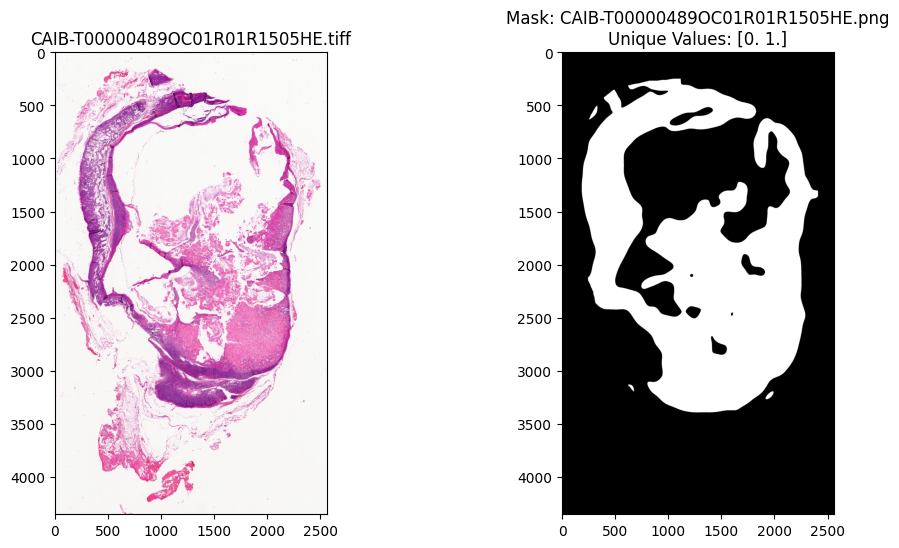

In [7]:
tdata = train_ds.__getitem__(216)
unique_mask_values = np.unique(tdata['mask'])
unique_image_values = np.unique(tdata['image'])

fig, axes = plt.subplots(1, 2, figsize=(12, 6))  

#print(tdata['image'])
#print(tdata['mask'])
print('image_shape',tdata['image'].shape)
print('mask_shape',tdata['mask'].shape)



axes[0].imshow(tdata['image'].permute(1,2,0),cmap = 'RdBu_r',vmin=0,vmax=1)
axes[0].set_title(tdata['image_filename'])

axes[1].imshow(tdata['mask'], cmap='gray', vmin=0, vmax=1)

axes[1].set_title(f"Mask: {tdata['mask_filename']}\nUnique Values: {unique_mask_values}")

plt.show()


In [8]:
#import segmentation_models_pytorch as smp
#import torch
#import torch.nn as nn
#import torch.optim as optim

# Define hyperparameters
learning_rate = 0.001  # Adjust the learning rate as needed
num_epochs = 100
best_val_loss = float('inf')

# Define dataset and data loader (train and validation)
# train_dl = DataLoader(train_ds, batch_size=16, shuffle=True, num_workers=16)
# val_dl = DataLoader(val_ds, batch_size=16, shuffle=False, num_workers=16)

device = 'cuda:0'
# Check if multiple GPUs are available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define model and move it to the device
model = smp.Unet(
    encoder_name="resnet34",
    encoder_weights="imagenet",
    in_channels=3,
    classes=2,
)
model = model.to(device)

# Define a custom loss function that combines Dice Loss, BCE Loss, and Focal Loss
class CombinedLoss(nn.Module):
    def __init__(self, dice_weight=1, bce_weight=1, focal_weight=1):
        super(CombinedLoss, self).__init__()
        self.dice_weight = dice_weight
        self.bce_weight = bce_weight
        self.focal_weight = focal_weight

    def forward(self, outputs, mask):
        # Calculate Dice Loss (imported from SMP)
        dice_loss = smp.losses.DiceLoss(mode='multiclass')(outputs, mask)

        # Calculate BCE Loss
        bce_loss = torch.nn.functional.cross_entropy(outputs, mask)

        # Calculate Focal Loss (imported from SMP)
        focal_loss = smp.losses.FocalLoss(mode='multiclass')(outputs, mask)

        # Combine the three losses
        combined_loss = (
            self.dice_weight * dice_loss +
            self.bce_weight * bce_loss +
            self.focal_weight * focal_loss
        )

        return combined_loss

# Define loss function and optimizer
criterion = CombinedLoss(dice_weight=0.4, bce_weight=0.3, focal_weight=0.3)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
best_epoch = 0
for epoch in range(num_epochs):
    print(f'Epoch {epoch + 1} is running')
    train_loss = 0.0
    model.train()  # Set the model to training mode

    for data in tqdm(train_dl):
        optimizer.zero_grad()
        image = data['image'].to(device)
        # Assuming mask is a single-channel binary mask
        mask = data['mask'].long().to(device)

        # Forward pass
        outputs = model(image)

        # Calculate the loss using the custom criterion
        loss = criterion(outputs, mask)

        # Backpropagation and optimization
        loss.backward()
        optimizer.step()

        # Accumulate the training loss
        train_loss += loss.item()

    # Calculate and print the average training loss for this epoch
    avg_train_loss = train_loss / len(train_dl)
    print(f"Epoch {epoch + 1} - Training Loss: {avg_train_loss:.4f}")

    # Validation loop
    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0

    with torch.no_grad():
        for data in tqdm(val_dl):
            image = data['image'].to(device)
            # Assuming mask is a single-channel binary mask
            mask = data['mask'].long().to(device)

            # Forward pass
            outputs = model(image)

            # Calculate the validation loss using the custom criterion
            loss = criterion(outputs, mask)

            # Accumulate the validation loss
            val_loss += loss.item()

    # Calculate and print the average validation loss for this epoch
    avg_val_loss = val_loss / len(val_dl)
    print(f"Epoch {epoch + 1} - Validation Loss: {avg_val_loss:.4f}")

    # Save the model if it performs better than the previous best on the validation set
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_epoch = epoch
        torch.save(model.state_dict(), 'Unet_combined_loss.pth')
        print(f"Latest saved model: Epoch {epoch + 1} - Validation Loss: {avg_val_loss:.4f}")

print(f"Best Model: Epoch {best_epoch + 1} - Validation Loss: {best_val_loss:.4f}")

# Save the final model
torch.save(model.state_dict(), 'Unet_combined_loss_f.pth')
print('Finished training')


Epoch 1 is running


100%|████████████████████████████████████████████████████| 55/55 [00:37<00:00,  1.46it/s]


Epoch 1 - Training Loss: 0.2719


100%|████████████████████████████████████████████████████| 24/24 [00:05<00:00,  4.23it/s]


Epoch 1 - Validation Loss: 0.2486
Latest saved model: Epoch 1 - Validation Loss: 0.2486
Epoch 2 is running


100%|████████████████████████████████████████████████████| 55/55 [00:37<00:00,  1.47it/s]


Epoch 2 - Training Loss: 0.2026


100%|████████████████████████████████████████████████████| 24/24 [00:05<00:00,  4.26it/s]


Epoch 2 - Validation Loss: 0.1946
Latest saved model: Epoch 2 - Validation Loss: 0.1946
Epoch 3 is running


100%|████████████████████████████████████████████████████| 55/55 [00:37<00:00,  1.49it/s]


Epoch 3 - Training Loss: 0.1827


100%|████████████████████████████████████████████████████| 24/24 [00:05<00:00,  4.21it/s]


Epoch 3 - Validation Loss: 0.1809
Latest saved model: Epoch 3 - Validation Loss: 0.1809
Epoch 4 is running


100%|████████████████████████████████████████████████████| 55/55 [00:37<00:00,  1.47it/s]


Epoch 4 - Training Loss: 0.1792


100%|████████████████████████████████████████████████████| 24/24 [00:05<00:00,  4.32it/s]


Epoch 4 - Validation Loss: 0.1939
Epoch 5 is running


100%|████████████████████████████████████████████████████| 55/55 [00:37<00:00,  1.47it/s]


Epoch 5 - Training Loss: 0.1584


100%|████████████████████████████████████████████████████| 24/24 [00:05<00:00,  4.31it/s]


Epoch 5 - Validation Loss: 0.2046
Epoch 6 is running


100%|████████████████████████████████████████████████████| 55/55 [00:37<00:00,  1.47it/s]


Epoch 6 - Training Loss: 0.1708


100%|████████████████████████████████████████████████████| 24/24 [00:05<00:00,  4.18it/s]


Epoch 6 - Validation Loss: 0.1914
Epoch 7 is running


100%|████████████████████████████████████████████████████| 55/55 [00:37<00:00,  1.48it/s]


Epoch 7 - Training Loss: 0.1616


100%|████████████████████████████████████████████████████| 24/24 [00:05<00:00,  4.36it/s]


Epoch 7 - Validation Loss: 0.1861
Epoch 8 is running


100%|████████████████████████████████████████████████████| 55/55 [00:37<00:00,  1.48it/s]


Epoch 8 - Training Loss: 0.1521


100%|████████████████████████████████████████████████████| 24/24 [00:05<00:00,  4.13it/s]


Epoch 8 - Validation Loss: 0.1543
Latest saved model: Epoch 8 - Validation Loss: 0.1543
Epoch 9 is running


100%|████████████████████████████████████████████████████| 55/55 [00:37<00:00,  1.48it/s]


Epoch 9 - Training Loss: 0.1623


100%|████████████████████████████████████████████████████| 24/24 [00:05<00:00,  4.33it/s]


Epoch 9 - Validation Loss: 0.3862
Epoch 10 is running


100%|████████████████████████████████████████████████████| 55/55 [00:37<00:00,  1.46it/s]


Epoch 10 - Training Loss: 0.1757


100%|████████████████████████████████████████████████████| 24/24 [00:05<00:00,  4.12it/s]


Epoch 10 - Validation Loss: 0.1618
Epoch 11 is running


100%|████████████████████████████████████████████████████| 55/55 [00:37<00:00,  1.47it/s]


Epoch 11 - Training Loss: 0.1516


100%|████████████████████████████████████████████████████| 24/24 [00:05<00:00,  4.20it/s]


Epoch 11 - Validation Loss: 0.1470
Latest saved model: Epoch 11 - Validation Loss: 0.1470
Epoch 12 is running


100%|████████████████████████████████████████████████████| 55/55 [00:37<00:00,  1.47it/s]


Epoch 12 - Training Loss: 0.1451


100%|████████████████████████████████████████████████████| 24/24 [00:05<00:00,  4.14it/s]


Epoch 12 - Validation Loss: 0.1771
Epoch 13 is running


100%|████████████████████████████████████████████████████| 55/55 [00:37<00:00,  1.48it/s]


Epoch 13 - Training Loss: 0.1835


100%|████████████████████████████████████████████████████| 24/24 [00:05<00:00,  4.05it/s]


Epoch 13 - Validation Loss: 0.2004
Epoch 14 is running


100%|████████████████████████████████████████████████████| 55/55 [00:37<00:00,  1.47it/s]


Epoch 14 - Training Loss: 0.1458


100%|████████████████████████████████████████████████████| 24/24 [00:05<00:00,  4.24it/s]


Epoch 14 - Validation Loss: 0.1677
Epoch 15 is running


100%|████████████████████████████████████████████████████| 55/55 [00:37<00:00,  1.47it/s]


Epoch 15 - Training Loss: 0.1461


100%|████████████████████████████████████████████████████| 24/24 [00:05<00:00,  4.24it/s]


Epoch 15 - Validation Loss: 0.1938
Epoch 16 is running


100%|████████████████████████████████████████████████████| 55/55 [00:37<00:00,  1.48it/s]


Epoch 16 - Training Loss: 0.1586


100%|████████████████████████████████████████████████████| 24/24 [00:05<00:00,  4.19it/s]


Epoch 16 - Validation Loss: 0.1404
Latest saved model: Epoch 16 - Validation Loss: 0.1404
Epoch 17 is running


100%|████████████████████████████████████████████████████| 55/55 [00:37<00:00,  1.48it/s]


Epoch 17 - Training Loss: 0.1568


100%|████████████████████████████████████████████████████| 24/24 [00:05<00:00,  4.04it/s]


Epoch 17 - Validation Loss: 0.1847
Epoch 18 is running


100%|████████████████████████████████████████████████████| 55/55 [00:37<00:00,  1.47it/s]


Epoch 18 - Training Loss: 0.1733


100%|████████████████████████████████████████████████████| 24/24 [00:05<00:00,  4.30it/s]


Epoch 18 - Validation Loss: 0.1474
Epoch 19 is running


100%|████████████████████████████████████████████████████| 55/55 [00:37<00:00,  1.49it/s]


Epoch 19 - Training Loss: 0.1607


100%|████████████████████████████████████████████████████| 24/24 [00:05<00:00,  4.02it/s]


Epoch 19 - Validation Loss: 0.1410
Epoch 20 is running


100%|████████████████████████████████████████████████████| 55/55 [00:37<00:00,  1.47it/s]


Epoch 20 - Training Loss: 0.1548


100%|████████████████████████████████████████████████████| 24/24 [00:05<00:00,  4.27it/s]


Epoch 20 - Validation Loss: 0.2085
Epoch 21 is running


100%|████████████████████████████████████████████████████| 55/55 [00:37<00:00,  1.47it/s]


Epoch 21 - Training Loss: 0.1663


100%|████████████████████████████████████████████████████| 24/24 [00:05<00:00,  4.33it/s]


Epoch 21 - Validation Loss: 0.1643
Epoch 22 is running


100%|████████████████████████████████████████████████████| 55/55 [00:37<00:00,  1.48it/s]


Epoch 22 - Training Loss: 0.1399


100%|████████████████████████████████████████████████████| 24/24 [00:05<00:00,  4.13it/s]


Epoch 22 - Validation Loss: 0.1786
Epoch 23 is running


100%|████████████████████████████████████████████████████| 55/55 [00:37<00:00,  1.48it/s]


Epoch 23 - Training Loss: 0.1841


100%|████████████████████████████████████████████████████| 24/24 [00:05<00:00,  4.29it/s]


Epoch 23 - Validation Loss: 0.2646
Epoch 24 is running


100%|████████████████████████████████████████████████████| 55/55 [00:37<00:00,  1.47it/s]


Epoch 24 - Training Loss: 0.1661


100%|████████████████████████████████████████████████████| 24/24 [00:05<00:00,  4.28it/s]


Epoch 24 - Validation Loss: 0.2158
Epoch 25 is running


100%|████████████████████████████████████████████████████| 55/55 [00:37<00:00,  1.48it/s]


Epoch 25 - Training Loss: 0.1769


100%|████████████████████████████████████████████████████| 24/24 [00:05<00:00,  4.18it/s]


Epoch 25 - Validation Loss: 0.1498
Epoch 26 is running


100%|████████████████████████████████████████████████████| 55/55 [00:37<00:00,  1.47it/s]


Epoch 26 - Training Loss: 0.1819


100%|████████████████████████████████████████████████████| 24/24 [00:05<00:00,  4.16it/s]


Epoch 26 - Validation Loss: 0.1621
Epoch 27 is running


100%|████████████████████████████████████████████████████| 55/55 [00:37<00:00,  1.46it/s]


Epoch 27 - Training Loss: 0.1454


100%|████████████████████████████████████████████████████| 24/24 [00:05<00:00,  4.18it/s]


Epoch 27 - Validation Loss: 0.1604
Epoch 28 is running


100%|████████████████████████████████████████████████████| 55/55 [00:37<00:00,  1.47it/s]


Epoch 28 - Training Loss: 0.1488


100%|████████████████████████████████████████████████████| 24/24 [00:05<00:00,  4.31it/s]


Epoch 28 - Validation Loss: 0.1647
Epoch 29 is running


100%|████████████████████████████████████████████████████| 55/55 [00:37<00:00,  1.48it/s]


Epoch 29 - Training Loss: 0.1489


100%|████████████████████████████████████████████████████| 24/24 [00:05<00:00,  4.07it/s]


Epoch 29 - Validation Loss: 0.2704
Epoch 30 is running


100%|████████████████████████████████████████████████████| 55/55 [00:37<00:00,  1.47it/s]


Epoch 30 - Training Loss: 0.1551


100%|████████████████████████████████████████████████████| 24/24 [00:05<00:00,  4.18it/s]


Epoch 30 - Validation Loss: 0.1434
Epoch 31 is running


100%|████████████████████████████████████████████████████| 55/55 [00:37<00:00,  1.47it/s]


Epoch 31 - Training Loss: 0.1749


100%|████████████████████████████████████████████████████| 24/24 [00:05<00:00,  4.25it/s]


Epoch 31 - Validation Loss: 0.1495
Epoch 32 is running


100%|████████████████████████████████████████████████████| 55/55 [00:37<00:00,  1.47it/s]


Epoch 32 - Training Loss: 0.1473


100%|████████████████████████████████████████████████████| 24/24 [00:05<00:00,  4.18it/s]


Epoch 32 - Validation Loss: 0.1375
Latest saved model: Epoch 32 - Validation Loss: 0.1375
Epoch 33 is running


100%|████████████████████████████████████████████████████| 55/55 [00:37<00:00,  1.47it/s]


Epoch 33 - Training Loss: 0.1544


100%|████████████████████████████████████████████████████| 24/24 [00:05<00:00,  4.24it/s]


Epoch 33 - Validation Loss: 0.1634
Epoch 34 is running


100%|████████████████████████████████████████████████████| 55/55 [00:37<00:00,  1.47it/s]


Epoch 34 - Training Loss: 0.1389


100%|████████████████████████████████████████████████████| 24/24 [00:05<00:00,  4.18it/s]


Epoch 34 - Validation Loss: 0.1642
Epoch 35 is running


100%|████████████████████████████████████████████████████| 55/55 [00:37<00:00,  1.47it/s]


Epoch 35 - Training Loss: 0.1455


100%|████████████████████████████████████████████████████| 24/24 [00:05<00:00,  4.27it/s]


Epoch 35 - Validation Loss: 0.2025
Epoch 36 is running


100%|████████████████████████████████████████████████████| 55/55 [00:37<00:00,  1.48it/s]


Epoch 36 - Training Loss: 0.1654


100%|████████████████████████████████████████████████████| 24/24 [00:05<00:00,  4.24it/s]


Epoch 36 - Validation Loss: 0.1129
Latest saved model: Epoch 36 - Validation Loss: 0.1129
Epoch 37 is running


100%|████████████████████████████████████████████████████| 55/55 [00:37<00:00,  1.47it/s]


Epoch 37 - Training Loss: 0.1451


100%|████████████████████████████████████████████████████| 24/24 [00:05<00:00,  4.09it/s]


Epoch 37 - Validation Loss: 0.1420
Epoch 38 is running


100%|████████████████████████████████████████████████████| 55/55 [00:37<00:00,  1.47it/s]


Epoch 38 - Training Loss: 0.1588


100%|████████████████████████████████████████████████████| 24/24 [00:05<00:00,  4.33it/s]


Epoch 38 - Validation Loss: 0.1498
Epoch 39 is running


100%|████████████████████████████████████████████████████| 55/55 [00:37<00:00,  1.47it/s]


Epoch 39 - Training Loss: 0.1518


100%|████████████████████████████████████████████████████| 24/24 [00:05<00:00,  4.22it/s]


Epoch 39 - Validation Loss: 0.1250
Epoch 40 is running


100%|████████████████████████████████████████████████████| 55/55 [00:37<00:00,  1.47it/s]


Epoch 40 - Training Loss: 0.1206


100%|████████████████████████████████████████████████████| 24/24 [00:05<00:00,  4.20it/s]


Epoch 40 - Validation Loss: 0.1373
Epoch 41 is running


100%|████████████████████████████████████████████████████| 55/55 [00:37<00:00,  1.48it/s]


Epoch 41 - Training Loss: 0.1426


100%|████████████████████████████████████████████████████| 24/24 [00:05<00:00,  4.16it/s]


Epoch 41 - Validation Loss: 0.1617
Epoch 42 is running


100%|████████████████████████████████████████████████████| 55/55 [00:37<00:00,  1.47it/s]


Epoch 42 - Training Loss: 0.1434


100%|████████████████████████████████████████████████████| 24/24 [00:05<00:00,  4.25it/s]


Epoch 42 - Validation Loss: 0.1654
Epoch 43 is running


100%|████████████████████████████████████████████████████| 55/55 [00:37<00:00,  1.47it/s]


Epoch 43 - Training Loss: 0.1430


100%|████████████████████████████████████████████████████| 24/24 [00:06<00:00,  3.97it/s]


Epoch 43 - Validation Loss: 0.1755
Epoch 44 is running


100%|████████████████████████████████████████████████████| 55/55 [00:37<00:00,  1.47it/s]


Epoch 44 - Training Loss: 0.1323


100%|████████████████████████████████████████████████████| 24/24 [00:06<00:00,  3.98it/s]


Epoch 44 - Validation Loss: 0.1427
Epoch 45 is running


100%|████████████████████████████████████████████████████| 55/55 [00:37<00:00,  1.47it/s]


Epoch 45 - Training Loss: 0.1400


100%|████████████████████████████████████████████████████| 24/24 [00:05<00:00,  4.20it/s]


Epoch 45 - Validation Loss: 0.1687
Epoch 46 is running


100%|████████████████████████████████████████████████████| 55/55 [00:37<00:00,  1.47it/s]


Epoch 46 - Training Loss: 0.1270


100%|████████████████████████████████████████████████████| 24/24 [00:05<00:00,  4.22it/s]


Epoch 46 - Validation Loss: 0.1301
Epoch 47 is running


100%|████████████████████████████████████████████████████| 55/55 [00:37<00:00,  1.47it/s]


Epoch 47 - Training Loss: 0.1469


100%|████████████████████████████████████████████████████| 24/24 [00:05<00:00,  4.14it/s]


Epoch 47 - Validation Loss: 0.1732
Epoch 48 is running


100%|████████████████████████████████████████████████████| 55/55 [00:37<00:00,  1.47it/s]


Epoch 48 - Training Loss: 0.1277


100%|████████████████████████████████████████████████████| 24/24 [00:05<00:00,  4.24it/s]


Epoch 48 - Validation Loss: 0.8067
Epoch 49 is running


100%|████████████████████████████████████████████████████| 55/55 [00:37<00:00,  1.48it/s]


Epoch 49 - Training Loss: 0.1180


100%|████████████████████████████████████████████████████| 24/24 [00:05<00:00,  4.22it/s]


Epoch 49 - Validation Loss: 0.4106
Epoch 50 is running


100%|████████████████████████████████████████████████████| 55/55 [00:37<00:00,  1.47it/s]


Epoch 50 - Training Loss: 0.1486


100%|████████████████████████████████████████████████████| 24/24 [00:05<00:00,  4.23it/s]


Epoch 50 - Validation Loss: 0.1522
Best Model: Epoch 36 - Validation Loss: 0.1129
Finished training


In [8]:
#import segmentation_models_pytorch as smp
#import torch
#import torch.nn as nn
#import torch.optim as optim

# Define hyperparameters
learning_rate = 0.001  # Adjust the learning rate as needed
num_epochs = 100
best_val_loss = float('inf')

# Define dataset and data loader (train and validation)
# train_dl = DataLoader(train_ds, batch_size=16, shuffle=True, num_workers=16)
# val_dl = DataLoader(val_ds, batch_size=16, shuffle=False, num_workers=16)

device = 'cuda:0'
# Check if multiple GPUs are available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define model and move it to the device
model = smp.UnetPlusPlus(
    encoder_name="resnet34",
    encoder_weights="imagenet",
    in_channels=3,
    classes=2,
)
model = model.to(device)

# Define a custom loss function that combines Dice Loss, BCE Loss, and Focal Loss
class CombinedLoss(nn.Module):
    def __init__(self, dice_weight=1, bce_weight=1, focal_weight=1):
        super(CombinedLoss, self).__init__()
        self.dice_weight = dice_weight
        self.bce_weight = bce_weight
        self.focal_weight = focal_weight

    def forward(self, outputs, mask):
        # Calculate Dice Loss (imported from SMP)
        dice_loss = smp.losses.DiceLoss(mode='multiclass')(outputs, mask)

        # Calculate BCE Loss
        bce_loss = torch.nn.functional.cross_entropy(outputs, mask)

        # Calculate Focal Loss (imported from SMP)
        focal_loss = smp.losses.FocalLoss(mode='multiclass')(outputs, mask)

        # Combine the three losses
        combined_loss = (
            self.dice_weight * dice_loss +
            self.bce_weight * bce_loss +
            self.focal_weight * focal_loss
        )

        return combined_loss

# Define loss function and optimizer
criterion = CombinedLoss(dice_weight=0.4, bce_weight=0.3, focal_weight=0.3)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
best_epoch = 0
for epoch in range(num_epochs):
    print(f'Epoch {epoch + 1} is running')
    train_loss = 0.0
    model.train()  # Set the model to training mode

    for data in tqdm(train_dl):
        optimizer.zero_grad()
        image = data['image'].to(device)
        # Assuming mask is a single-channel binary mask
        mask = data['mask'].long().to(device)

        # Forward pass
        outputs = model(image)

        # Calculate the loss using the custom criterion
        loss = criterion(outputs, mask)

        # Backpropagation and optimization
        loss.backward()
        optimizer.step()

        # Accumulate the training loss
        train_loss += loss.item()

    # Calculate and print the average training loss for this epoch
    avg_train_loss = train_loss / len(train_dl)
    print(f"Epoch {epoch + 1} - Training Loss: {avg_train_loss:.4f}")

    # Validation loop
    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0

    with torch.no_grad():
        for data in tqdm(val_dl):
            image = data['image'].to(device)
            # Assuming mask is a single-channel binary mask
            mask = data['mask'].long().to(device)

            # Forward pass
            outputs = model(image)

            # Calculate the validation loss using the custom criterion
            loss = criterion(outputs, mask)

            # Accumulate the validation loss
            val_loss += loss.item()

    # Calculate and print the average validation loss for this epoch
    avg_val_loss = val_loss / len(val_dl)
    print(f"Epoch {epoch + 1} - Validation Loss: {avg_val_loss:.4f}")

    # Save the model if it performs better than the previous best on the validation set
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_epoch = epoch
        torch.save(model.state_dict(), 'Unetplus_combined_loss.pth')
        print(f"Latest saved model: Epoch {epoch + 1} - Validation Loss: {avg_val_loss:.4f}")

print(f"Best Model: Epoch {best_epoch + 1} - Validation Loss: {best_val_loss:.4f}")

# Save the final model
torch.save(model.state_dict(), 'Unetplus_combined_loss_f.pth')
print('Finished training')


Epoch 1 is running


100%|██████████████████████████████████████████████████| 217/217 [02:17<00:00,  1.57it/s]


Epoch 1 - Training Loss: 0.1966


100%|████████████████████████████████████████████████████| 94/94 [00:21<00:00,  4.43it/s]


Epoch 1 - Validation Loss: 0.1965
Latest saved model: Epoch 1 - Validation Loss: 0.1965
Epoch 2 is running


100%|██████████████████████████████████████████████████| 217/217 [02:14<00:00,  1.61it/s]


Epoch 2 - Training Loss: 0.1679


100%|████████████████████████████████████████████████████| 94/94 [00:20<00:00,  4.54it/s]


Epoch 2 - Validation Loss: 0.1560
Latest saved model: Epoch 2 - Validation Loss: 0.1560
Epoch 3 is running


100%|██████████████████████████████████████████████████| 217/217 [02:14<00:00,  1.62it/s]


Epoch 3 - Training Loss: 0.1529


100%|████████████████████████████████████████████████████| 94/94 [00:20<00:00,  4.62it/s]


Epoch 3 - Validation Loss: 0.1814
Epoch 4 is running


100%|██████████████████████████████████████████████████| 217/217 [02:14<00:00,  1.62it/s]


Epoch 4 - Training Loss: 0.1372


100%|████████████████████████████████████████████████████| 94/94 [00:20<00:00,  4.53it/s]


Epoch 4 - Validation Loss: 0.1590
Epoch 5 is running


100%|██████████████████████████████████████████████████| 217/217 [02:15<00:00,  1.61it/s]


Epoch 5 - Training Loss: 0.1373


100%|████████████████████████████████████████████████████| 94/94 [00:20<00:00,  4.58it/s]


Epoch 5 - Validation Loss: 0.1827
Epoch 6 is running


100%|██████████████████████████████████████████████████| 217/217 [02:14<00:00,  1.61it/s]


Epoch 6 - Training Loss: 0.1271


100%|████████████████████████████████████████████████████| 94/94 [00:20<00:00,  4.58it/s]


Epoch 6 - Validation Loss: 0.1768
Epoch 7 is running


100%|██████████████████████████████████████████████████| 217/217 [02:14<00:00,  1.61it/s]


Epoch 7 - Training Loss: 0.1269


100%|████████████████████████████████████████████████████| 94/94 [00:20<00:00,  4.59it/s]


Epoch 7 - Validation Loss: 0.1832
Epoch 8 is running


100%|██████████████████████████████████████████████████| 217/217 [02:14<00:00,  1.61it/s]


Epoch 8 - Training Loss: 0.1254


100%|████████████████████████████████████████████████████| 94/94 [00:20<00:00,  4.57it/s]


Epoch 8 - Validation Loss: 0.1536
Latest saved model: Epoch 8 - Validation Loss: 0.1536
Epoch 9 is running


100%|██████████████████████████████████████████████████| 217/217 [02:14<00:00,  1.61it/s]


Epoch 9 - Training Loss: 0.1114


100%|████████████████████████████████████████████████████| 94/94 [00:20<00:00,  4.59it/s]


Epoch 9 - Validation Loss: 0.1987
Epoch 10 is running


100%|██████████████████████████████████████████████████| 217/217 [02:14<00:00,  1.61it/s]


Epoch 10 - Training Loss: 0.1070


100%|████████████████████████████████████████████████████| 94/94 [00:20<00:00,  4.52it/s]


Epoch 10 - Validation Loss: 0.2130
Epoch 11 is running


100%|██████████████████████████████████████████████████| 217/217 [02:15<00:00,  1.60it/s]


Epoch 11 - Training Loss: 0.1164


100%|████████████████████████████████████████████████████| 94/94 [00:20<00:00,  4.51it/s]


Epoch 11 - Validation Loss: 0.2115
Epoch 12 is running


100%|██████████████████████████████████████████████████| 217/217 [02:15<00:00,  1.60it/s]


Epoch 12 - Training Loss: 0.1228


100%|████████████████████████████████████████████████████| 94/94 [00:20<00:00,  4.54it/s]


Epoch 12 - Validation Loss: 0.1704
Epoch 13 is running


100%|██████████████████████████████████████████████████| 217/217 [02:15<00:00,  1.61it/s]


Epoch 13 - Training Loss: 0.1203


100%|████████████████████████████████████████████████████| 94/94 [00:20<00:00,  4.49it/s]


Epoch 13 - Validation Loss: 0.2174
Epoch 14 is running


100%|██████████████████████████████████████████████████| 217/217 [02:15<00:00,  1.60it/s]


Epoch 14 - Training Loss: 0.1097


100%|████████████████████████████████████████████████████| 94/94 [00:21<00:00,  4.46it/s]


Epoch 14 - Validation Loss: 0.1896
Epoch 15 is running


100%|██████████████████████████████████████████████████| 217/217 [02:15<00:00,  1.61it/s]


Epoch 15 - Training Loss: 0.1010


100%|████████████████████████████████████████████████████| 94/94 [00:20<00:00,  4.48it/s]


Epoch 15 - Validation Loss: 0.1550
Epoch 16 is running


100%|██████████████████████████████████████████████████| 217/217 [02:14<00:00,  1.61it/s]


Epoch 16 - Training Loss: 0.1013


100%|████████████████████████████████████████████████████| 94/94 [00:20<00:00,  4.56it/s]


Epoch 16 - Validation Loss: 0.1945
Epoch 17 is running


100%|██████████████████████████████████████████████████| 217/217 [02:15<00:00,  1.61it/s]


Epoch 17 - Training Loss: 0.1077


100%|████████████████████████████████████████████████████| 94/94 [00:20<00:00,  4.51it/s]


Epoch 17 - Validation Loss: 0.1448
Latest saved model: Epoch 17 - Validation Loss: 0.1448
Epoch 18 is running


100%|██████████████████████████████████████████████████| 217/217 [02:15<00:00,  1.60it/s]


Epoch 18 - Training Loss: 0.1003


100%|████████████████████████████████████████████████████| 94/94 [00:20<00:00,  4.49it/s]


Epoch 18 - Validation Loss: 0.1616
Epoch 19 is running


100%|██████████████████████████████████████████████████| 217/217 [02:15<00:00,  1.61it/s]


Epoch 19 - Training Loss: 0.1019


100%|████████████████████████████████████████████████████| 94/94 [00:21<00:00,  4.42it/s]


Epoch 19 - Validation Loss: 0.1505
Epoch 20 is running


100%|██████████████████████████████████████████████████| 217/217 [02:15<00:00,  1.60it/s]


Epoch 20 - Training Loss: 0.0973


100%|████████████████████████████████████████████████████| 94/94 [00:20<00:00,  4.49it/s]


Epoch 20 - Validation Loss: 0.2190
Epoch 21 is running


100%|██████████████████████████████████████████████████| 217/217 [02:14<00:00,  1.61it/s]


Epoch 21 - Training Loss: 0.0969


100%|████████████████████████████████████████████████████| 94/94 [00:20<00:00,  4.52it/s]


Epoch 21 - Validation Loss: 0.1561
Epoch 22 is running


100%|██████████████████████████████████████████████████| 217/217 [02:15<00:00,  1.60it/s]


Epoch 22 - Training Loss: 0.0941


100%|████████████████████████████████████████████████████| 94/94 [00:20<00:00,  4.54it/s]


Epoch 22 - Validation Loss: 0.1815
Epoch 23 is running


100%|██████████████████████████████████████████████████| 217/217 [02:15<00:00,  1.60it/s]


Epoch 23 - Training Loss: 0.1022


100%|████████████████████████████████████████████████████| 94/94 [00:21<00:00,  4.48it/s]


Epoch 23 - Validation Loss: 0.1743
Epoch 24 is running


100%|██████████████████████████████████████████████████| 217/217 [02:15<00:00,  1.60it/s]


Epoch 24 - Training Loss: 0.0909


100%|████████████████████████████████████████████████████| 94/94 [00:20<00:00,  4.51it/s]


Epoch 24 - Validation Loss: 0.1552
Epoch 25 is running


100%|██████████████████████████████████████████████████| 217/217 [02:15<00:00,  1.60it/s]


Epoch 25 - Training Loss: 0.0969


100%|████████████████████████████████████████████████████| 94/94 [00:20<00:00,  4.55it/s]


Epoch 25 - Validation Loss: 0.1704
Epoch 26 is running


100%|██████████████████████████████████████████████████| 217/217 [02:15<00:00,  1.60it/s]


Epoch 26 - Training Loss: 0.0877


100%|████████████████████████████████████████████████████| 94/94 [00:20<00:00,  4.50it/s]


Epoch 26 - Validation Loss: 0.1431
Latest saved model: Epoch 26 - Validation Loss: 0.1431
Epoch 27 is running


100%|██████████████████████████████████████████████████| 217/217 [02:14<00:00,  1.61it/s]


Epoch 27 - Training Loss: 0.0924


100%|████████████████████████████████████████████████████| 94/94 [00:20<00:00,  4.51it/s]


Epoch 27 - Validation Loss: 0.1659
Epoch 28 is running


100%|██████████████████████████████████████████████████| 217/217 [02:15<00:00,  1.61it/s]


Epoch 28 - Training Loss: 0.0890


100%|████████████████████████████████████████████████████| 94/94 [00:20<00:00,  4.55it/s]


Epoch 28 - Validation Loss: 0.1641
Epoch 29 is running


100%|██████████████████████████████████████████████████| 217/217 [02:15<00:00,  1.60it/s]


Epoch 29 - Training Loss: 0.0887


100%|████████████████████████████████████████████████████| 94/94 [00:20<00:00,  4.49it/s]


Epoch 29 - Validation Loss: 0.1640
Epoch 30 is running


100%|██████████████████████████████████████████████████| 217/217 [02:15<00:00,  1.60it/s]


Epoch 30 - Training Loss: 0.0859


100%|████████████████████████████████████████████████████| 94/94 [00:21<00:00,  4.43it/s]


Epoch 30 - Validation Loss: 0.1553
Epoch 31 is running


100%|██████████████████████████████████████████████████| 217/217 [02:15<00:00,  1.60it/s]


Epoch 31 - Training Loss: 0.0973


100%|████████████████████████████████████████████████████| 94/94 [00:20<00:00,  4.48it/s]


Epoch 31 - Validation Loss: 0.1520
Epoch 32 is running


100%|██████████████████████████████████████████████████| 217/217 [02:15<00:00,  1.60it/s]


Epoch 32 - Training Loss: 0.0942


100%|████████████████████████████████████████████████████| 94/94 [00:20<00:00,  4.49it/s]


Epoch 32 - Validation Loss: 0.1659
Epoch 33 is running


100%|██████████████████████████████████████████████████| 217/217 [02:15<00:00,  1.60it/s]


Epoch 33 - Training Loss: 0.0901


100%|████████████████████████████████████████████████████| 94/94 [00:20<00:00,  4.52it/s]


Epoch 33 - Validation Loss: 0.1619
Epoch 34 is running


100%|██████████████████████████████████████████████████| 217/217 [02:15<00:00,  1.61it/s]


Epoch 34 - Training Loss: 0.0836


100%|████████████████████████████████████████████████████| 94/94 [00:20<00:00,  4.49it/s]


Epoch 34 - Validation Loss: 0.1572
Epoch 35 is running


100%|██████████████████████████████████████████████████| 217/217 [02:15<00:00,  1.61it/s]


Epoch 35 - Training Loss: 0.0877


100%|████████████████████████████████████████████████████| 94/94 [00:21<00:00,  4.43it/s]


Epoch 35 - Validation Loss: 0.1637
Epoch 36 is running


100%|██████████████████████████████████████████████████| 217/217 [02:15<00:00,  1.60it/s]


Epoch 36 - Training Loss: 0.0801


100%|████████████████████████████████████████████████████| 94/94 [00:20<00:00,  4.52it/s]


Epoch 36 - Validation Loss: 0.1626
Epoch 37 is running


100%|██████████████████████████████████████████████████| 217/217 [02:15<00:00,  1.60it/s]


Epoch 37 - Training Loss: 0.0827


100%|████████████████████████████████████████████████████| 94/94 [00:20<00:00,  4.51it/s]


Epoch 37 - Validation Loss: 0.1554
Epoch 38 is running


100%|██████████████████████████████████████████████████| 217/217 [02:15<00:00,  1.60it/s]


Epoch 38 - Training Loss: 0.0860


100%|████████████████████████████████████████████████████| 94/94 [00:20<00:00,  4.48it/s]


Epoch 38 - Validation Loss: 0.1926
Epoch 39 is running


100%|██████████████████████████████████████████████████| 217/217 [02:15<00:00,  1.60it/s]


Epoch 39 - Training Loss: 0.0866


100%|████████████████████████████████████████████████████| 94/94 [00:20<00:00,  4.51it/s]


Epoch 39 - Validation Loss: 0.1833
Epoch 40 is running


100%|██████████████████████████████████████████████████| 217/217 [02:15<00:00,  1.60it/s]


Epoch 40 - Training Loss: 0.0829


100%|████████████████████████████████████████████████████| 94/94 [00:21<00:00,  4.47it/s]


Epoch 40 - Validation Loss: 0.1760
Epoch 41 is running


100%|██████████████████████████████████████████████████| 217/217 [02:15<00:00,  1.60it/s]


Epoch 41 - Training Loss: 0.0764


100%|████████████████████████████████████████████████████| 94/94 [00:20<00:00,  4.52it/s]


Epoch 41 - Validation Loss: 0.1482
Epoch 42 is running


100%|██████████████████████████████████████████████████| 217/217 [02:15<00:00,  1.61it/s]


Epoch 42 - Training Loss: 0.0911


100%|████████████████████████████████████████████████████| 94/94 [00:20<00:00,  4.52it/s]


Epoch 42 - Validation Loss: 0.1567
Epoch 43 is running


100%|██████████████████████████████████████████████████| 217/217 [02:15<00:00,  1.60it/s]


Epoch 43 - Training Loss: 0.0804


100%|████████████████████████████████████████████████████| 94/94 [00:20<00:00,  4.50it/s]


Epoch 43 - Validation Loss: 0.1525
Epoch 44 is running


100%|██████████████████████████████████████████████████| 217/217 [02:15<00:00,  1.60it/s]


Epoch 44 - Training Loss: 0.0731


100%|████████████████████████████████████████████████████| 94/94 [00:20<00:00,  4.51it/s]


Epoch 44 - Validation Loss: 0.2071
Epoch 45 is running


100%|██████████████████████████████████████████████████| 217/217 [02:14<00:00,  1.61it/s]


Epoch 45 - Training Loss: 0.0769


100%|████████████████████████████████████████████████████| 94/94 [00:20<00:00,  4.53it/s]


Epoch 45 - Validation Loss: 0.1764
Epoch 46 is running


100%|██████████████████████████████████████████████████| 217/217 [02:14<00:00,  1.61it/s]


Epoch 46 - Training Loss: 0.0956


100%|████████████████████████████████████████████████████| 94/94 [00:20<00:00,  4.52it/s]


Epoch 46 - Validation Loss: 0.1723
Epoch 47 is running


100%|██████████████████████████████████████████████████| 217/217 [02:15<00:00,  1.61it/s]


Epoch 47 - Training Loss: 0.0800


100%|████████████████████████████████████████████████████| 94/94 [00:20<00:00,  4.53it/s]


Epoch 47 - Validation Loss: 0.1976
Epoch 48 is running


100%|██████████████████████████████████████████████████| 217/217 [02:15<00:00,  1.60it/s]


Epoch 48 - Training Loss: 0.0786


100%|████████████████████████████████████████████████████| 94/94 [00:20<00:00,  4.54it/s]


Epoch 48 - Validation Loss: 0.1595
Epoch 49 is running


100%|██████████████████████████████████████████████████| 217/217 [02:14<00:00,  1.61it/s]


Epoch 49 - Training Loss: 0.0725


100%|████████████████████████████████████████████████████| 94/94 [00:21<00:00,  4.46it/s]


Epoch 49 - Validation Loss: 0.1809
Epoch 50 is running


100%|██████████████████████████████████████████████████| 217/217 [02:14<00:00,  1.61it/s]


Epoch 50 - Training Loss: 0.0852


100%|████████████████████████████████████████████████████| 94/94 [00:20<00:00,  4.56it/s]


Epoch 50 - Validation Loss: 0.1400
Latest saved model: Epoch 50 - Validation Loss: 0.1400
Epoch 51 is running


100%|██████████████████████████████████████████████████| 217/217 [02:15<00:00,  1.60it/s]


Epoch 51 - Training Loss: 0.0813


100%|████████████████████████████████████████████████████| 94/94 [00:20<00:00,  4.52it/s]


Epoch 51 - Validation Loss: 0.1455
Epoch 52 is running


100%|██████████████████████████████████████████████████| 217/217 [02:15<00:00,  1.60it/s]


Epoch 52 - Training Loss: 0.0726


100%|████████████████████████████████████████████████████| 94/94 [00:21<00:00,  4.45it/s]


Epoch 52 - Validation Loss: 0.1550
Epoch 53 is running


100%|██████████████████████████████████████████████████| 217/217 [02:15<00:00,  1.60it/s]


Epoch 53 - Training Loss: 0.0661


100%|████████████████████████████████████████████████████| 94/94 [00:20<00:00,  4.48it/s]


Epoch 53 - Validation Loss: 0.1435
Epoch 54 is running


100%|██████████████████████████████████████████████████| 217/217 [02:15<00:00,  1.60it/s]


Epoch 54 - Training Loss: 0.0770


100%|████████████████████████████████████████████████████| 94/94 [00:20<00:00,  4.48it/s]


Epoch 54 - Validation Loss: 0.1720
Epoch 55 is running


100%|██████████████████████████████████████████████████| 217/217 [02:15<00:00,  1.60it/s]


Epoch 55 - Training Loss: 0.0971


100%|████████████████████████████████████████████████████| 94/94 [00:20<00:00,  4.52it/s]


Epoch 55 - Validation Loss: 0.1963
Epoch 56 is running


100%|██████████████████████████████████████████████████| 217/217 [02:15<00:00,  1.60it/s]


Epoch 56 - Training Loss: 0.0755


100%|████████████████████████████████████████████████████| 94/94 [00:21<00:00,  4.46it/s]


Epoch 56 - Validation Loss: 0.2120
Epoch 57 is running


100%|██████████████████████████████████████████████████| 217/217 [02:15<00:00,  1.60it/s]


Epoch 57 - Training Loss: 0.0809


100%|████████████████████████████████████████████████████| 94/94 [00:20<00:00,  4.48it/s]


Epoch 57 - Validation Loss: 0.2113
Epoch 58 is running


100%|██████████████████████████████████████████████████| 217/217 [02:15<00:00,  1.61it/s]


Epoch 58 - Training Loss: 0.0730


100%|████████████████████████████████████████████████████| 94/94 [00:20<00:00,  4.56it/s]


Epoch 58 - Validation Loss: 0.1463
Epoch 59 is running


100%|██████████████████████████████████████████████████| 217/217 [02:15<00:00,  1.60it/s]


Epoch 59 - Training Loss: 0.0748


100%|████████████████████████████████████████████████████| 94/94 [00:20<00:00,  4.50it/s]


Epoch 59 - Validation Loss: 0.1828
Epoch 60 is running


100%|██████████████████████████████████████████████████| 217/217 [02:15<00:00,  1.61it/s]


Epoch 60 - Training Loss: 0.0628


100%|████████████████████████████████████████████████████| 94/94 [00:20<00:00,  4.49it/s]


Epoch 60 - Validation Loss: 0.1532
Epoch 61 is running


100%|██████████████████████████████████████████████████| 217/217 [02:15<00:00,  1.61it/s]


Epoch 61 - Training Loss: 0.0633


100%|████████████████████████████████████████████████████| 94/94 [00:20<00:00,  4.48it/s]


Epoch 61 - Validation Loss: 0.1753
Epoch 62 is running


100%|██████████████████████████████████████████████████| 217/217 [02:15<00:00,  1.60it/s]


Epoch 62 - Training Loss: 0.0634


100%|████████████████████████████████████████████████████| 94/94 [00:20<00:00,  4.51it/s]


Epoch 62 - Validation Loss: 0.1486
Epoch 63 is running


100%|██████████████████████████████████████████████████| 217/217 [02:15<00:00,  1.60it/s]


Epoch 63 - Training Loss: 0.0576


100%|████████████████████████████████████████████████████| 94/94 [00:20<00:00,  4.54it/s]


Epoch 63 - Validation Loss: 0.1434
Epoch 64 is running


100%|██████████████████████████████████████████████████| 217/217 [02:15<00:00,  1.60it/s]


Epoch 64 - Training Loss: 0.0773


100%|████████████████████████████████████████████████████| 94/94 [00:20<00:00,  4.50it/s]


Epoch 64 - Validation Loss: 0.1540
Epoch 65 is running


100%|██████████████████████████████████████████████████| 217/217 [02:15<00:00,  1.60it/s]


Epoch 65 - Training Loss: 0.0615


100%|████████████████████████████████████████████████████| 94/94 [00:21<00:00,  4.47it/s]


Epoch 65 - Validation Loss: 0.1654
Epoch 66 is running


100%|██████████████████████████████████████████████████| 217/217 [02:15<00:00,  1.60it/s]


Epoch 66 - Training Loss: 0.0644


100%|████████████████████████████████████████████████████| 94/94 [00:20<00:00,  4.48it/s]


Epoch 66 - Validation Loss: 0.2062
Epoch 67 is running


100%|██████████████████████████████████████████████████| 217/217 [02:15<00:00,  1.60it/s]


Epoch 67 - Training Loss: 0.0526


100%|████████████████████████████████████████████████████| 94/94 [00:20<00:00,  4.51it/s]


Epoch 67 - Validation Loss: 0.1580
Epoch 68 is running


100%|██████████████████████████████████████████████████| 217/217 [02:15<00:00,  1.60it/s]


Epoch 68 - Training Loss: 0.0699


100%|████████████████████████████████████████████████████| 94/94 [00:20<00:00,  4.48it/s]


Epoch 68 - Validation Loss: 0.1496
Epoch 69 is running


100%|██████████████████████████████████████████████████| 217/217 [02:15<00:00,  1.60it/s]


Epoch 69 - Training Loss: 0.1024


100%|████████████████████████████████████████████████████| 94/94 [00:21<00:00,  4.43it/s]


Epoch 69 - Validation Loss: 0.1493
Epoch 70 is running


100%|██████████████████████████████████████████████████| 217/217 [02:15<00:00,  1.60it/s]


Epoch 70 - Training Loss: 0.0600


100%|████████████████████████████████████████████████████| 94/94 [00:21<00:00,  4.46it/s]


Epoch 70 - Validation Loss: 0.1896
Epoch 71 is running


100%|██████████████████████████████████████████████████| 217/217 [02:15<00:00,  1.60it/s]


Epoch 71 - Training Loss: 0.0690


100%|████████████████████████████████████████████████████| 94/94 [00:21<00:00,  4.46it/s]


Epoch 71 - Validation Loss: 0.1758
Epoch 72 is running


100%|██████████████████████████████████████████████████| 217/217 [02:15<00:00,  1.60it/s]


Epoch 72 - Training Loss: 0.0591


100%|████████████████████████████████████████████████████| 94/94 [00:20<00:00,  4.49it/s]


Epoch 72 - Validation Loss: 0.1858
Epoch 73 is running


100%|██████████████████████████████████████████████████| 217/217 [02:15<00:00,  1.60it/s]


Epoch 73 - Training Loss: 0.0600


100%|████████████████████████████████████████████████████| 94/94 [00:20<00:00,  4.54it/s]


Epoch 73 - Validation Loss: 0.1379
Latest saved model: Epoch 73 - Validation Loss: 0.1379
Epoch 74 is running


100%|██████████████████████████████████████████████████| 217/217 [02:15<00:00,  1.60it/s]


Epoch 74 - Training Loss: 0.0825


100%|████████████████████████████████████████████████████| 94/94 [00:20<00:00,  4.50it/s]


Epoch 74 - Validation Loss: 0.1475
Epoch 75 is running


100%|██████████████████████████████████████████████████| 217/217 [02:15<00:00,  1.60it/s]


Epoch 75 - Training Loss: 0.0619


100%|████████████████████████████████████████████████████| 94/94 [00:21<00:00,  4.44it/s]


Epoch 75 - Validation Loss: 0.1478
Epoch 76 is running


100%|██████████████████████████████████████████████████| 217/217 [02:15<00:00,  1.60it/s]


Epoch 76 - Training Loss: 0.0534


100%|████████████████████████████████████████████████████| 94/94 [00:21<00:00,  4.43it/s]


Epoch 76 - Validation Loss: 0.1773
Epoch 77 is running


100%|██████████████████████████████████████████████████| 217/217 [02:15<00:00,  1.60it/s]


Epoch 77 - Training Loss: 0.0529


100%|████████████████████████████████████████████████████| 94/94 [00:20<00:00,  4.50it/s]


Epoch 77 - Validation Loss: 0.1810
Epoch 78 is running


100%|██████████████████████████████████████████████████| 217/217 [02:15<00:00,  1.60it/s]


Epoch 78 - Training Loss: 0.0504


100%|████████████████████████████████████████████████████| 94/94 [00:21<00:00,  4.43it/s]


Epoch 78 - Validation Loss: 0.1543
Epoch 79 is running


100%|██████████████████████████████████████████████████| 217/217 [02:15<00:00,  1.60it/s]


Epoch 79 - Training Loss: 0.0477


100%|████████████████████████████████████████████████████| 94/94 [00:20<00:00,  4.50it/s]


Epoch 79 - Validation Loss: 0.1492
Epoch 80 is running


100%|██████████████████████████████████████████████████| 217/217 [02:15<00:00,  1.61it/s]


Epoch 80 - Training Loss: 0.0474


100%|████████████████████████████████████████████████████| 94/94 [00:20<00:00,  4.48it/s]


Epoch 80 - Validation Loss: 0.1638
Epoch 81 is running


100%|██████████████████████████████████████████████████| 217/217 [02:15<00:00,  1.60it/s]


Epoch 81 - Training Loss: 0.0506


100%|████████████████████████████████████████████████████| 94/94 [00:20<00:00,  4.49it/s]


Epoch 81 - Validation Loss: 0.1692
Epoch 82 is running


100%|██████████████████████████████████████████████████| 217/217 [02:15<00:00,  1.60it/s]


Epoch 82 - Training Loss: 0.0668


100%|████████████████████████████████████████████████████| 94/94 [00:20<00:00,  4.52it/s]


Epoch 82 - Validation Loss: 0.1597
Epoch 83 is running


100%|██████████████████████████████████████████████████| 217/217 [02:15<00:00,  1.61it/s]


Epoch 83 - Training Loss: 0.0497


100%|████████████████████████████████████████████████████| 94/94 [00:20<00:00,  4.53it/s]


Epoch 83 - Validation Loss: 0.1651
Epoch 84 is running


100%|██████████████████████████████████████████████████| 217/217 [02:15<00:00,  1.60it/s]


Epoch 84 - Training Loss: 0.0589


100%|████████████████████████████████████████████████████| 94/94 [00:20<00:00,  4.53it/s]


Epoch 84 - Validation Loss: 0.2535
Epoch 85 is running


100%|██████████████████████████████████████████████████| 217/217 [02:15<00:00,  1.60it/s]


Epoch 85 - Training Loss: 0.1050


100%|████████████████████████████████████████████████████| 94/94 [00:20<00:00,  4.56it/s]


Epoch 85 - Validation Loss: 0.1343
Latest saved model: Epoch 85 - Validation Loss: 0.1343
Epoch 86 is running


100%|██████████████████████████████████████████████████| 217/217 [02:15<00:00,  1.60it/s]


Epoch 86 - Training Loss: 0.0677


100%|████████████████████████████████████████████████████| 94/94 [00:20<00:00,  4.52it/s]


Epoch 86 - Validation Loss: 0.1562
Epoch 87 is running


100%|██████████████████████████████████████████████████| 217/217 [02:15<00:00,  1.61it/s]


Epoch 87 - Training Loss: 0.0586


100%|████████████████████████████████████████████████████| 94/94 [00:21<00:00,  4.46it/s]


Epoch 87 - Validation Loss: 0.1747
Epoch 88 is running


100%|██████████████████████████████████████████████████| 217/217 [02:16<00:00,  1.60it/s]


Epoch 88 - Training Loss: 0.0485


100%|████████████████████████████████████████████████████| 94/94 [00:21<00:00,  4.45it/s]


Epoch 88 - Validation Loss: 0.1844
Epoch 89 is running


100%|██████████████████████████████████████████████████| 217/217 [02:15<00:00,  1.60it/s]


Epoch 89 - Training Loss: 0.0636


100%|████████████████████████████████████████████████████| 94/94 [00:21<00:00,  4.46it/s]


Epoch 89 - Validation Loss: 0.1415
Epoch 90 is running


100%|██████████████████████████████████████████████████| 217/217 [02:15<00:00,  1.60it/s]


Epoch 90 - Training Loss: 0.0471


100%|████████████████████████████████████████████████████| 94/94 [00:20<00:00,  4.54it/s]


Epoch 90 - Validation Loss: 0.1895
Epoch 91 is running


100%|██████████████████████████████████████████████████| 217/217 [02:15<00:00,  1.60it/s]


Epoch 91 - Training Loss: 0.0430


100%|████████████████████████████████████████████████████| 94/94 [00:20<00:00,  4.52it/s]


Epoch 91 - Validation Loss: 0.1845
Epoch 92 is running


100%|██████████████████████████████████████████████████| 217/217 [02:15<00:00,  1.60it/s]


Epoch 92 - Training Loss: 0.0441


100%|████████████████████████████████████████████████████| 94/94 [00:20<00:00,  4.51it/s]


Epoch 92 - Validation Loss: 0.1644
Epoch 93 is running


100%|██████████████████████████████████████████████████| 217/217 [02:15<00:00,  1.60it/s]


Epoch 93 - Training Loss: 0.0415


100%|████████████████████████████████████████████████████| 94/94 [00:20<00:00,  4.48it/s]


Epoch 93 - Validation Loss: 0.1554
Epoch 94 is running


100%|██████████████████████████████████████████████████| 217/217 [02:15<00:00,  1.60it/s]


Epoch 94 - Training Loss: 0.0445


100%|████████████████████████████████████████████████████| 94/94 [00:20<00:00,  4.49it/s]


Epoch 94 - Validation Loss: 0.1657
Epoch 95 is running


100%|██████████████████████████████████████████████████| 217/217 [02:15<00:00,  1.60it/s]


Epoch 95 - Training Loss: 0.0442


100%|████████████████████████████████████████████████████| 94/94 [00:20<00:00,  4.48it/s]


Epoch 95 - Validation Loss: 0.1523
Epoch 96 is running


100%|██████████████████████████████████████████████████| 217/217 [02:15<00:00,  1.60it/s]


Epoch 96 - Training Loss: 0.0410


100%|████████████████████████████████████████████████████| 94/94 [00:20<00:00,  4.52it/s]


Epoch 96 - Validation Loss: 0.1674
Epoch 97 is running


100%|██████████████████████████████████████████████████| 217/217 [02:15<00:00,  1.60it/s]


Epoch 97 - Training Loss: 0.0695


100%|████████████████████████████████████████████████████| 94/94 [00:20<00:00,  4.49it/s]


Epoch 97 - Validation Loss: 0.1933
Epoch 98 is running


100%|██████████████████████████████████████████████████| 217/217 [02:15<00:00,  1.60it/s]


Epoch 98 - Training Loss: 0.1088


100%|████████████████████████████████████████████████████| 94/94 [00:20<00:00,  4.52it/s]


Epoch 98 - Validation Loss: 0.1491
Epoch 99 is running


100%|██████████████████████████████████████████████████| 217/217 [02:15<00:00,  1.60it/s]


Epoch 99 - Training Loss: 0.0577


100%|████████████████████████████████████████████████████| 94/94 [00:20<00:00,  4.54it/s]


Epoch 99 - Validation Loss: 0.1916
Epoch 100 is running


100%|██████████████████████████████████████████████████| 217/217 [02:15<00:00,  1.60it/s]


Epoch 100 - Training Loss: 0.0459


100%|████████████████████████████████████████████████████| 94/94 [00:20<00:00,  4.52it/s]


Epoch 100 - Validation Loss: 0.1613
Best Model: Epoch 85 - Validation Loss: 0.1343
Finished training


In [8]:
#import segmentation_models_pytorch as smp
#import torch
#import torch.nn as nn
#import torch.optim as optim

# Define hyperparameters
learning_rate = 0.001  # Adjust the learning rate as needed
num_epochs = 100
best_val_loss = float('inf')
best_train_loss = float('inf')

# Define dataset and data loader (train and validation)
# train_dl = DataLoader(train_ds, batch_size=16, shuffle=True, num_workers=16)
# val_dl = DataLoader(val_ds, batch_size=16, shuffle=False, num_workers=16)

device = 'cuda:0'
# Check if multiple GPUs are available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define model and move it to the device
model = smp.Unet(
    encoder_name="resnet34",
    encoder_weights="imagenet",
    in_channels=3,
    classes=2,
)
model = model.to(device)

# Define a custom loss function that combines Dice Loss, BCE Loss, and Focal Loss
class CombinedLoss(nn.Module):
    def __init__(self, dice_weight=1, bce_weight=1, focal_weight=1):
        super(CombinedLoss, self).__init__()
        self.dice_weight = dice_weight
        self.bce_weight = bce_weight
        self.focal_weight = focal_weight

    def forward(self, outputs, mask):
        # Calculate Dice Loss (imported from SMP)
        dice_loss = smp.losses.DiceLoss(mode='multiclass')(outputs, mask)

        # Calculate BCE Loss
        bce_loss = torch.nn.functional.cross_entropy(outputs, mask)

        # Calculate Focal Loss (imported from SMP)
        focal_loss = smp.losses.FocalLoss(mode='multiclass')(outputs, mask)

        # Combine the three losses
        combined_loss = (
            self.dice_weight * dice_loss +
            self.bce_weight * bce_loss +
            self.focal_weight * focal_loss
        )

        return combined_loss

# Define loss function and optimizer
criterion = CombinedLoss(dice_weight=0.4, bce_weight=0.3, focal_weight=0.3)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
best_epoch = 0
for epoch in range(num_epochs):
    print(f'Epoch {epoch + 1} is running')
    train_loss = 0.0
    model.train()  # Set the model to training mode

    for data in tqdm(train_dl):
        optimizer.zero_grad()
        image = data['image'].to(device)
        # Assuming mask is a single-channel binary mask
        mask = data['mask'].long().to(device)

        # Forward pass
        outputs = model(image)

        # Calculate the loss using the custom criterion
        loss = criterion(outputs, mask)

        # Backpropagation and optimization
        loss.backward()
        optimizer.step()

        # Accumulate the training loss
        train_loss += loss.item()

    # Calculate and print the average training loss for this epoch
    avg_train_loss = train_loss / len(train_dl)
    print(f"Epoch {epoch + 1} - Training Loss: {avg_train_loss:.4f}")
    
    if avg_train_loss < best_train_loss:
        best_train_loss = avg_train_loss
        best_epoch = epoch
        torch.save(model.state_dict(), 'Unet_combined_trainn_loss_1024.pth')
        print(f"Latest saved model: Epoch {epoch + 1} - train Loss: {avg_train_loss:.4f}")

    # Validation loop
    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0

    with torch.no_grad():
        for data in tqdm(val_dl):
            image = data['image'].to(device)
            # Assuming mask is a single-channel binary mask
            mask = data['mask'].long().to(device)

            # Forward pass
            outputs = model(image)

            # Calculate the validation loss using the custom criterion
            loss = criterion(outputs, mask)

            # Accumulate the validation loss
            val_loss += loss.item()

    # Calculate and print the average validation loss for this epoch
    avg_val_loss = val_loss / len(val_dl)
    print(f"Epoch {epoch + 1} - Validation Loss: {avg_val_loss:.4f}")

    # Save the model if it performs better than the previous best on the validation set
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_epoch = epoch
        torch.save(model.state_dict(), 'Unet_combined_loss_1024.pth')
        print(f"Latest saved model: Epoch {epoch + 1} - Validation Loss: {avg_val_loss:.4f}")

print(f"Best Model: Epoch {best_epoch + 1} - Validation Loss: {best_val_loss:.4f}")

# Save the final model
torch.save(model.state_dict(), 'Unetplus_combined_loss_1024_f.pth')
print('Finished training')

Epoch 1 is running


100%|██████████████████████████████████████████████████| 145/145 [01:49<00:00,  1.32it/s]


Epoch 1 - Training Loss: 0.2051
Latest saved model: Epoch 1 - train Loss: 0.2051


100%|████████████████████████████████████████████████████| 62/62 [00:14<00:00,  4.23it/s]


Epoch 1 - Validation Loss: 0.1618
Latest saved model: Epoch 1 - Validation Loss: 0.1618
Epoch 2 is running


100%|██████████████████████████████████████████████████| 145/145 [01:49<00:00,  1.33it/s]


Epoch 2 - Training Loss: 0.1751
Latest saved model: Epoch 2 - train Loss: 0.1751


100%|████████████████████████████████████████████████████| 62/62 [00:14<00:00,  4.41it/s]


Epoch 2 - Validation Loss: 0.2444
Epoch 3 is running


100%|██████████████████████████████████████████████████| 145/145 [01:49<00:00,  1.33it/s]


Epoch 3 - Training Loss: 0.1639
Latest saved model: Epoch 3 - train Loss: 0.1639


100%|████████████████████████████████████████████████████| 62/62 [00:14<00:00,  4.35it/s]


Epoch 3 - Validation Loss: 0.1578
Latest saved model: Epoch 3 - Validation Loss: 0.1578
Epoch 4 is running


100%|██████████████████████████████████████████████████| 145/145 [01:49<00:00,  1.33it/s]


Epoch 4 - Training Loss: 0.1693


100%|████████████████████████████████████████████████████| 62/62 [00:14<00:00,  4.41it/s]


Epoch 4 - Validation Loss: 0.1520
Latest saved model: Epoch 4 - Validation Loss: 0.1520
Epoch 5 is running


100%|██████████████████████████████████████████████████| 145/145 [01:49<00:00,  1.32it/s]


Epoch 5 - Training Loss: 0.1595
Latest saved model: Epoch 5 - train Loss: 0.1595


100%|████████████████████████████████████████████████████| 62/62 [00:14<00:00,  4.29it/s]


Epoch 5 - Validation Loss: 0.1568
Epoch 6 is running


100%|██████████████████████████████████████████████████| 145/145 [01:49<00:00,  1.32it/s]


Epoch 6 - Training Loss: 0.1646


100%|████████████████████████████████████████████████████| 62/62 [00:14<00:00,  4.37it/s]


Epoch 6 - Validation Loss: 0.1539
Epoch 7 is running


100%|██████████████████████████████████████████████████| 145/145 [01:49<00:00,  1.32it/s]


Epoch 7 - Training Loss: 0.1558
Latest saved model: Epoch 7 - train Loss: 0.1558


100%|████████████████████████████████████████████████████| 62/62 [00:14<00:00,  4.35it/s]


Epoch 7 - Validation Loss: 0.1417
Latest saved model: Epoch 7 - Validation Loss: 0.1417
Epoch 8 is running


100%|██████████████████████████████████████████████████| 145/145 [01:49<00:00,  1.32it/s]


Epoch 8 - Training Loss: 0.1483
Latest saved model: Epoch 8 - train Loss: 0.1483


100%|████████████████████████████████████████████████████| 62/62 [00:14<00:00,  4.28it/s]


Epoch 8 - Validation Loss: 0.2394
Epoch 9 is running


100%|██████████████████████████████████████████████████| 145/145 [01:49<00:00,  1.32it/s]


Epoch 9 - Training Loss: 0.1483


100%|████████████████████████████████████████████████████| 62/62 [00:14<00:00,  4.36it/s]


Epoch 9 - Validation Loss: 0.2430
Epoch 10 is running


100%|██████████████████████████████████████████████████| 145/145 [01:49<00:00,  1.32it/s]


Epoch 10 - Training Loss: 0.1441
Latest saved model: Epoch 10 - train Loss: 0.1441


100%|████████████████████████████████████████████████████| 62/62 [00:14<00:00,  4.17it/s]


Epoch 10 - Validation Loss: 0.1850
Epoch 11 is running


100%|██████████████████████████████████████████████████| 145/145 [01:49<00:00,  1.33it/s]


Epoch 11 - Training Loss: 0.1459


100%|████████████████████████████████████████████████████| 62/62 [00:14<00:00,  4.22it/s]


Epoch 11 - Validation Loss: 0.1425
Epoch 12 is running


100%|██████████████████████████████████████████████████| 145/145 [01:49<00:00,  1.32it/s]


Epoch 12 - Training Loss: 0.1383
Latest saved model: Epoch 12 - train Loss: 0.1383


100%|████████████████████████████████████████████████████| 62/62 [00:14<00:00,  4.37it/s]


Epoch 12 - Validation Loss: 0.2875
Epoch 13 is running


100%|██████████████████████████████████████████████████| 145/145 [01:49<00:00,  1.33it/s]


Epoch 13 - Training Loss: 0.1351
Latest saved model: Epoch 13 - train Loss: 0.1351


100%|████████████████████████████████████████████████████| 62/62 [00:14<00:00,  4.40it/s]


Epoch 13 - Validation Loss: 0.1363
Latest saved model: Epoch 13 - Validation Loss: 0.1363
Epoch 14 is running


100%|██████████████████████████████████████████████████| 145/145 [01:49<00:00,  1.32it/s]


Epoch 14 - Training Loss: 0.1289
Latest saved model: Epoch 14 - train Loss: 0.1289


100%|████████████████████████████████████████████████████| 62/62 [00:14<00:00,  4.36it/s]


Epoch 14 - Validation Loss: 3.0904
Epoch 15 is running


100%|██████████████████████████████████████████████████| 145/145 [01:50<00:00,  1.32it/s]


Epoch 15 - Training Loss: 0.1315


100%|████████████████████████████████████████████████████| 62/62 [00:14<00:00,  4.29it/s]


Epoch 15 - Validation Loss: 0.1310
Latest saved model: Epoch 15 - Validation Loss: 0.1310
Epoch 16 is running


100%|██████████████████████████████████████████████████| 145/145 [01:50<00:00,  1.32it/s]


Epoch 16 - Training Loss: 0.1350


100%|████████████████████████████████████████████████████| 62/62 [00:15<00:00,  4.13it/s]


Epoch 16 - Validation Loss: 0.2425
Epoch 17 is running


100%|██████████████████████████████████████████████████| 145/145 [01:50<00:00,  1.31it/s]


Epoch 17 - Training Loss: 0.1257
Latest saved model: Epoch 17 - train Loss: 0.1257


100%|████████████████████████████████████████████████████| 62/62 [00:14<00:00,  4.31it/s]


Epoch 17 - Validation Loss: 0.1143
Latest saved model: Epoch 17 - Validation Loss: 0.1143
Epoch 18 is running


100%|██████████████████████████████████████████████████| 145/145 [01:49<00:00,  1.32it/s]


Epoch 18 - Training Loss: 0.1206
Latest saved model: Epoch 18 - train Loss: 0.1206


100%|████████████████████████████████████████████████████| 62/62 [00:14<00:00,  4.32it/s]


Epoch 18 - Validation Loss: 0.1107
Latest saved model: Epoch 18 - Validation Loss: 0.1107
Epoch 19 is running


100%|██████████████████████████████████████████████████| 145/145 [01:49<00:00,  1.33it/s]


Epoch 19 - Training Loss: 0.1211


100%|████████████████████████████████████████████████████| 62/62 [00:14<00:00,  4.29it/s]


Epoch 19 - Validation Loss: 0.1412
Epoch 20 is running


100%|██████████████████████████████████████████████████| 145/145 [01:49<00:00,  1.33it/s]


Epoch 20 - Training Loss: 0.1170
Latest saved model: Epoch 20 - train Loss: 0.1170


100%|████████████████████████████████████████████████████| 62/62 [00:14<00:00,  4.35it/s]


Epoch 20 - Validation Loss: 0.0881
Latest saved model: Epoch 20 - Validation Loss: 0.0881
Epoch 21 is running


100%|██████████████████████████████████████████████████| 145/145 [01:49<00:00,  1.33it/s]


Epoch 21 - Training Loss: 0.1106
Latest saved model: Epoch 21 - train Loss: 0.1106


100%|████████████████████████████████████████████████████| 62/62 [00:14<00:00,  4.36it/s]


Epoch 21 - Validation Loss: 1.0071
Epoch 22 is running


100%|██████████████████████████████████████████████████| 145/145 [01:49<00:00,  1.33it/s]


Epoch 22 - Training Loss: 0.1065
Latest saved model: Epoch 22 - train Loss: 0.1065


100%|████████████████████████████████████████████████████| 62/62 [00:14<00:00,  4.37it/s]


Epoch 22 - Validation Loss: 0.3152
Epoch 23 is running


100%|██████████████████████████████████████████████████| 145/145 [01:49<00:00,  1.33it/s]


Epoch 23 - Training Loss: 0.1106


100%|████████████████████████████████████████████████████| 62/62 [00:14<00:00,  4.36it/s]


Epoch 23 - Validation Loss: 0.1019
Epoch 24 is running


100%|██████████████████████████████████████████████████| 145/145 [01:49<00:00,  1.33it/s]


Epoch 24 - Training Loss: 0.1002
Latest saved model: Epoch 24 - train Loss: 0.1002


100%|████████████████████████████████████████████████████| 62/62 [00:14<00:00,  4.35it/s]


Epoch 24 - Validation Loss: 0.0962
Epoch 25 is running


100%|██████████████████████████████████████████████████| 145/145 [01:49<00:00,  1.33it/s]


Epoch 25 - Training Loss: 0.1045


100%|████████████████████████████████████████████████████| 62/62 [00:14<00:00,  4.34it/s]


Epoch 25 - Validation Loss: 0.1081
Epoch 26 is running


100%|██████████████████████████████████████████████████| 145/145 [01:48<00:00,  1.33it/s]


Epoch 26 - Training Loss: 0.1004


100%|████████████████████████████████████████████████████| 62/62 [00:14<00:00,  4.28it/s]


Epoch 26 - Validation Loss: 0.1482
Epoch 27 is running


100%|██████████████████████████████████████████████████| 145/145 [01:49<00:00,  1.33it/s]


Epoch 27 - Training Loss: 0.1066


100%|████████████████████████████████████████████████████| 62/62 [00:14<00:00,  4.39it/s]


Epoch 27 - Validation Loss: 0.1009
Epoch 28 is running


100%|██████████████████████████████████████████████████| 145/145 [01:50<00:00,  1.32it/s]


Epoch 28 - Training Loss: 0.1004


100%|████████████████████████████████████████████████████| 62/62 [00:14<00:00,  4.30it/s]


Epoch 28 - Validation Loss: 0.0833
Latest saved model: Epoch 28 - Validation Loss: 0.0833
Epoch 29 is running


100%|██████████████████████████████████████████████████| 145/145 [01:49<00:00,  1.32it/s]


Epoch 29 - Training Loss: 0.0896
Latest saved model: Epoch 29 - train Loss: 0.0896


100%|████████████████████████████████████████████████████| 62/62 [00:14<00:00,  4.32it/s]


Epoch 29 - Validation Loss: 0.0967
Epoch 30 is running


100%|██████████████████████████████████████████████████| 145/145 [01:49<00:00,  1.33it/s]


Epoch 30 - Training Loss: 0.0948


100%|████████████████████████████████████████████████████| 62/62 [00:14<00:00,  4.33it/s]


Epoch 30 - Validation Loss: 0.1030
Epoch 31 is running


100%|██████████████████████████████████████████████████| 145/145 [01:49<00:00,  1.33it/s]


Epoch 31 - Training Loss: 0.0920


100%|████████████████████████████████████████████████████| 62/62 [00:14<00:00,  4.30it/s]


Epoch 31 - Validation Loss: 0.1226
Epoch 32 is running


100%|██████████████████████████████████████████████████| 145/145 [01:49<00:00,  1.33it/s]


Epoch 32 - Training Loss: 0.0899


100%|████████████████████████████████████████████████████| 62/62 [00:14<00:00,  4.34it/s]


Epoch 32 - Validation Loss: 0.0951
Epoch 33 is running


100%|██████████████████████████████████████████████████| 145/145 [01:49<00:00,  1.32it/s]


Epoch 33 - Training Loss: 0.0830
Latest saved model: Epoch 33 - train Loss: 0.0830


100%|████████████████████████████████████████████████████| 62/62 [00:14<00:00,  4.42it/s]


Epoch 33 - Validation Loss: 0.1378
Epoch 34 is running


100%|██████████████████████████████████████████████████| 145/145 [01:49<00:00,  1.33it/s]


Epoch 34 - Training Loss: 0.0930


100%|████████████████████████████████████████████████████| 62/62 [00:14<00:00,  4.41it/s]


Epoch 34 - Validation Loss: 0.2202
Epoch 35 is running


100%|██████████████████████████████████████████████████| 145/145 [01:49<00:00,  1.33it/s]


Epoch 35 - Training Loss: 0.0903


100%|████████████████████████████████████████████████████| 62/62 [00:14<00:00,  4.34it/s]


Epoch 35 - Validation Loss: 0.0872
Epoch 36 is running


100%|██████████████████████████████████████████████████| 145/145 [01:49<00:00,  1.33it/s]


Epoch 36 - Training Loss: 0.0841


100%|████████████████████████████████████████████████████| 62/62 [00:14<00:00,  4.33it/s]


Epoch 36 - Validation Loss: 0.0833
Latest saved model: Epoch 36 - Validation Loss: 0.0833
Epoch 37 is running


100%|██████████████████████████████████████████████████| 145/145 [01:49<00:00,  1.32it/s]


Epoch 37 - Training Loss: 0.0814
Latest saved model: Epoch 37 - train Loss: 0.0814


100%|████████████████████████████████████████████████████| 62/62 [00:14<00:00,  4.33it/s]


Epoch 37 - Validation Loss: 0.0752
Latest saved model: Epoch 37 - Validation Loss: 0.0752
Epoch 38 is running


100%|██████████████████████████████████████████████████| 145/145 [01:49<00:00,  1.33it/s]


Epoch 38 - Training Loss: 0.0786
Latest saved model: Epoch 38 - train Loss: 0.0786


100%|████████████████████████████████████████████████████| 62/62 [00:14<00:00,  4.31it/s]


Epoch 38 - Validation Loss: 0.0914
Epoch 39 is running


100%|██████████████████████████████████████████████████| 145/145 [01:49<00:00,  1.32it/s]


Epoch 39 - Training Loss: 0.0865


100%|████████████████████████████████████████████████████| 62/62 [00:14<00:00,  4.34it/s]


Epoch 39 - Validation Loss: 0.2831
Epoch 40 is running


100%|██████████████████████████████████████████████████| 145/145 [01:49<00:00,  1.32it/s]


Epoch 40 - Training Loss: 0.0881


100%|████████████████████████████████████████████████████| 62/62 [00:14<00:00,  4.32it/s]


Epoch 40 - Validation Loss: 0.0693
Latest saved model: Epoch 40 - Validation Loss: 0.0693
Epoch 41 is running


100%|██████████████████████████████████████████████████| 145/145 [01:50<00:00,  1.31it/s]


Epoch 41 - Training Loss: 0.0598
Latest saved model: Epoch 41 - train Loss: 0.0598


100%|████████████████████████████████████████████████████| 62/62 [00:14<00:00,  4.34it/s]


Epoch 41 - Validation Loss: 0.1184
Epoch 42 is running


100%|██████████████████████████████████████████████████| 145/145 [01:49<00:00,  1.32it/s]


Epoch 42 - Training Loss: 0.0663


100%|████████████████████████████████████████████████████| 62/62 [00:15<00:00,  4.13it/s]


Epoch 42 - Validation Loss: 0.0773
Epoch 43 is running


100%|██████████████████████████████████████████████████| 145/145 [01:49<00:00,  1.33it/s]


Epoch 43 - Training Loss: 0.0670


100%|████████████████████████████████████████████████████| 62/62 [00:14<00:00,  4.40it/s]


Epoch 43 - Validation Loss: 0.0600
Latest saved model: Epoch 43 - Validation Loss: 0.0600
Epoch 44 is running


100%|██████████████████████████████████████████████████| 145/145 [01:48<00:00,  1.33it/s]


Epoch 44 - Training Loss: 0.0647


100%|████████████████████████████████████████████████████| 62/62 [00:14<00:00,  4.34it/s]


Epoch 44 - Validation Loss: 0.0581
Latest saved model: Epoch 44 - Validation Loss: 0.0581
Epoch 45 is running


100%|██████████████████████████████████████████████████| 145/145 [01:49<00:00,  1.33it/s]


Epoch 45 - Training Loss: 0.0553
Latest saved model: Epoch 45 - train Loss: 0.0553


100%|████████████████████████████████████████████████████| 62/62 [00:14<00:00,  4.38it/s]


Epoch 45 - Validation Loss: 0.0727
Epoch 46 is running


100%|██████████████████████████████████████████████████| 145/145 [01:49<00:00,  1.32it/s]


Epoch 46 - Training Loss: 0.0665


100%|████████████████████████████████████████████████████| 62/62 [00:14<00:00,  4.42it/s]


Epoch 46 - Validation Loss: 0.0947
Epoch 47 is running


100%|██████████████████████████████████████████████████| 145/145 [01:50<00:00,  1.32it/s]


Epoch 47 - Training Loss: 0.0581


100%|████████████████████████████████████████████████████| 62/62 [00:14<00:00,  4.42it/s]


Epoch 47 - Validation Loss: 0.0682
Epoch 48 is running


100%|██████████████████████████████████████████████████| 145/145 [01:49<00:00,  1.33it/s]


Epoch 48 - Training Loss: 0.0603


100%|████████████████████████████████████████████████████| 62/62 [00:14<00:00,  4.33it/s]


Epoch 48 - Validation Loss: 0.0941
Epoch 49 is running


100%|██████████████████████████████████████████████████| 145/145 [01:51<00:00,  1.31it/s]


Epoch 49 - Training Loss: 0.0686


100%|████████████████████████████████████████████████████| 62/62 [00:14<00:00,  4.24it/s]


Epoch 49 - Validation Loss: 0.0705
Epoch 50 is running


100%|██████████████████████████████████████████████████| 145/145 [01:49<00:00,  1.32it/s]


Epoch 50 - Training Loss: 0.0635


100%|████████████████████████████████████████████████████| 62/62 [00:14<00:00,  4.39it/s]


Epoch 50 - Validation Loss: 0.0661
Epoch 51 is running


100%|██████████████████████████████████████████████████| 145/145 [01:49<00:00,  1.33it/s]


Epoch 51 - Training Loss: 0.0563


100%|████████████████████████████████████████████████████| 62/62 [00:14<00:00,  4.22it/s]


Epoch 51 - Validation Loss: 0.0411
Latest saved model: Epoch 51 - Validation Loss: 0.0411
Epoch 52 is running


100%|██████████████████████████████████████████████████| 145/145 [01:49<00:00,  1.33it/s]


Epoch 52 - Training Loss: 0.0517
Latest saved model: Epoch 52 - train Loss: 0.0517


100%|████████████████████████████████████████████████████| 62/62 [00:14<00:00,  4.31it/s]


Epoch 52 - Validation Loss: 0.0752
Epoch 53 is running


100%|██████████████████████████████████████████████████| 145/145 [01:49<00:00,  1.32it/s]


Epoch 53 - Training Loss: 0.0578


100%|████████████████████████████████████████████████████| 62/62 [00:14<00:00,  4.30it/s]


Epoch 53 - Validation Loss: 0.0482
Epoch 54 is running


100%|██████████████████████████████████████████████████| 145/145 [01:49<00:00,  1.33it/s]


Epoch 54 - Training Loss: 0.0490
Latest saved model: Epoch 54 - train Loss: 0.0490


100%|████████████████████████████████████████████████████| 62/62 [00:14<00:00,  4.35it/s]


Epoch 54 - Validation Loss: 0.0781
Epoch 55 is running


100%|██████████████████████████████████████████████████| 145/145 [01:49<00:00,  1.33it/s]


Epoch 55 - Training Loss: 0.0466
Latest saved model: Epoch 55 - train Loss: 0.0466


100%|████████████████████████████████████████████████████| 62/62 [00:14<00:00,  4.34it/s]


Epoch 55 - Validation Loss: 0.0511
Epoch 56 is running


100%|██████████████████████████████████████████████████| 145/145 [01:49<00:00,  1.33it/s]


Epoch 56 - Training Loss: 0.0509


100%|████████████████████████████████████████████████████| 62/62 [00:14<00:00,  4.40it/s]


Epoch 56 - Validation Loss: 0.0474
Epoch 57 is running


100%|██████████████████████████████████████████████████| 145/145 [01:48<00:00,  1.33it/s]


Epoch 57 - Training Loss: 0.0532


100%|████████████████████████████████████████████████████| 62/62 [00:14<00:00,  4.20it/s]


Epoch 57 - Validation Loss: 0.1129
Epoch 58 is running


100%|██████████████████████████████████████████████████| 145/145 [01:49<00:00,  1.33it/s]


Epoch 58 - Training Loss: 0.0470


100%|████████████████████████████████████████████████████| 62/62 [00:14<00:00,  4.32it/s]


Epoch 58 - Validation Loss: 0.0400
Latest saved model: Epoch 58 - Validation Loss: 0.0400
Epoch 59 is running


100%|██████████████████████████████████████████████████| 145/145 [01:50<00:00,  1.32it/s]


Epoch 59 - Training Loss: 0.0416
Latest saved model: Epoch 59 - train Loss: 0.0416


100%|████████████████████████████████████████████████████| 62/62 [00:14<00:00,  4.42it/s]


Epoch 59 - Validation Loss: 0.0422
Epoch 60 is running


100%|██████████████████████████████████████████████████| 145/145 [01:48<00:00,  1.33it/s]


Epoch 60 - Training Loss: 0.0417


100%|████████████████████████████████████████████████████| 62/62 [00:14<00:00,  4.42it/s]


Epoch 60 - Validation Loss: 0.0429
Epoch 61 is running


100%|██████████████████████████████████████████████████| 145/145 [01:48<00:00,  1.33it/s]


Epoch 61 - Training Loss: 0.0430


100%|████████████████████████████████████████████████████| 62/62 [00:14<00:00,  4.37it/s]


Epoch 61 - Validation Loss: 0.0633
Epoch 62 is running


100%|██████████████████████████████████████████████████| 145/145 [01:48<00:00,  1.33it/s]


Epoch 62 - Training Loss: 0.0446


100%|████████████████████████████████████████████████████| 62/62 [00:14<00:00,  4.29it/s]


Epoch 62 - Validation Loss: 0.0400
Latest saved model: Epoch 62 - Validation Loss: 0.0400
Epoch 63 is running


100%|██████████████████████████████████████████████████| 145/145 [01:49<00:00,  1.32it/s]


Epoch 63 - Training Loss: 0.0496


100%|████████████████████████████████████████████████████| 62/62 [00:14<00:00,  4.33it/s]


Epoch 63 - Validation Loss: 0.0355
Latest saved model: Epoch 63 - Validation Loss: 0.0355
Epoch 64 is running


100%|██████████████████████████████████████████████████| 145/145 [01:50<00:00,  1.31it/s]


Epoch 64 - Training Loss: 0.0409
Latest saved model: Epoch 64 - train Loss: 0.0409


100%|████████████████████████████████████████████████████| 62/62 [00:14<00:00,  4.40it/s]


Epoch 64 - Validation Loss: 0.0370
Epoch 65 is running


100%|██████████████████████████████████████████████████| 145/145 [01:49<00:00,  1.32it/s]


Epoch 65 - Training Loss: 0.0338
Latest saved model: Epoch 65 - train Loss: 0.0338


100%|████████████████████████████████████████████████████| 62/62 [00:14<00:00,  4.39it/s]


Epoch 65 - Validation Loss: 0.0302
Latest saved model: Epoch 65 - Validation Loss: 0.0302
Epoch 66 is running


100%|██████████████████████████████████████████████████| 145/145 [01:49<00:00,  1.32it/s]


Epoch 66 - Training Loss: 0.0440


100%|████████████████████████████████████████████████████| 62/62 [00:14<00:00,  4.40it/s]


Epoch 66 - Validation Loss: 0.0348
Epoch 67 is running


100%|██████████████████████████████████████████████████| 145/145 [01:49<00:00,  1.32it/s]


Epoch 67 - Training Loss: 0.0426


100%|████████████████████████████████████████████████████| 62/62 [00:14<00:00,  4.26it/s]


Epoch 67 - Validation Loss: 0.0451
Epoch 68 is running


100%|██████████████████████████████████████████████████| 145/145 [01:49<00:00,  1.32it/s]


Epoch 68 - Training Loss: 0.0323
Latest saved model: Epoch 68 - train Loss: 0.0323


100%|████████████████████████████████████████████████████| 62/62 [00:14<00:00,  4.23it/s]


Epoch 68 - Validation Loss: 0.0603
Epoch 69 is running


100%|██████████████████████████████████████████████████| 145/145 [01:49<00:00,  1.33it/s]


Epoch 69 - Training Loss: 0.0392


100%|████████████████████████████████████████████████████| 62/62 [00:14<00:00,  4.24it/s]


Epoch 69 - Validation Loss: 0.0479
Epoch 70 is running


100%|██████████████████████████████████████████████████| 145/145 [01:49<00:00,  1.32it/s]


Epoch 70 - Training Loss: 0.0331


100%|████████████████████████████████████████████████████| 62/62 [00:14<00:00,  4.29it/s]


Epoch 70 - Validation Loss: 0.0579
Epoch 71 is running


100%|██████████████████████████████████████████████████| 145/145 [01:49<00:00,  1.33it/s]


Epoch 71 - Training Loss: 0.0422


100%|████████████████████████████████████████████████████| 62/62 [00:14<00:00,  4.34it/s]


Epoch 71 - Validation Loss: 0.0512
Epoch 72 is running


100%|██████████████████████████████████████████████████| 145/145 [01:49<00:00,  1.33it/s]


Epoch 72 - Training Loss: 0.0389


100%|████████████████████████████████████████████████████| 62/62 [00:14<00:00,  4.33it/s]


Epoch 72 - Validation Loss: 0.1215
Epoch 73 is running


100%|██████████████████████████████████████████████████| 145/145 [01:48<00:00,  1.33it/s]


Epoch 73 - Training Loss: 0.0481


100%|████████████████████████████████████████████████████| 62/62 [00:14<00:00,  4.35it/s]


Epoch 73 - Validation Loss: 0.0443
Epoch 74 is running


100%|██████████████████████████████████████████████████| 145/145 [01:49<00:00,  1.32it/s]


Epoch 74 - Training Loss: 0.0335


100%|████████████████████████████████████████████████████| 62/62 [00:14<00:00,  4.38it/s]


Epoch 74 - Validation Loss: 0.0301
Latest saved model: Epoch 74 - Validation Loss: 0.0301
Epoch 75 is running


100%|██████████████████████████████████████████████████| 145/145 [01:48<00:00,  1.33it/s]


Epoch 75 - Training Loss: 0.0358


100%|████████████████████████████████████████████████████| 62/62 [00:14<00:00,  4.30it/s]


Epoch 75 - Validation Loss: 0.0306
Epoch 76 is running


100%|██████████████████████████████████████████████████| 145/145 [01:49<00:00,  1.33it/s]


Epoch 76 - Training Loss: 0.0308
Latest saved model: Epoch 76 - train Loss: 0.0308


100%|████████████████████████████████████████████████████| 62/62 [00:14<00:00,  4.37it/s]


Epoch 76 - Validation Loss: 0.0348
Epoch 77 is running


100%|██████████████████████████████████████████████████| 145/145 [01:49<00:00,  1.33it/s]


Epoch 77 - Training Loss: 0.0258
Latest saved model: Epoch 77 - train Loss: 0.0258


100%|████████████████████████████████████████████████████| 62/62 [00:14<00:00,  4.32it/s]


Epoch 77 - Validation Loss: 0.0238
Latest saved model: Epoch 77 - Validation Loss: 0.0238
Epoch 78 is running


100%|██████████████████████████████████████████████████| 145/145 [01:49<00:00,  1.33it/s]


Epoch 78 - Training Loss: 0.0313


100%|████████████████████████████████████████████████████| 62/62 [00:14<00:00,  4.32it/s]


Epoch 78 - Validation Loss: 0.0272
Epoch 79 is running


100%|██████████████████████████████████████████████████| 145/145 [01:49<00:00,  1.33it/s]


Epoch 79 - Training Loss: 0.0316


100%|████████████████████████████████████████████████████| 62/62 [00:14<00:00,  4.40it/s]


Epoch 79 - Validation Loss: 0.0299
Epoch 80 is running


100%|██████████████████████████████████████████████████| 145/145 [01:49<00:00,  1.33it/s]


Epoch 80 - Training Loss: 0.0430


100%|████████████████████████████████████████████████████| 62/62 [00:14<00:00,  4.38it/s]


Epoch 80 - Validation Loss: 0.0302
Epoch 81 is running


100%|██████████████████████████████████████████████████| 145/145 [01:51<00:00,  1.30it/s]


Epoch 81 - Training Loss: 0.0353


100%|████████████████████████████████████████████████████| 62/62 [00:14<00:00,  4.37it/s]


Epoch 81 - Validation Loss: 0.0256
Epoch 82 is running


100%|██████████████████████████████████████████████████| 145/145 [01:49<00:00,  1.33it/s]


Epoch 82 - Training Loss: 0.0248
Latest saved model: Epoch 82 - train Loss: 0.0248


100%|████████████████████████████████████████████████████| 62/62 [00:14<00:00,  4.37it/s]


Epoch 82 - Validation Loss: 0.0543
Epoch 83 is running


100%|██████████████████████████████████████████████████| 145/145 [01:50<00:00,  1.31it/s]


Epoch 83 - Training Loss: 0.0243
Latest saved model: Epoch 83 - train Loss: 0.0243


100%|████████████████████████████████████████████████████| 62/62 [00:14<00:00,  4.28it/s]


Epoch 83 - Validation Loss: 0.0215
Latest saved model: Epoch 83 - Validation Loss: 0.0215
Epoch 84 is running


100%|██████████████████████████████████████████████████| 145/145 [01:49<00:00,  1.33it/s]


Epoch 84 - Training Loss: 0.0274


100%|████████████████████████████████████████████████████| 62/62 [00:14<00:00,  4.37it/s]


Epoch 84 - Validation Loss: 0.0242
Epoch 85 is running


100%|██████████████████████████████████████████████████| 145/145 [01:48<00:00,  1.33it/s]


Epoch 85 - Training Loss: 0.0495


100%|████████████████████████████████████████████████████| 62/62 [00:14<00:00,  4.41it/s]


Epoch 85 - Validation Loss: 0.1556
Epoch 86 is running


100%|██████████████████████████████████████████████████| 145/145 [01:49<00:00,  1.32it/s]


Epoch 86 - Training Loss: 0.0352


100%|████████████████████████████████████████████████████| 62/62 [00:14<00:00,  4.34it/s]


Epoch 86 - Validation Loss: 0.0254
Epoch 87 is running


100%|██████████████████████████████████████████████████| 145/145 [01:48<00:00,  1.33it/s]


Epoch 87 - Training Loss: 0.0235
Latest saved model: Epoch 87 - train Loss: 0.0235


100%|████████████████████████████████████████████████████| 62/62 [00:14<00:00,  4.30it/s]


Epoch 87 - Validation Loss: 0.0303
Epoch 88 is running


100%|██████████████████████████████████████████████████| 145/145 [01:49<00:00,  1.33it/s]


Epoch 88 - Training Loss: 0.0320


100%|████████████████████████████████████████████████████| 62/62 [00:14<00:00,  4.40it/s]


Epoch 88 - Validation Loss: 0.0214
Latest saved model: Epoch 88 - Validation Loss: 0.0214
Epoch 89 is running


100%|██████████████████████████████████████████████████| 145/145 [01:49<00:00,  1.33it/s]


Epoch 89 - Training Loss: 0.0240


100%|████████████████████████████████████████████████████| 62/62 [00:14<00:00,  4.38it/s]


Epoch 89 - Validation Loss: 0.0208
Latest saved model: Epoch 89 - Validation Loss: 0.0208
Epoch 90 is running


100%|██████████████████████████████████████████████████| 145/145 [01:48<00:00,  1.33it/s]


Epoch 90 - Training Loss: 0.0285


100%|████████████████████████████████████████████████████| 62/62 [00:14<00:00,  4.35it/s]


Epoch 90 - Validation Loss: 0.0216
Epoch 91 is running


100%|██████████████████████████████████████████████████| 145/145 [01:49<00:00,  1.33it/s]


Epoch 91 - Training Loss: 0.0197
Latest saved model: Epoch 91 - train Loss: 0.0197


100%|████████████████████████████████████████████████████| 62/62 [00:14<00:00,  4.33it/s]


Epoch 91 - Validation Loss: 0.0193
Latest saved model: Epoch 91 - Validation Loss: 0.0193
Epoch 92 is running


100%|██████████████████████████████████████████████████| 145/145 [01:49<00:00,  1.32it/s]


Epoch 92 - Training Loss: 0.0204


100%|████████████████████████████████████████████████████| 62/62 [00:13<00:00,  4.45it/s]


Epoch 92 - Validation Loss: 0.0234
Epoch 93 is running


100%|██████████████████████████████████████████████████| 145/145 [01:49<00:00,  1.33it/s]


Epoch 93 - Training Loss: 0.0534


100%|████████████████████████████████████████████████████| 62/62 [00:14<00:00,  4.29it/s]


Epoch 93 - Validation Loss: 0.0424
Epoch 94 is running


100%|██████████████████████████████████████████████████| 145/145 [01:49<00:00,  1.33it/s]


Epoch 94 - Training Loss: 0.0314


100%|████████████████████████████████████████████████████| 62/62 [00:14<00:00,  4.27it/s]


Epoch 94 - Validation Loss: 0.0231
Epoch 95 is running


100%|██████████████████████████████████████████████████| 145/145 [01:50<00:00,  1.32it/s]


Epoch 95 - Training Loss: 0.0257


100%|████████████████████████████████████████████████████| 62/62 [00:14<00:00,  4.28it/s]


Epoch 95 - Validation Loss: 0.0236
Epoch 96 is running


100%|██████████████████████████████████████████████████| 145/145 [01:48<00:00,  1.33it/s]


Epoch 96 - Training Loss: 0.0242


100%|████████████████████████████████████████████████████| 62/62 [00:14<00:00,  4.33it/s]


Epoch 96 - Validation Loss: 0.0229
Epoch 97 is running


100%|██████████████████████████████████████████████████| 145/145 [01:50<00:00,  1.31it/s]


Epoch 97 - Training Loss: 0.0198


100%|████████████████████████████████████████████████████| 62/62 [00:14<00:00,  4.24it/s]


Epoch 97 - Validation Loss: 0.0181
Latest saved model: Epoch 97 - Validation Loss: 0.0181
Epoch 98 is running


100%|██████████████████████████████████████████████████| 145/145 [01:49<00:00,  1.33it/s]


Epoch 98 - Training Loss: 0.0177
Latest saved model: Epoch 98 - train Loss: 0.0177


100%|████████████████████████████████████████████████████| 62/62 [00:14<00:00,  4.36it/s]


Epoch 98 - Validation Loss: 0.0190
Epoch 99 is running


100%|██████████████████████████████████████████████████| 145/145 [01:49<00:00,  1.33it/s]


Epoch 99 - Training Loss: 0.0166
Latest saved model: Epoch 99 - train Loss: 0.0166


100%|████████████████████████████████████████████████████| 62/62 [00:14<00:00,  4.36it/s]


Epoch 99 - Validation Loss: 0.0151
Latest saved model: Epoch 99 - Validation Loss: 0.0151
Epoch 100 is running


100%|██████████████████████████████████████████████████| 145/145 [01:48<00:00,  1.33it/s]


Epoch 100 - Training Loss: 0.0199


100%|████████████████████████████████████████████████████| 62/62 [00:14<00:00,  4.41it/s]


Epoch 100 - Validation Loss: 0.0377
Best Model: Epoch 99 - Validation Loss: 0.0151
Finished training
